# Data Loading Section

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d abhishekverma2/fema-datasets-from-nfip-upto-mid-2019
!unzip fema-datasets-from-nfip-upto-mid-2019.zip -d review

 78% 70.0M/89.3M [00:00<00:00, 44.2MB/s]
100% 89.3M/89.3M [00:01<00:00, 92.1MB/s]
Archive:  fema-datasets-from-nfip-upto-mid-2019.zip
  inflating: review/NFIP Claims Instructions and Metadata.xlsx  
  inflating: review/openFEMA_claims20190831.csv  


In [0]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", font_scale=1.5)
%matplotlib inline


# Import the test and train datasets into pandas dataframe
df_full = pd.read_csv('/content/review/openFEMA_claims20190831.csv', header=0, sep=',', quotechar='"')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,11,15,22,23,31,32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#Introduction


---

The datasets used for this excercise based on flood insurance claims made in the last 45-50 years in the US. This datasets was released by the FEMA and includes more than two million claims records dating back to 1978. One potential usage for this datasets would be to predict the amount that can be paid in the event when a flood claim is made. 

Based on the patterns of the past claims amount made, the geographic location of property, property condition, insurance coverage carried etc a reasonable  prediction of  claim amount can be made. Forexample, the claim amounts made in 2019 can be projected using all the datarecord points prior to 2019. 

Building a prediction model could be useful in the process of issuing claim amounts in the event of natural disaster (Hurricane, rainfall etcs) which require many working hours and resource in underwriting and claim evaluation. 

Website for the datasource can be found below.

https://www.fema.gov/news-release/2019/06/11/fema-publishes-nfip-claims-and-policy-data


*Note: this notebook takes approximately 30 minutes of reading time* 

In [0]:
# Snapshot of the dataset
df_full.head(10)

agriculturestructureindicator    asofdate  ...  reportedzipcode  primaryresidence
0                           NaN  2019-08-31  ...            92056               NaN
1                           NaN  2019-08-31  ...            70131                 Y
2                           NaN  2019-08-31  ...            32566               NaN
3                           NaN  2019-08-31  ...            29902               NaN
4                           NaN  2019-08-31  ...            32940               NaN
5                           NaN  2019-08-31  ...            23451               NaN
6                             N  2019-08-31  ...            77096                 Y
7                           NaN  2019-08-31  ...            96792               NaN
8                           NaN  2019-08-31  ...            33050               NaN
9                           NaN  2019-08-31  ...            93923               NaN

[10 rows x 39 columns]

# Data Wrangling and Exploratory Data Analysis

The features and data types of the datasets are investigated. In total, 39 columns are present with approximately 2.4 million records. Out of 39 columns, 19 are numerical type (float and integer variables) and the remaining are object. 

Object type columns may indicate 
1. string or character related information 
2. dates (for example dateofloss, originalconstructiondate, original nbdate etc
3. missing (nan) values or incorrect data entries.

For accurate and efficient supervised modeling, its is imperative that missing values and incorrect data entries are addressed without alter the explanatory power of each features. If necessary, the records with missing nan values can be dropped.

Hence, as a first step we investigate the object data types.



In [0]:
# Raw dataset Information in terms of number of entries, number of columns, data type, column names
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432888 entries, 0 to 2432887
Data columns (total 39 columns):
agriculturestructureindicator                 object
asofdate                                      object
basefloodelevation                            float64
basementenclosurecrawlspacetype               float64
reportedcity                                  object
condominiumindicator                          object
policycount                                   float64
countycode                                    float64
crsdiscount                                   float64
dateofloss                                    object
elevatedbuildingindicator                     object
elevationcertificateindicator                 object
elevationdifference                           float64
censustract                                   float64
floodzone                                     object
houseworship                                  object
latitude                        

## Feature with Data Type as Object: Missing (NAN) values or incorrect data entries

---

In total 20 object datatype column are present in the datasets. A missing values or nan value can flag the entire columns as object type despite being numeric for most of available data. Also a character or a string entry in numerical column can categorize it as an object type.

I first scan the unique values present in these columns. A nan value or a incorrect data entry can be easily flagged with this approach. However, since we dealing with 2.4 million records in total, we split the QC based on the number of unique values present. Columns with less than 100 unique values are dealt with first and columns with greater than 100 unique values are processed on case by case basis.

As will be shown later, it will be useful to examing the statistics of missing values for each of the columns

In [0]:
# Listing data type : Object
df_full.columns[df_full.dtypes == 'object']

Index(['agriculturestructureindicator', 'asofdate', 'reportedcity',
       'condominiumindicator', 'dateofloss', 'elevatedbuildingindicator',
       'elevationcertificateindicator', 'floodzone', 'houseworship',
       'locationofcontents', 'nonprofitindicator', 'obstructiontype',
       'originalconstructiondate', 'originalnbdate',
       'postfirmconstructionindicator', 'ratemethod',
       'smallbusinessindicatorbuilding', 'state', 'reportedzipcode',
       'primaryresidence'],
      dtype='object')

In [0]:
# Checking for unique values of dtype = object
sel_col = df_full.columns[df_full.dtypes == 'object']
sel_col_less_100 = [col for col in sel_col if df_full[col].nunique() < 100]
sel_col_gt_100 = [col for col in sel_col if df_full[col].nunique() >= 100]

### A) Data Cleaning: *Columns* less than 100 unique values

Some interesting observation can be made When looking at the listed uniques values 
1. except "asofdate" all columns have nan values present.
2. Almost all the columns here are character, string or alpha numeric type. One exception is 'obstructiontype' which shows numerical values in general. However, some quiky values like * or numerics in string format besides the nan value are present which has to be cleaned for modelling
3. Most of columns have single character response (agriculturestructureindicator, primaryresidence, condominiumindicator, ratemethod etc). These will be treated as categorical variables and hence have to be transformed to dummy variables.
4. Floodzone and locationofcontent have complex data entries. Its is essential that they are transformed into processable features


In [0]:
# First looking at the unique values less than 100 features
for col in sel_col_less_100:
  print("Less than 100 Uniques values for feature {}:\t{}".format(col,df_full[col].unique()))

Less than 100 Uniques values for feature agriculturestructureindicator:	[nan 'N' 'Y']
Less than 100 Uniques values for feature asofdate:	['2019-08-31']
Less than 100 Uniques values for feature condominiumindicator:	['N' 'U' nan 'A' 'H' 'L']
Less than 100 Uniques values for feature elevatedbuildingindicator:	['N' 'Y' nan]
Less than 100 Uniques values for feature elevationcertificateindicator:	[nan 2.0 3.0 1.0 4.0 '2' '3' '1' '4' 'B' 'C' 'E' 'D' 'A']
Less than 100 Uniques values for feature floodzone:	['X' 'AE' 'VE' 'A00' nan 'A10' 'A08' 'V' 'C' 'A12' 'A' 'A14' 'AO' 'B'
 'A15' 'A99' 'A11' 'A0B' 'A13' 'AOB' 'V12' 'A06' 'AHB' 'D' 'A18' 'V21'
 'V14' 'A05' 'A16' 'AH' 'A03' 'V18' 'V07' 'A04' 'V16' 'V15' 'A07' 'A01'
 'A09' 'V11' 'A02' 'AR' 'V13' 'V17' 'V20' 'V10' 'V06' 'V05' 'V09' 'V08'
 'V03' 'A17' 'A21' 'A20' 'A22' 'A19' 'A24' 'A30' 'V19' 'A25' 'V22' 'V04'
 'V02' 'A23' 'V01' 'V23' 'A26' 'A28' 'A27' 'A29' 'V24' 'V30' 'V27' 'AA'
 '000' 'OOO' 'A--' 'AO5' '119' 'C00' '5' '07' 'A3' '01' '14' 'A60

Null statistics suggest multiple columns with high percentage of missing values. For example agriculturestructureindicator has 93% missing values or 2.2 milion entries. For our exercise, we choose not to drop them and fill the missing values with a standardized data entry.  

In [0]:
# Count nulls statsitics of the above features
null_percent = 100*df_full[sel_col_less_100].isnull().sum()/df_full[sel_col_less_100].isnull().count()
null_percent

agriculturestructureindicator     93.160557
asofdate                           0.000000
condominiumindicator               2.388602
elevatedbuildingindicator          2.275156
elevationcertificateindicator     74.941921
floodzone                          6.693403
houseworship                      89.980180
locationofcontents                36.971616
nonprofitindicator                89.838866
obstructiontype                   36.928005
postfirmconstructionindicator      2.964707
ratemethod                         2.710112
smallbusinessindicatorbuilding    89.131230
state                              0.000493
primaryresidence                  41.579719
dtype: float64

In [0]:
# Copy of dataframe with data cleaning
df_full_fix = df_full.copy()

The columns with 50% or more missing null values are filled with 'Not_Specified' data entry and visualized on the categorical plot examining the distribution. Both elevationcertificateindicator and nonprofitindicator features require additional cleanup on case by case basis.



In [0]:
# Filling nan values for these to be 
for col in null_percent[null_percent>50].index :
  df_full_fix[col] = df_full_fix[col].fillna('Not_specified')

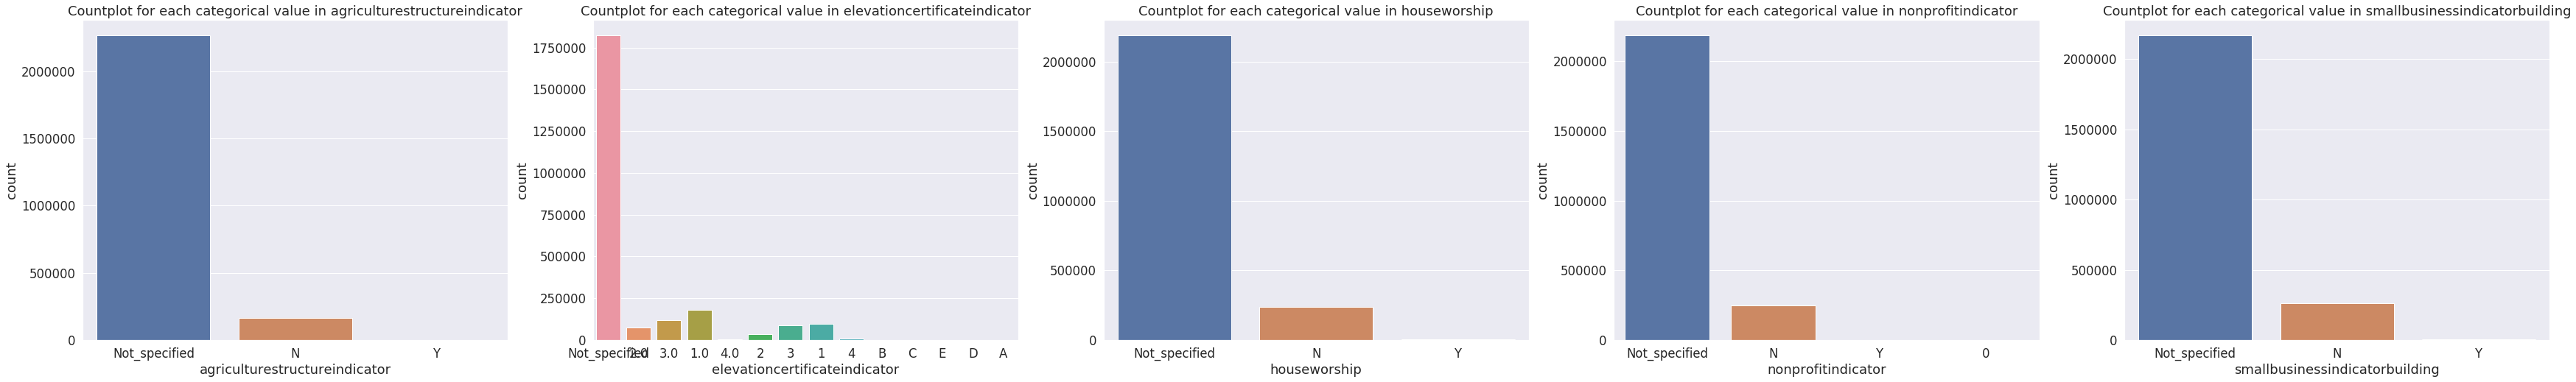

In [0]:
# Plotting categorical plot after filling missing nan values
plt.figure(figsize=(60,8))
cnt = 0
for col in null_percent[null_percent>50].index :
  cnt += 1
  plt.subplot(1, 5, cnt)
  sns.countplot(x = col, data = df_full_fix)
  plt.title("Countplot for each categorical value in "+col)
plt.show()

elevatorecertificateindicator have character values which are are inconsitent with the definition (numerics 1,2,3,4). Also, the numerical types are inconsitent (float and intergers). In addition, the not_specified entries we inserted does not agree with the overall data type (numeric) which will be reset to zero

In [0]:
# Replacing all character to non specificed category and setting non specified category to zero to have similar dtype in
df_full_fix["elevationcertificateindicator"].replace('Not_specified',0, inplace = True)

# Replacing all character to numeric value of 0. It's indiscernible to map the character to their numerical values
char_mat = ['A','B','C','D','E']
for char in char_mat:
  df_full_fix[df_full_fix["elevationcertificateindicator"] == char] = df_full_fix[df_full_fix["elevationcertificateindicator"] == char].replace(char,0)

# Converting all number to integer type
df_full_fix["elevationcertificateindicator"] = df_full_fix["elevationcertificateindicator"].astype(int)

# Listing value count after conversion
df_full_fix["elevationcertificateindicator"].value_counts()

0    1823814
1     280574
3     207006
2     108818
4      12676
Name: elevationcertificateindicator, dtype: int64

nonprofitindicator have value 0 which is replaced with not specified

In [0]:
# Replacing value 0 with 'Not_specified'
df_full_fix[df_full_fix["nonprofitindicator"] == '0'] = df_full_fix[df_full_fix["nonprofitindicator"] == '0'].replace('0','Not_specified')

# Listing value count after conversion
df_full_fix["nonprofitindicator"].value_counts()

Not_specified    2185846
N                 246067
Y                    975
Name: nonprofitindicator, dtype: int64

##Dealing with feature having less than 50% nan values

In [0]:
# all the building indicator, replace nan to 'Not_specified' if not explicitly specified
null_percent[null_percent<50]

asofdate                          0.000000
condominiumindicator              2.388602
elevatedbuildingindicator         2.275156
floodzone                         6.693403
locationofcontents               36.971616
obstructiontype                  36.928005
postfirmconstructionindicator     2.964707
ratemethod                        2.710112
state                             0.000493
primaryresidence                 41.579719
dtype: float64

Using similar logic, the column with Y and N indicatory variables are filled with "Not_Specified" values.

For postfirmconstructionindicator, Yes or No Indicator were assigned based on the definition "if the building construction was started before or after publication of the FIRM (31 December 1974)". The originalconstrutiondate cross referenced and the values assigned to meet the condition.

In [0]:
# Reseting the missing values to be 'Not_specified'
df_full_fix["condominiumindicator"] = df_full_fix["condominiumindicator"].fillna('Not_specified')
df_full_fix["elevatedbuildingindicator"] = df_full_fix["elevatedbuildingindicator"].fillna('Not_specified')
df_full_fix["primaryresidence"] = df_full_fix["primaryresidence"].fillna('Not_specified')

# For filling nan values from post firm construction indicator, I use the reference 31 December 1974
condition = df_full_fix["originalconstructiondate"] > '1974-12-31'
df_full_fix.loc[condition,'postfirmconstructionindicator'] = df_full_fix.loc[condition,'postfirmconstructionindicator'].fillna('Y')
df_full_fix.loc[~condition,'postfirmconstructionindicator'] = df_full_fix.loc[~condition,'postfirmconstructionindicator'].fillna('N')

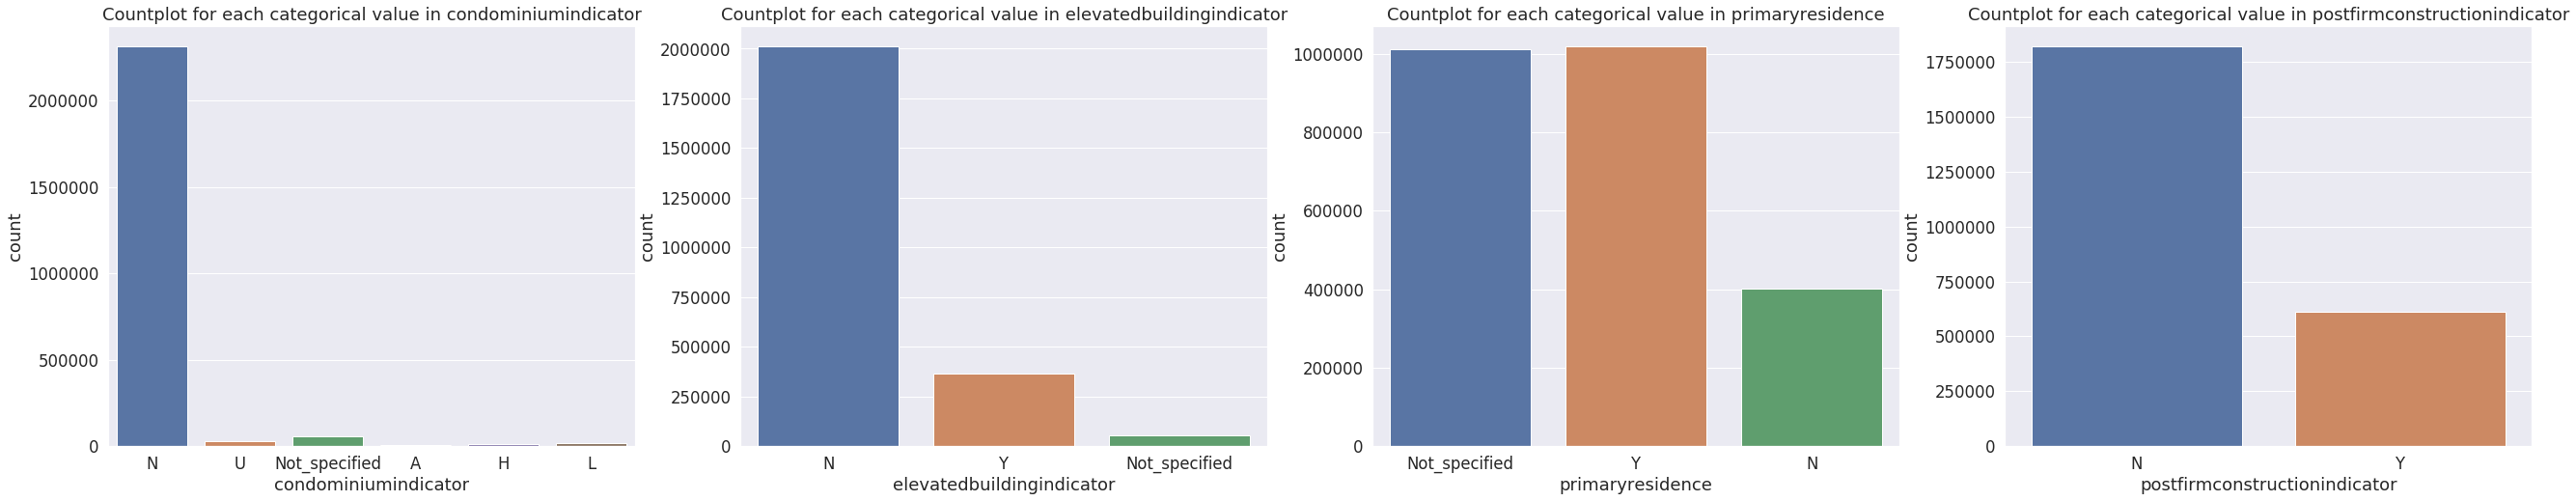

In [0]:
col_mat = ['condominiumindicator','elevatedbuildingindicator','primaryresidence','postfirmconstructionindicator']
# Plotting categorical plot after filling missing nan values
plt.figure(figsize=(45,8))
cnt = 0
for col in col_mat:
  cnt += 1
  plt.subplot(1, 4, cnt)
  sns.countplot(x = col, data = df_full_fix)
  plt.title("Countplot for each categorical value in "+col)
plt.show()

We now clean the columns listed below and transform to a usable feature on case by case basis:
1. Floodzone
2. Location of content
3. obstruction type
4. Rate method

### Floodzone

---



---



Looking at the floodzone columns we find multiple values which need to be interpreted correctly (refer to the datasource information). However, we also find non alpha numeric dataentries such as '05',0, 'A--' etc that do not follow the code definition. Consequently, the missing values and incorrect data entries are assigned 'N' code.

Based on the codes assigned, the floodzone can be broadly classified based on the first character of the code and a new feature floodzone_code is created as: 
1. Special Flood: A 
2. Moderate Flood: B
3. Minimum Flood: C
4. Possible Flood: D
5. Velocity Flood: V
6. Moderate/Minimum Flood: X
7. Not specified: N



In [0]:
# Unique Flood Codes. Filling NAN values with a new code N (not specified)
df_full_fix["floodzone"] = df_full_fix["floodzone"].fillna('N')
rawcodearr = df_full_fix["floodzone"].unique()
rawcodearr

array(['X', 'AE', 'VE', 'A00', 'N', 'A10', 'A08', 'V', 'C', 'A12', 'A',
       'A14', 'AO', 'B', 'A15', 'A99', 'A11', 'A0B', 'A13', 'AOB', 'V12',
       'A06', 'AHB', 'D', 'A18', 'V21', 'V14', 'A05', 'A16', 'AH', 'A03',
       'V18', 'V07', 'A04', 'V16', 'V15', 'A07', 'A01', 'A09', 'V11',
       'A02', 'AR', 'V13', 'V17', 'V20', 'V10', 'V06', 'V05', 'V09',
       'V08', 'V03', 'A17', 'A21', 'A20', 'A22', 'A19', 'A24', 'A30',
       'V19', 'A25', 'V22', 'V04', 'V02', 'A23', 'V01', 'V23', 'A26',
       'A28', 'A27', 'A29', 0, 'V24', 'V30', 'V27', 'AA', '000', 'OOO',
       'A--', 'AO5', '119', 'C00', '5', '07', 'A3', '01', '14', 'A60',
       'A36', 'A6', 'A9', '05', 'C31', 'A32', 'A50', 'A7', 'A4', '08',
       '0'], dtype=object)

In [0]:
# Fixing the remaining [0, '000', 'OOO', '119', '5', '07', '01', '14', '05', '08', '0'] values with N
floodcode = ['A','B','C','D','V','X','N']
codearr = []
for col in floodcode: 
  tmp=[] 
  print("Flood Code starting with {} : {}".format(col,np.sort(df_full_fix[df_full_fix["floodzone"].str.find(col) == 0]["floodzone"].unique())))
  tmp = np.sort(df_full_fix[df_full_fix["floodzone"].str.find(col) == 0]["floodzone"].unique())
  for num in tmp:
    codearr.append(num)
    
# Getting the inconsistent codes and replacing with 'N'
ans = np.setdiff1d(rawcodearr, codearr,assume_unique = True).tolist()
for val in ans:
  df_full_fix.loc[df_full_fix["floodzone"] == val,"floodzone"] = 'N'

Flood Code starting with A : ['A' 'A--' 'A00' 'A01' 'A02' 'A03' 'A04' 'A05' 'A06' 'A07' 'A08' 'A09'
 'A0B' 'A10' 'A11' 'A12' 'A13' 'A14' 'A15' 'A16' 'A17' 'A18' 'A19' 'A20'
 'A21' 'A22' 'A23' 'A24' 'A25' 'A26' 'A27' 'A28' 'A29' 'A3' 'A30' 'A32'
 'A36' 'A4' 'A50' 'A6' 'A60' 'A7' 'A9' 'A99' 'AA' 'AE' 'AH' 'AHB' 'AO'
 'AO5' 'AOB' 'AR']
Flood Code starting with B : ['B']
Flood Code starting with C : ['C' 'C00' 'C31']
Flood Code starting with D : ['D']
Flood Code starting with V : ['V' 'V01' 'V02' 'V03' 'V04' 'V05' 'V06' 'V07' 'V08' 'V09' 'V10' 'V11'
 'V12' 'V13' 'V14' 'V15' 'V16' 'V17' 'V18' 'V19' 'V20' 'V21' 'V22' 'V23'
 'V24' 'V27' 'V30' 'VE']
Flood Code starting with X : ['X']
Flood Code starting with N : ['N']


In [0]:
# Creating a new feature to include the character code only.
for col in floodcode: 
  df_full_fix.loc[df_full_fix["floodzone"].str.find(col) == 0,"floodzone_code"] = col
df_full_fix["floodzone_code"].unique()

array(['X', 'A', 'V', 'N', 'C', 'B', 'D'], dtype=object)

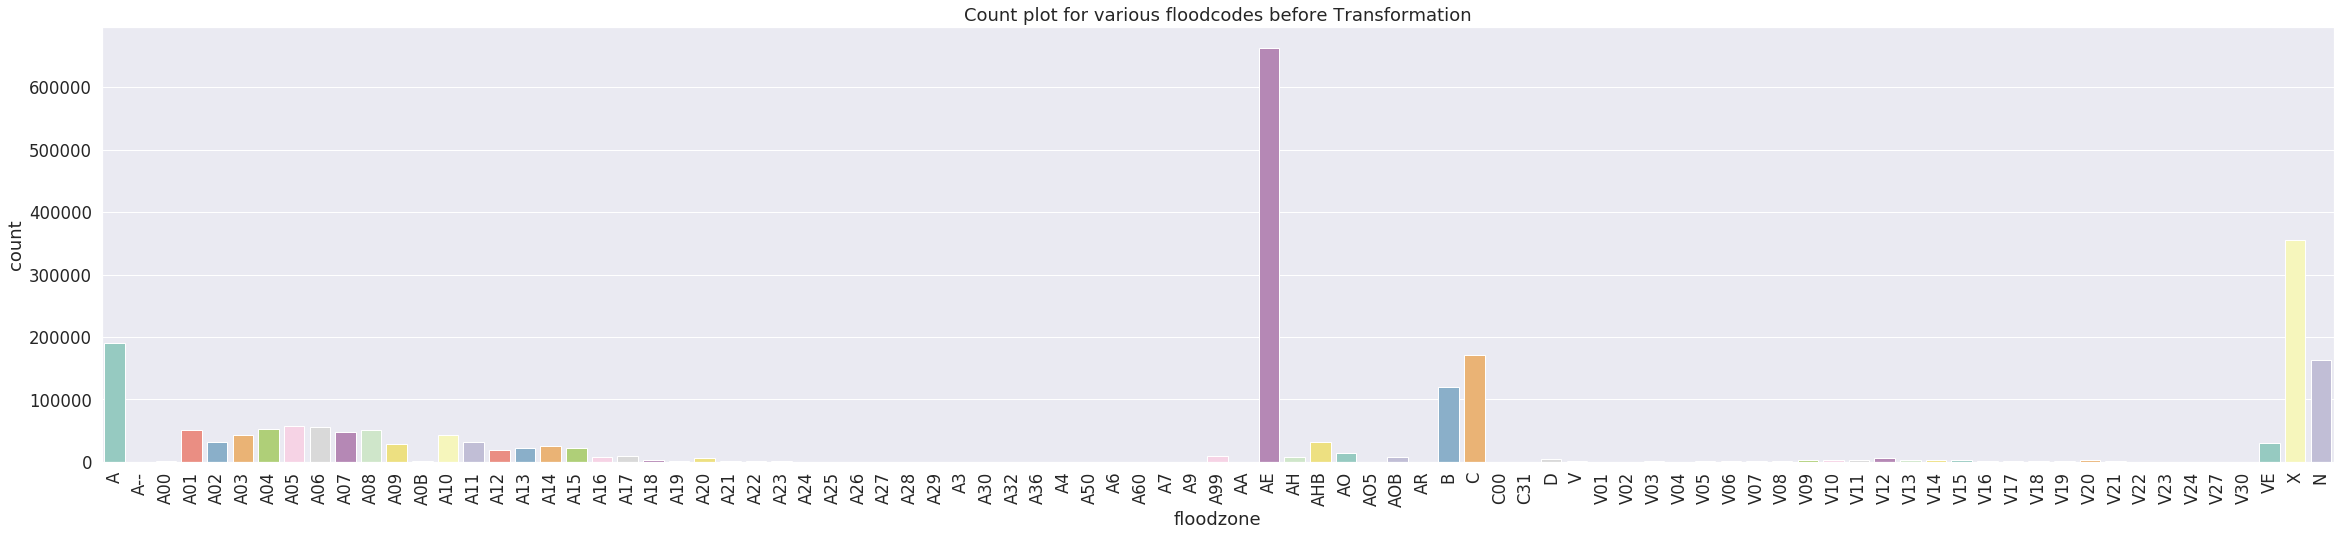

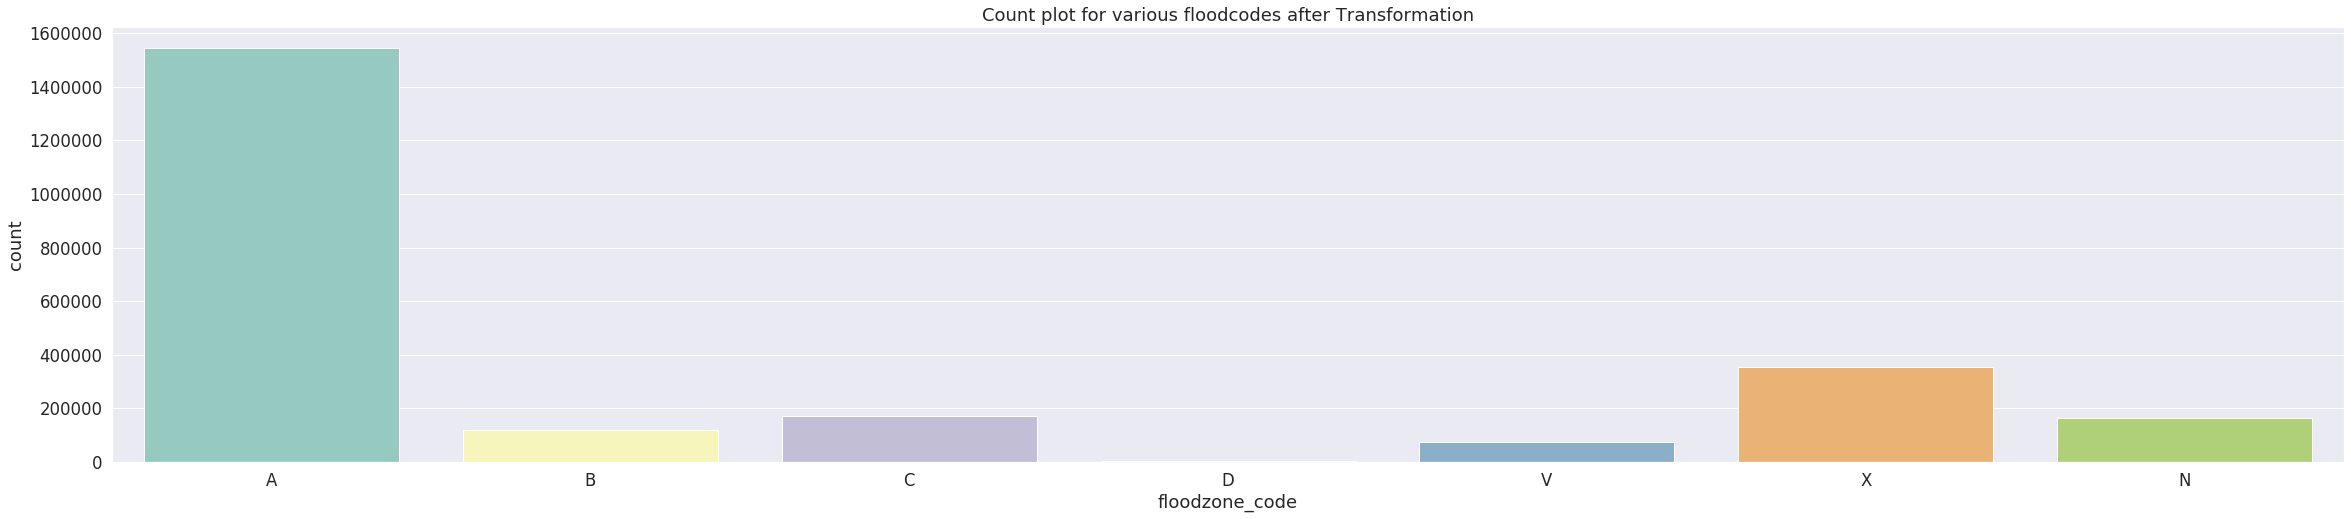

In [0]:
# Plotting the distribution of floodzone code before and after tranformation
plt.figure(figsize=(40,8))
ax = sns.countplot(x = "floodzone", data = df_full_fix, order = codearr,palette="Set3")
plt.title("Count plot for various floodcodes before Transformation")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90) 
plt.show()

plt.figure(figsize=(40,8))
sns.countplot(x = "floodzone_code", data = df_full_fix, order = floodcode,palette="Set3")
plt.title("Count plot for various floodcodes after Transformation")
plt.show()

### Location of Content

---



---



The missing values for locationofcontent is filled with "No details provided". And to simplify this feature, a numerical coding system is assigned

In [0]:
# Fill the nan values with "No details provided"
df_full_fix["locationofcontents"] = df_full_fix["locationofcontents"].fillna('No details provided')

# Assigning numeric code to the locationofcontents category
val_col = df_full_fix["locationofcontents"].unique()
code_col = 1+np.arange(0,7)
for i in np.arange(0,7):
  df_full_fix.loc[df_full_fix["locationofcontents"] == val_col[i],"locationofcontents_code"] = code_col[i]

Text(0.5, 1.0, 'Count plot for various Location of Content (Transformed)')

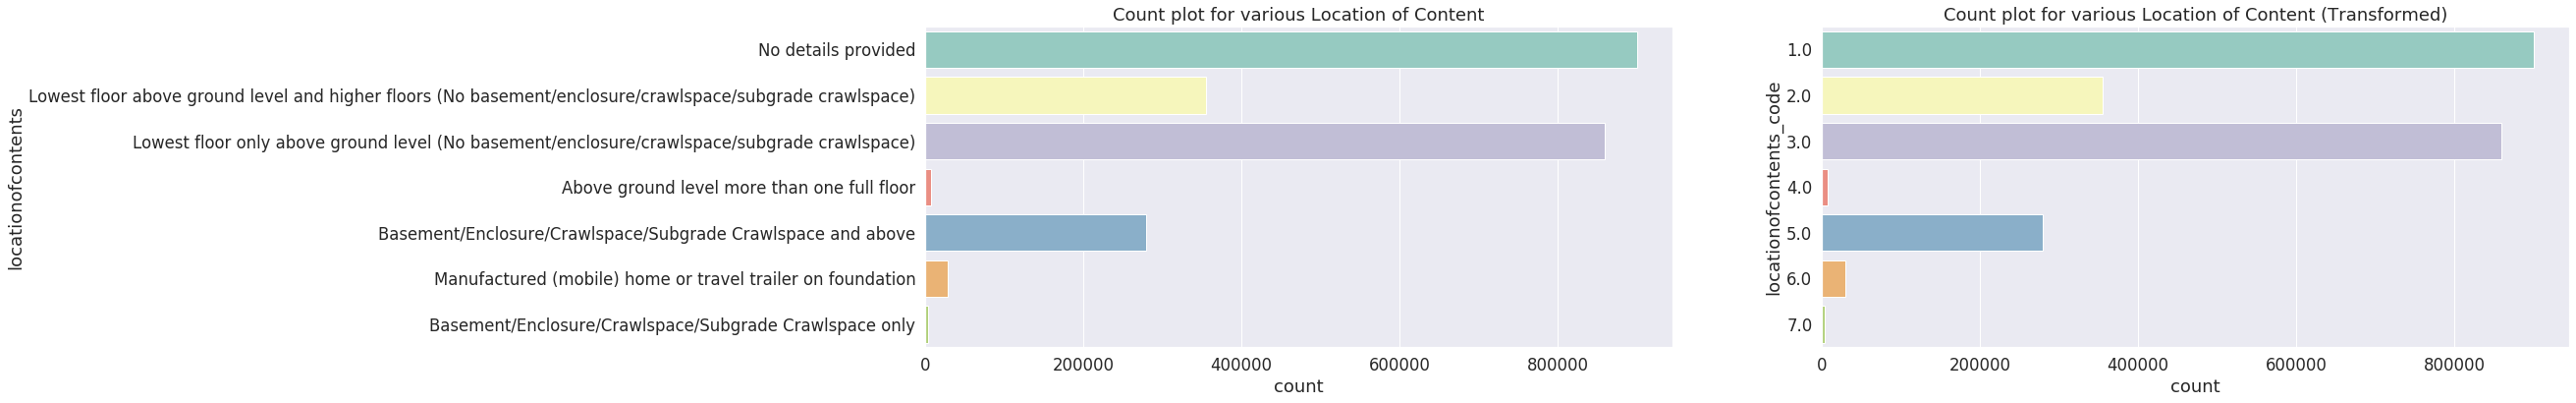

In [0]:
plt.figure(figsize=(30,6))
plt.subplot(1, 2, 1)
sns.countplot(y = "locationofcontents", data = df_full_fix,palette="Set3")
plt.title("Count plot for various Location of Content")

plt.subplot(1, 2, 2)
sns.countplot(y = "locationofcontents_code", data = df_full_fix,palette="Set3")
plt.title("Count plot for various Location of Content (Transformed)")

### Obstructiontype

---



---



The column contains a wild character (*,0.0,1.0) and some numerical codes in string format. The missing values and wild character was assigned 999 and the overall datatype rest to integer

In [0]:
df_full_fix["obstructiontype"].unique()

array([10.0, nan, 60.0, 50.0, 54.0, 20.0, 15.0, 80.0, 30.0, 92.0, 70.0,
       24.0, 34.0, 90.0, 40.0, 98.0, 0.0, 96.0, 95.0, 94.0, 97.0, '10',
       '60', '20', '50', '15', '54', '92', '30', '*', '80', '70', '40',
       '34', '24', '90', 1.0], dtype=object)

Text(0.5, 1.0, 'Count plot for various obstruction type')

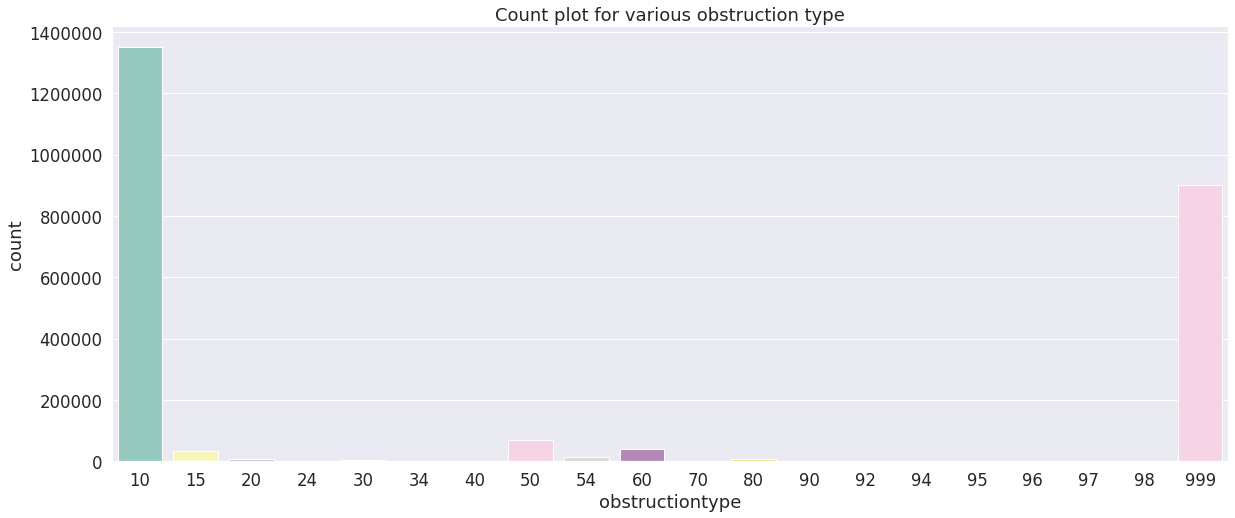

In [0]:
# Fill the nan values and special values with 999
sel_code = [15,20,24,30,34,40,50,54,60,70,80,90,91,92,94,95,96,97,98]
df_full_fix["obstructiontype"] = df_full_fix["obstructiontype"].fillna(999)
spl_code = [0.0,1.0,'*']
for code in spl_code:
  df_full_fix.loc[df_full_fix["obstructiontype"] == code,"obstructiontype"] = 999
df_full_fix["obstructiontype"] = df_full_fix["obstructiontype"].astype('int')

# plot for obstruction type distribution
plt.figure(figsize=(20,8))
sns.countplot(x = "obstructiontype", data = df_full_fix,palette="Set3")
plt.title("Count plot for various obstruction type")

### Ratemethod

---



---



Similar to obsruction type. Both character and numerical code exist and were preserved. The numerical datatype were reset to integer and missing values filled with 999

In [0]:
df_full_fix['ratemethod'].unique()

array(['7', '1', '2', nan, '4', 'B', 'A', 'Q', 'P', 'W', '3', '8', 'S',
       '6', 'F', '9', 'E', '5', 0, 1, 3, 7, 2, 4, 9.0, 8.0, 5.0, 6.0, 'G',
       'T'], dtype=object)

In [0]:
# Fill the nan values and special values with 999
df_full_fix["ratemethod"] = df_full_fix["ratemethod"].fillna(999)

# Correct the data type of ratemethod values
rate_col = ['1','2','3','4','5','6','7','8','9',5.0,6.0,8.0,9.0]
for rate in rate_col:
  df_full_fix.loc[df_full_fix['ratemethod'] == rate,'ratemethod'] = df_full_fix.loc[df_full_fix['ratemethod'] == rate,'ratemethod'].astype('int')
df_full_fix.loc[df_full_fix['ratemethod'] == 0,'ratemethod'] = 999

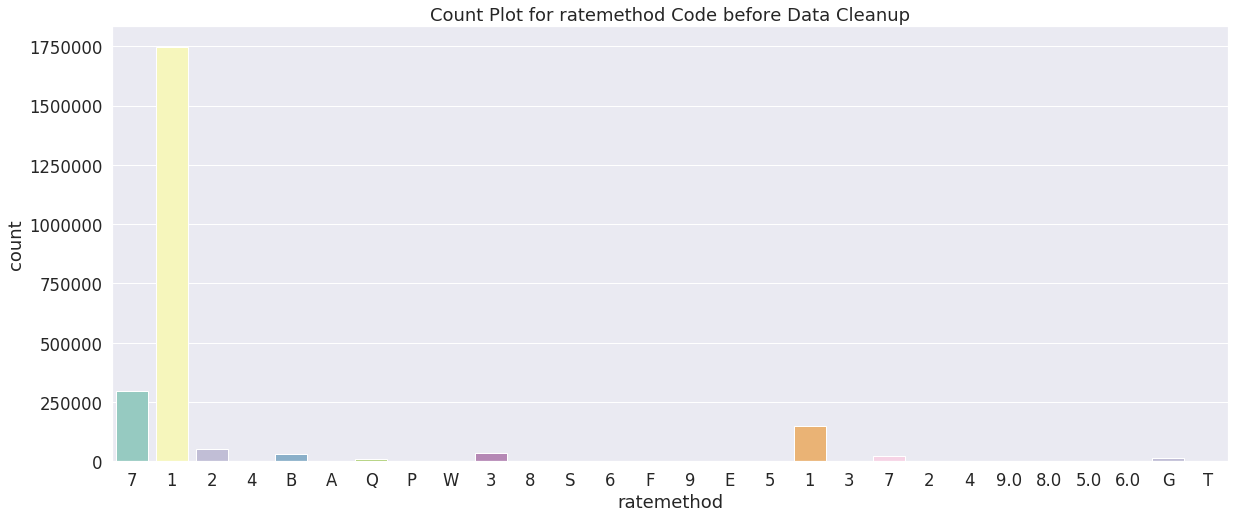

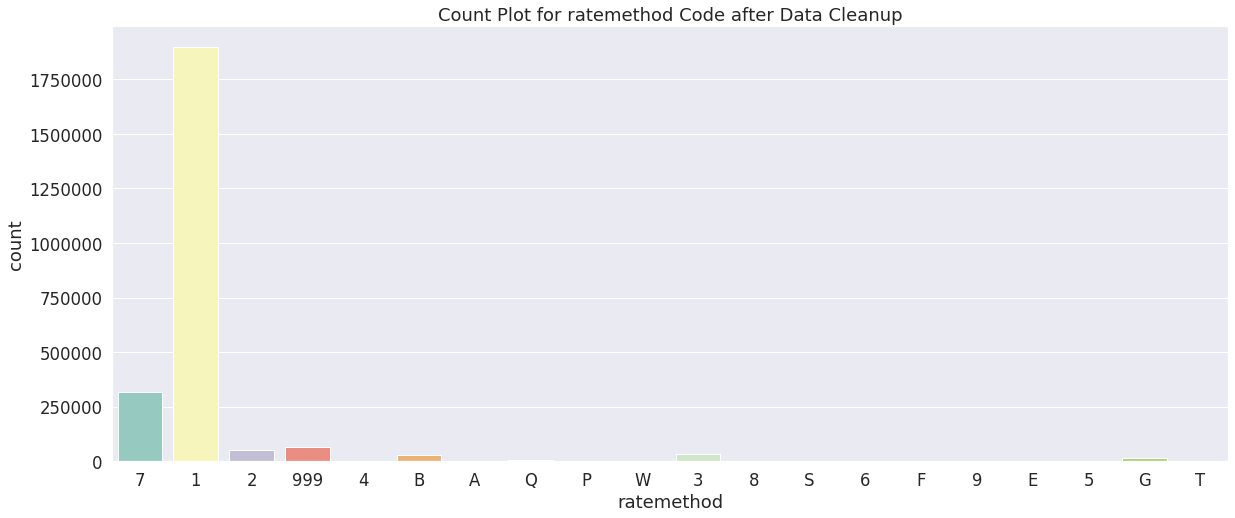

In [0]:
# Plotting categorical plot before and after deata clenup
plt.figure(figsize=(20,8))
sns.countplot(x = "ratemethod", data = df_full,palette="Set3")
plt.title("Count Plot for ratemethod Code before Data Cleanup")
plt.show()

plt.figure(figsize=(20,8))
sns.countplot(x = "ratemethod", data = df_full_fix,palette="Set3")
plt.title("Count Plot for ratemethod Code after Data Cleanup")
plt.show()

### State

Record with missing state entries also have missing values for most of the key features of datasets including amount paid claims, total insurance coverage, location related featuresuch as latitude,longitude, zipcode, censustract, county code etc.

These 12 record are, therefore, dropped from the datasets 

In [0]:
# Looking at the record with NAN state most of the features are missing hence we drop the rows
df_full_fix[df_full_fix['state'].isnull()]

agriculturestructureindicator  ... locationofcontents_code
470781                  Not_specified  ...                     1.0
471969                  Not_specified  ...                     1.0
472582                  Not_specified  ...                     1.0
576933                  Not_specified  ...                     1.0
662952                  Not_specified  ...                     1.0
663100                  Not_specified  ...                     1.0
998210                  Not_specified  ...                     1.0
1545015                 Not_specified  ...                     1.0
1596952                 Not_specified  ...                     1.0
1606840                 Not_specified  ...                     1.0
1807741                 Not_specified  ...                     1.0
2160725                 Not_specified  ...                     1.0

[12 rows x 41 columns]

In [0]:
# Dropping the 12 record with nan state values
cond = df_full_fix['state'].isnull()
df_full_fix = df_full_fix[~cond].reset_index()
df_full_fix.drop(['index'], axis = 1, inplace = True)

Histrogram distribution of the states clearly suggest a high count for the top eight states of LA, TX, FL, NJ, NY, NC, PA and MS

Text(0.5, 1.0, 'Count Plot for State')

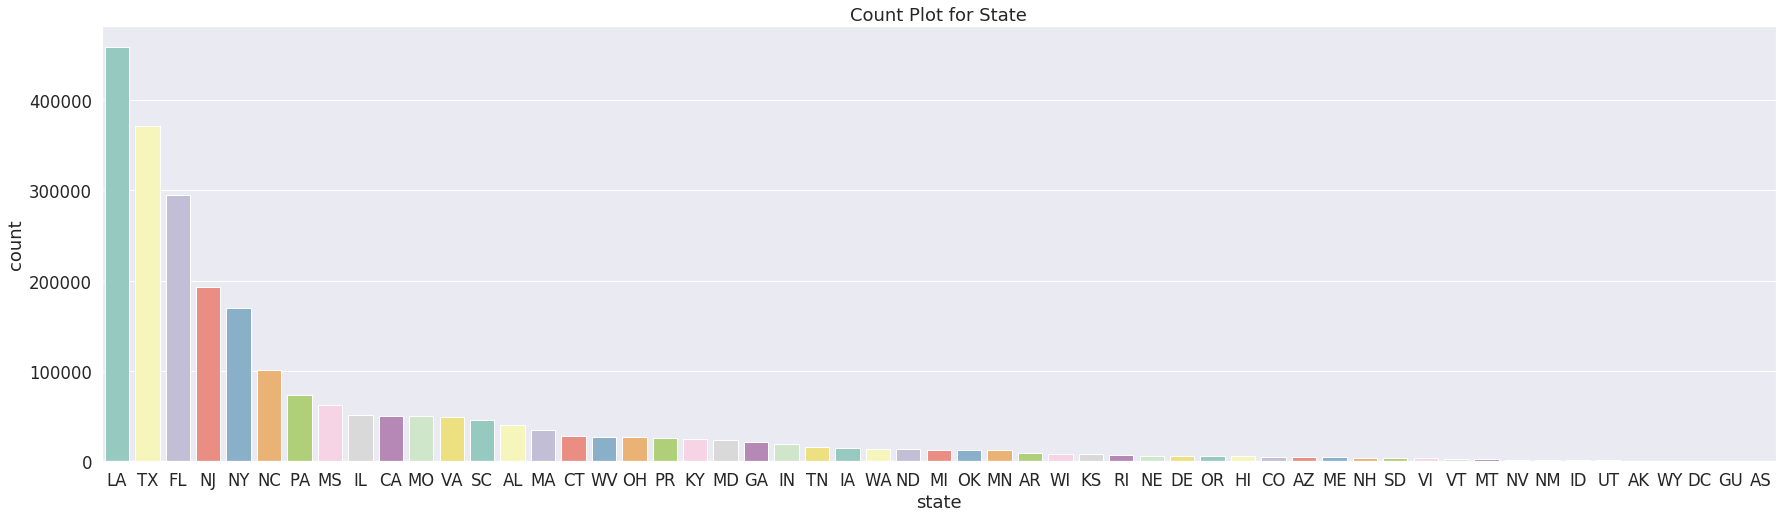

In [0]:
# Histrogram plot for states 
plt.figure(figsize=(30,8))
sns.countplot(x = "state", data = df_full_fix,order=df_full_fix['state'].value_counts().index , palette="Set3")
plt.title("Count Plot for State")

In [0]:
# Removing the old columns and adding transformed columns for QC
sel_col_less_100.remove('asofdate')
sel_col_less_100.remove('floodzone')
sel_col_less_100.remove('locationofcontents')
sel_col_less_100.append('floodzone_code')
sel_col_less_100.append('locationofcontents_code')

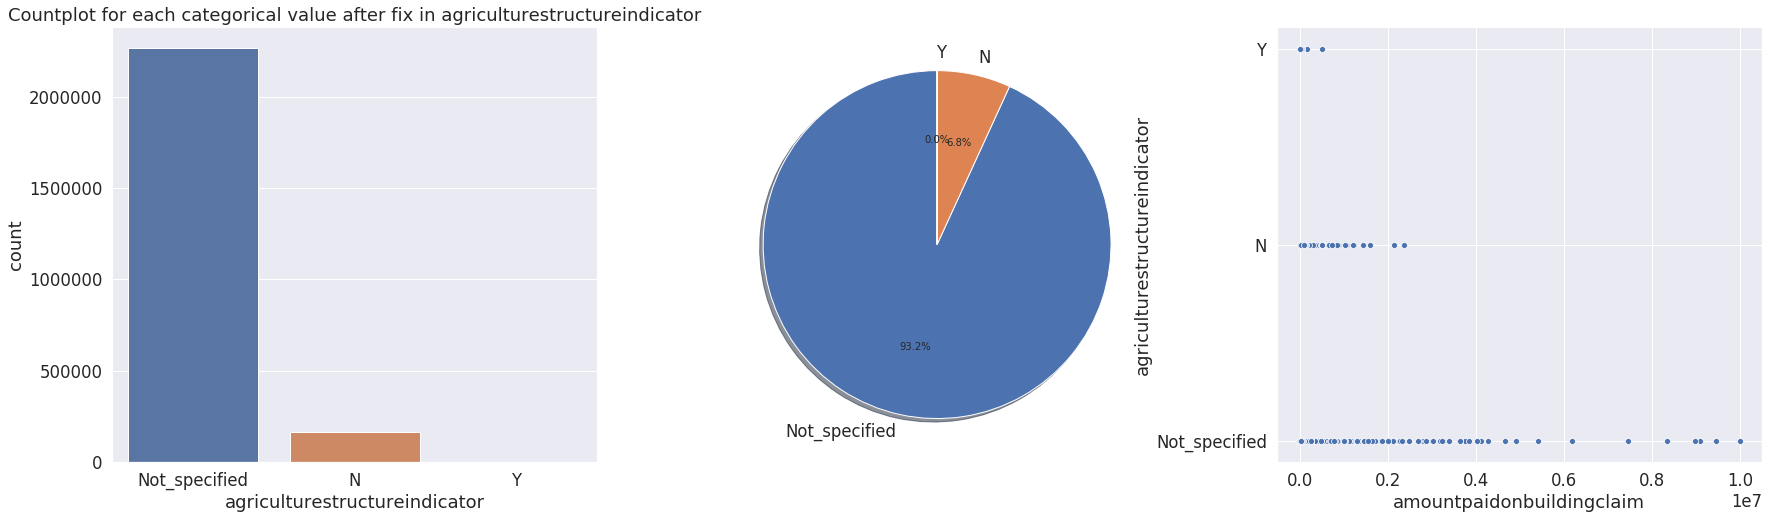

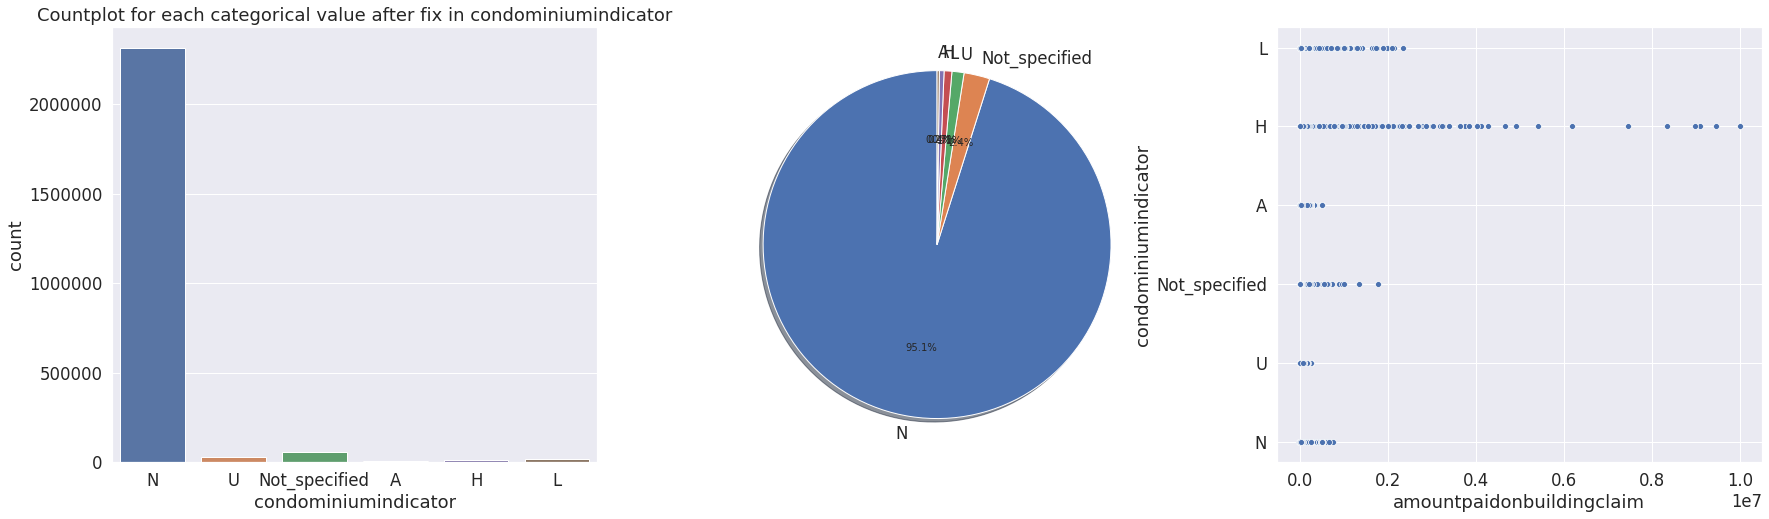

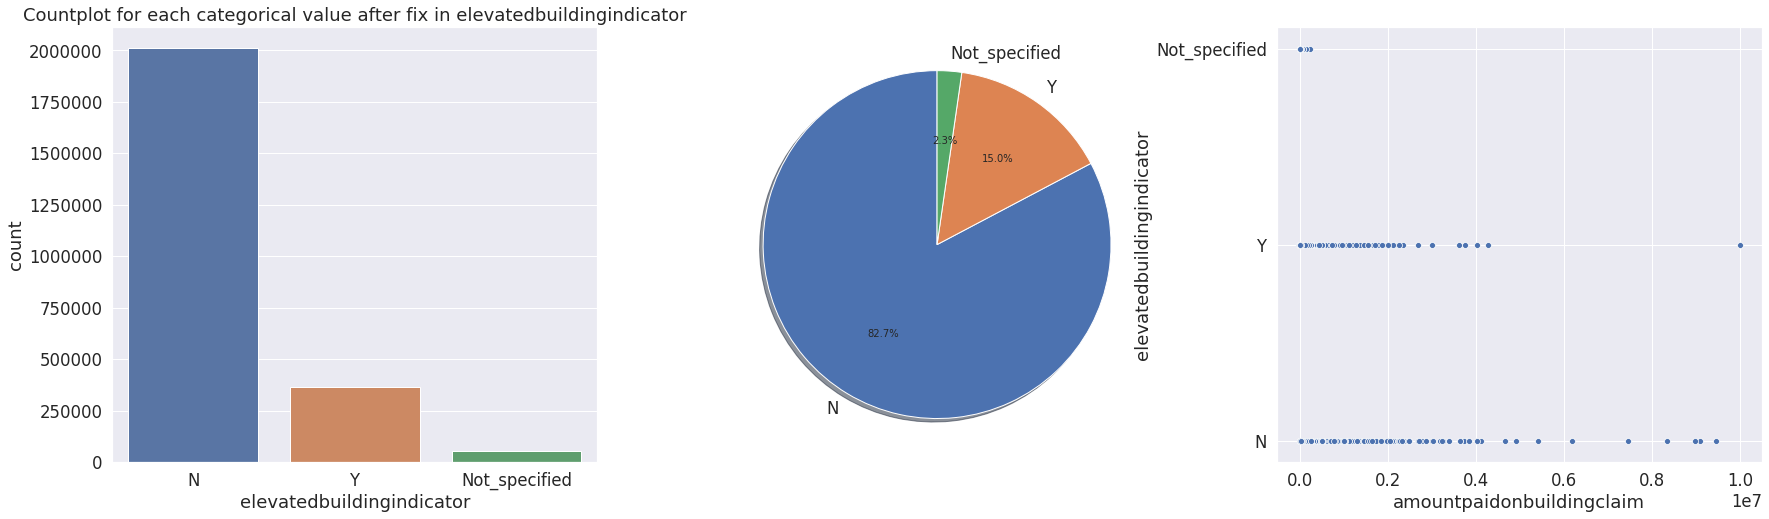

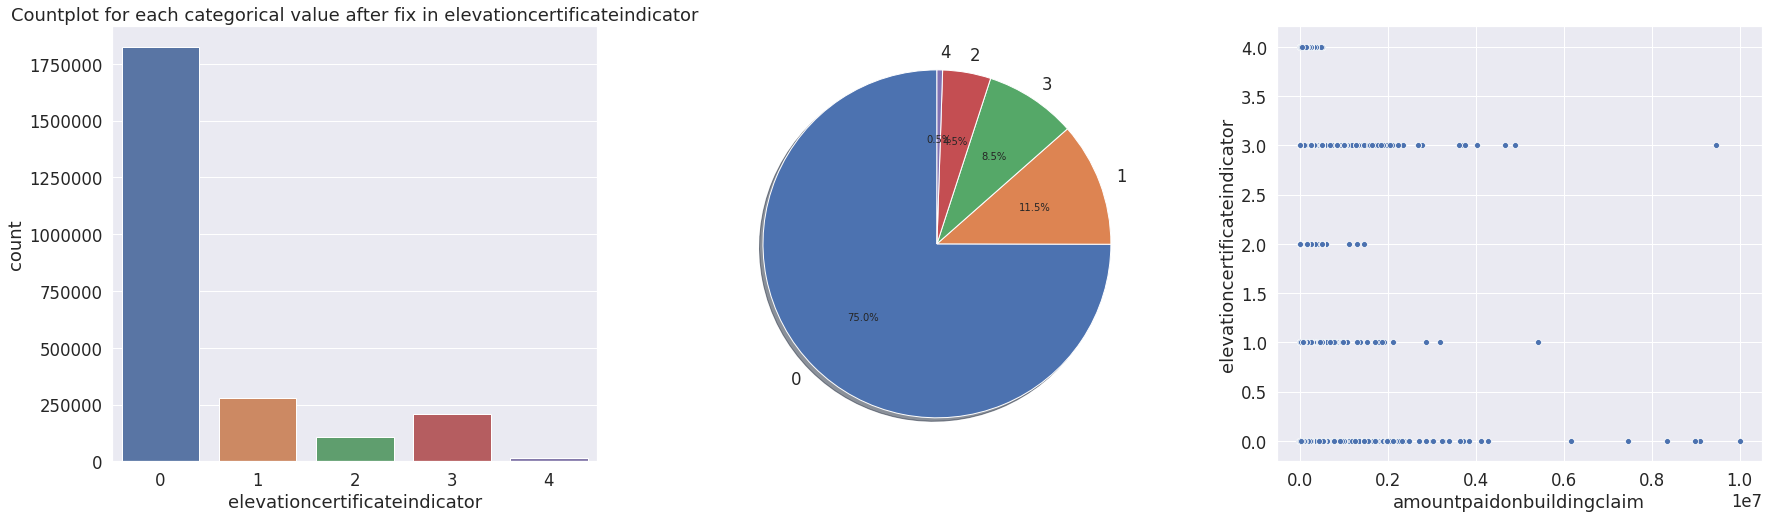

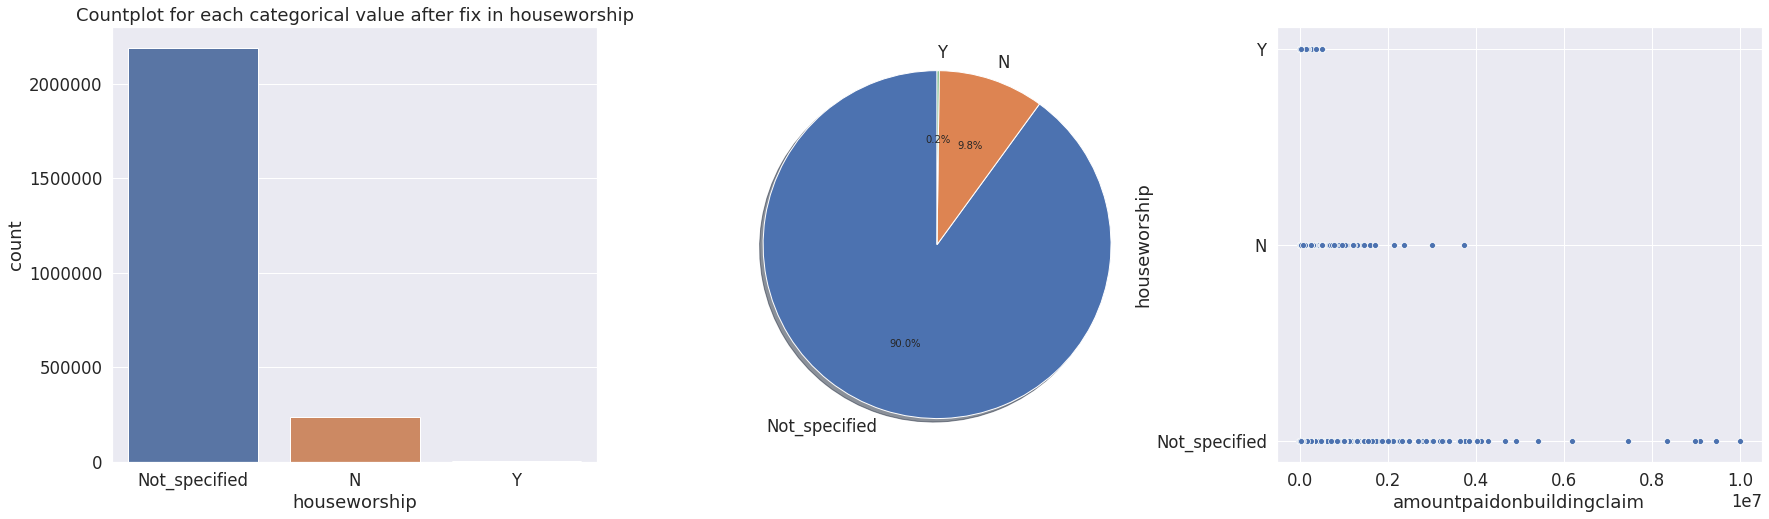

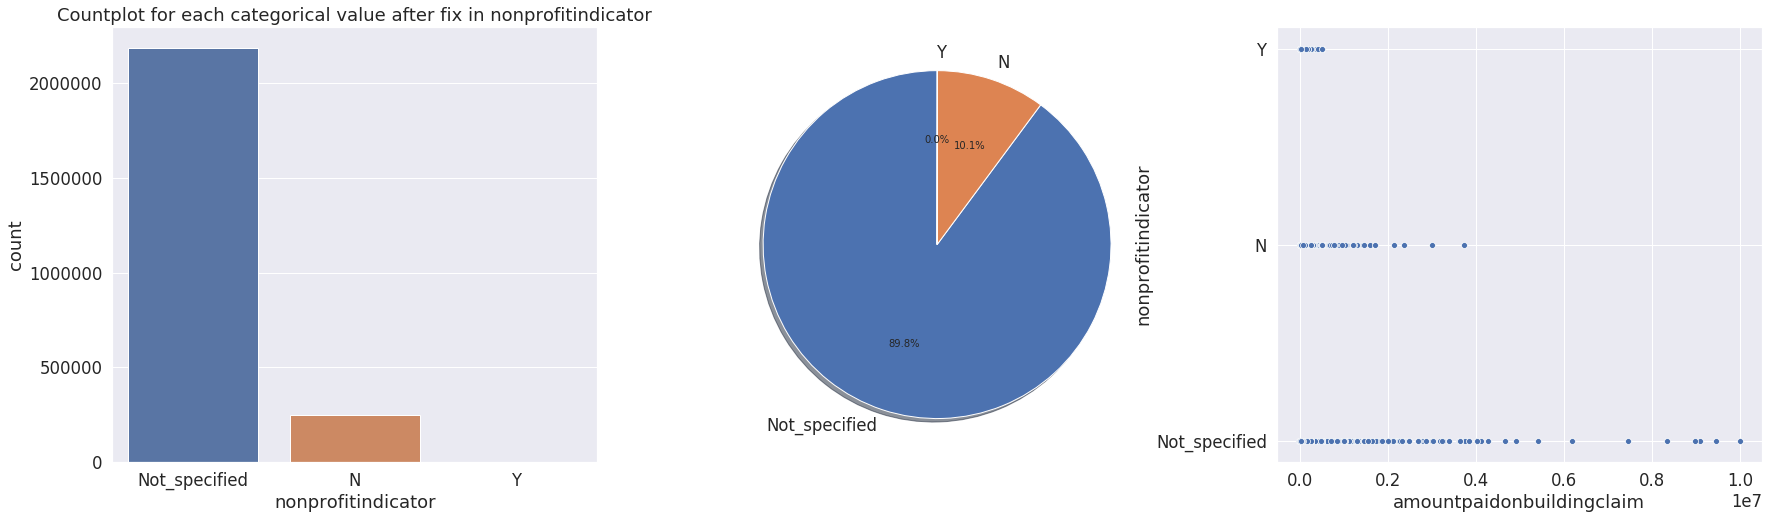

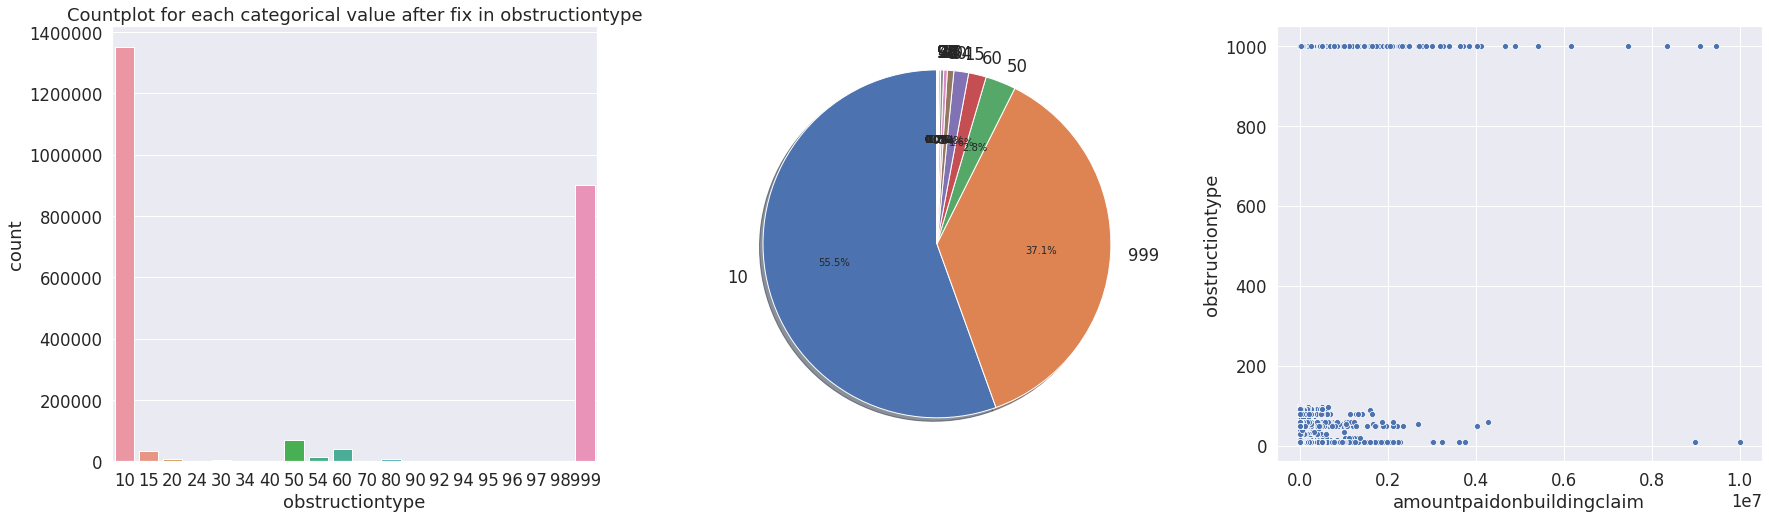

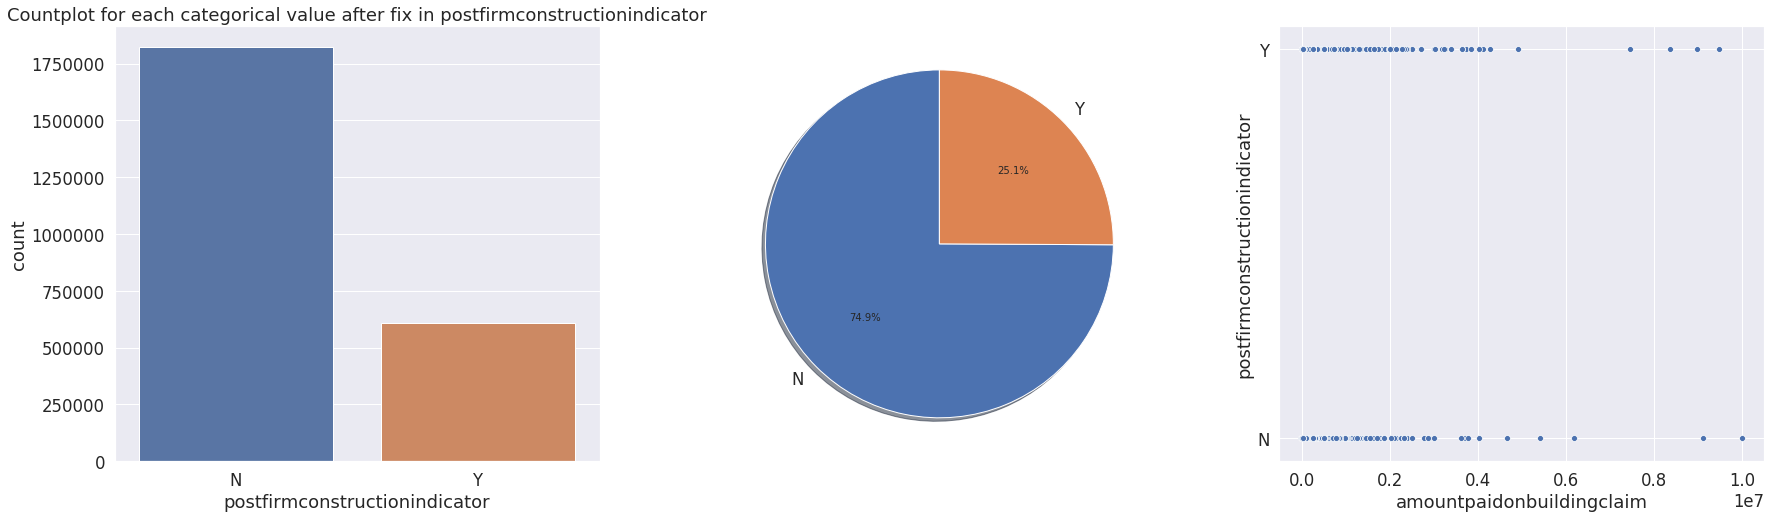

ValueError: ignored

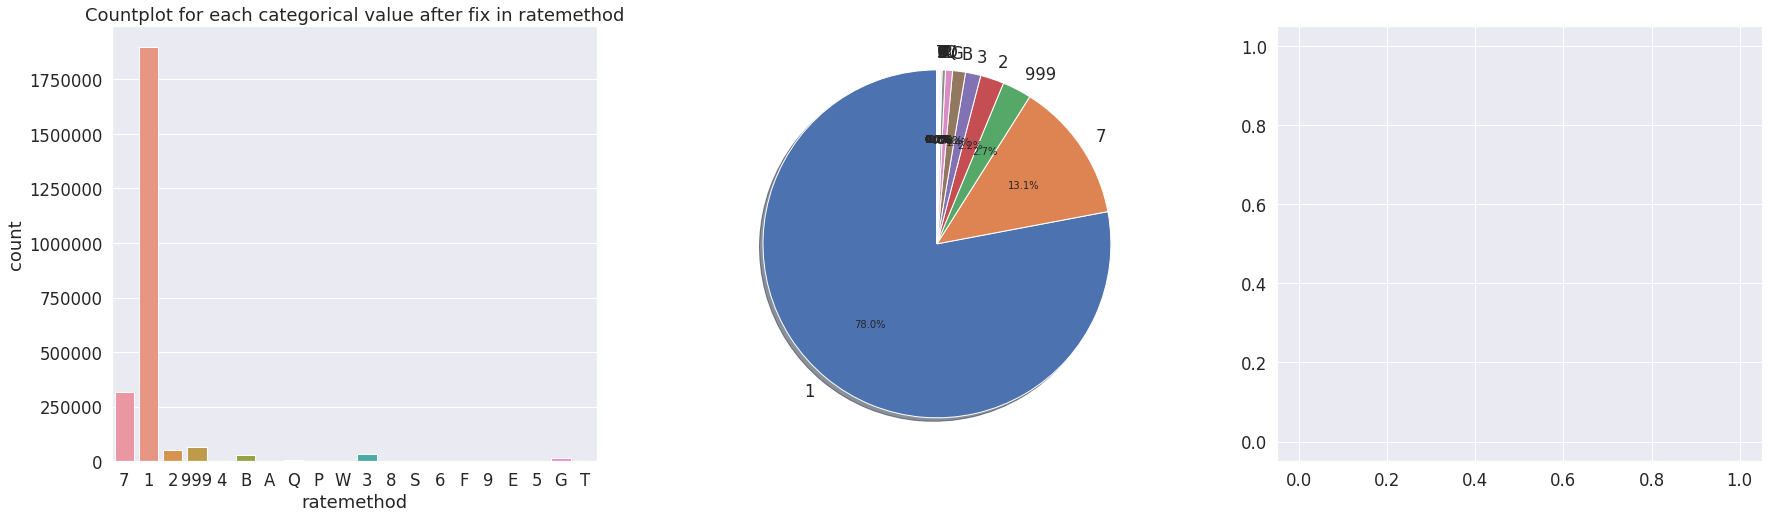

In [0]:
# Plotting categorical plot before and after fix

for col in sel_col_less_100 :
  plt.figure(figsize=(40,8))
  #plt.subplot(1, 4, 1)
  #sns.countplot(x = col, data = df_full)
  #plt.title("Countplot for each categorical value before fix in "+col)

  plt.subplot(1, 4, 1)
  sns.countplot(x = col, data = df_full_fix)
  plt.title("Countplot for each categorical value after fix in "+col)

  plt.subplot(1, 4, 2)
  count = df_full_fix[col].value_counts()
  labels = df_full_fix[col].value_counts().index
  ax = plt.pie(count, labels=labels,shadow=True, autopct='%1.1f%%',startangle=90)
  #ax.axes('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  #ax = sns.boxplot( x=col, y="amountpaidonbuildingclaim" , data=df_full_fix)
  #ax.set(yscale="log")
  #plt.xlabel(col)
  #plt.ylabel("amountpaidonbuildingclaim")
  #plt.ylim(1,10000000)

  plt.subplot(1, 4, 3)
  sns.scatterplot(df_full_fix['amountpaidonbuildingclaim'], df_full_fix[col])
  plt.show()

In [0]:
sel_col_less_100

['agriculturestructureindicator',
 'condominiumindicator',
 'elevatedbuildingindicator',
 'elevationcertificateindicator',
 'houseworship',
 'nonprofitindicator',
 'obstructiontype',
 'postfirmconstructionindicator',
 'ratemethod',
 'smallbusinessindicatorbuilding',
 'state',
 'primaryresidence',
 'floodzone_code',
 'locationofcontents_code']

### B) Data Cleaning: *Columns* more than 100 unique values

In total three columns need data cleanup. One is reported in date format and will be converted to the individual year, month and day columns
Other two are reported as city and zipcode. 

In [0]:
# Listing columns with more than 100 unique values
sel_col_gt_100 = [col for col in sel_col if df_full_fix[col].nunique() >= 100]
sel_col_gt_100

['reportedcity',
 'dateofloss',
 'originalconstructiondate',
 'originalnbdate',
 'reportedzipcode']

In [0]:
# looking at the unique values greater than 100 features
for col in sel_col_gt_100:
  print("Greater than 100 Uniques values for feature {}:\t{}".format(col,df_full[col].unique()))

Greater than 100 Uniques values for feature reportedcity:	['OCEANSIDE' 'NEW ORLEANS' 'NAVARRE' ... 'SUMAVA RSTS' 'SANDESTIN DESTIN'
 'UNIVERSAL CTY']
Greater than 100 Uniques values for feature dateofloss:	['1998-02-07' '2005-08-29' '1998-09-28' ... '2013-11-19' '2011-01-29'
 '2014-10-26']
Greater than 100 Uniques values for feature originalconstructiondate:	['1963-01-01' '1967-07-01' '1972-01-01' ... '2010-04-18' '1962-07-24'
 '1924-11-18']
Greater than 100 Uniques values for feature originalnbdate:	['1997-01-11' '1990-07-12' '1997-07-24' ... '2019-06-29' '2019-08-08'
 '2019-07-23']
Greater than 100 Uniques values for feature reportedzipcode:	[92056 70131 32566 ... 38028 15020 45320]


In [0]:
# Count nulls 
null_percent = 100*df_full_fix[sel_col_gt_100].isnull().sum()/df_full_fix[sel_col_gt_100].isnull().count()
null_percent

reportedcity                 0.184761
dateofloss                   0.000000
originalconstructiondate    15.066654
originalnbdate               0.000000
reportedzipcode              0.046036
dtype: float64

### Originalconstructiondate

For missing values of original construct dates, we tie it back to the starting for flood insurance policy.We also find one record with invalid dates 1111-11-11

In [0]:
 # Filling mixing value of construction date to original flood insurnace policy date
 df_full_fix.loc[df_full_fix["originalconstructiondate"].isnull(),"originalconstructiondate"] =  df_full_fix.loc[df_full_fix["originalconstructiondate"].isnull(),"originalconstructiondate"].fillna( df_full_fix.loc[df_full_fix["originalconstructiondate"].isnull(),"originalnbdate"])

 # To check for invalid date format
df_full_fix[pd.to_datetime(df_full_fix['originalconstructiondate'], format='%Y-%m-%d', errors='coerce').isnull()]

agriculturestructureindicator  ... locationofcontents_code
549913                 Not_specified  ...                     3.0

[1 rows x 41 columns]

### Reported City

Filling in missing values with Not Specified

In [0]:
# Resetting the missing values of reported city to be 'Not Specified'
df_full_fix["reportedcity"] = df_full_fix["reportedcity"].fillna('Not_specified')

### Reported Zipcode data cleanup

The reported values overall has many inconsistent information with character, special characters, alphanumerics, numeric values in strings format etc. We rest these values to -999 along with the missing zipcode

In [0]:
#df_full_fix[df_full_fix["reportedzipcode"].isnull()]["state"].value_counts()
col_zip = df_full_fix[['countycode','reportedzipcode']]
tst_zip = list(col_zip[~col_zip.applymap(np.isreal)['reportedzipcode']]['reportedzipcode'])
tst_zip_first = [ele[0] for ele in tst_zip]
tst_zip_first_uniq = np.unique(np.array(tst_zip_first))

In [0]:
# Zipcode starting with character or special character
tst_zip_first_uniq

array(['&', "'", ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6',
       '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
       'X', 'Y', 'Z'], dtype='<U1')

In [0]:
# Filling in special character zipcodes with -999
num_arr = ['0','1','2','3','4','5','6','7','8','9']
ans = np.setdiff1d(tst_zip_first_uniq, num_arr,assume_unique = True).tolist()
for col in ans:
  df_full_fix.loc[df_full_fix["reportedzipcode"].str.find(col) != -1,"reportedzipcode"] = -999

# Filling in NAN values with -999
df_full_fix.loc[df_full_fix["reportedzipcode"].str.find(col) == 0,"reportedzipcode"] = df_full_fix.loc[df_full_fix["reportedzipcode"].str.find(col) == 0,"reportedzipcode"].fillna(-999)

In [0]:
# Filling in special alpha-numeric zipcodes with -999
for num in num_arr:
  tr = list(df_full_fix.loc[df_full_fix["reportedzipcode"].str.find(num) == 0,"reportedzipcode"].unique())
  tr_val = [val for val in tr if str(val).find(' ') != -1]
  for tval in tr_val:
    df_full_fix.loc[df_full_fix["reportedzipcode"] == tval,"reportedzipcode"] = -999
  df_full_fix.loc[df_full_fix["reportedzipcode"].str.find(num) == 0,"reportedzipcode"] = df_full_fix.loc[df_full_fix["reportedzipcode"].str.find(num) == 0,"reportedzipcode"].astype('int')

With data celanup and missing value fillin, most of the values default to -999 (aproximately 85%) 

In [0]:
df_full_fix["reportedzipcode"].value_counts()

-999      1916567
 0          34025
 99999      10654
 70072       6711
 10000       3572
           ...   
 58038          1
 59002          1
 22124          1
 97865          1
 5753           1
Name: reportedzipcode, Length: 17288, dtype: int64

## Features of int or float datatype

In [0]:
# Float or int data type
non_object_col = df_full.columns[df_full.dtypes != 'object']

# Count nulls 
null_percent = 100*df_full_fix[non_object_col].isnull().sum()/df_full_fix[non_object_col].isnull().count()
null_percent

basefloodelevation                            80.122908
basementenclosurecrawlspacetype                0.001521
policycount                                    0.000000
countycode                                     0.307907
crsdiscount                                    0.000000
elevationdifference                            0.000000
censustract                                    2.436951
latitude                                       2.200523
longitude                                      2.200523
lowestadjacentgrade                           85.584181
lowestfloorelevation                          80.473029
numberoffloorsintheinsuredbuilding             0.683923
occupancytype                                  0.029101
amountpaidonbuildingclaim                      3.015608
amountpaidoncontentsclaim                     29.590041
amountpaidonincreasedcostofcomplianceclaim    52.304721
totalbuildinginsurancecoverage                 0.000000
totalcontentsinsurancecoverage                 0

We deal with basefloodelevation, lowestfloorelevation , lowestadjacentgrade and elevation difference together.

From definition
elevation difference = lowestfloorelevation - basefloodelevation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


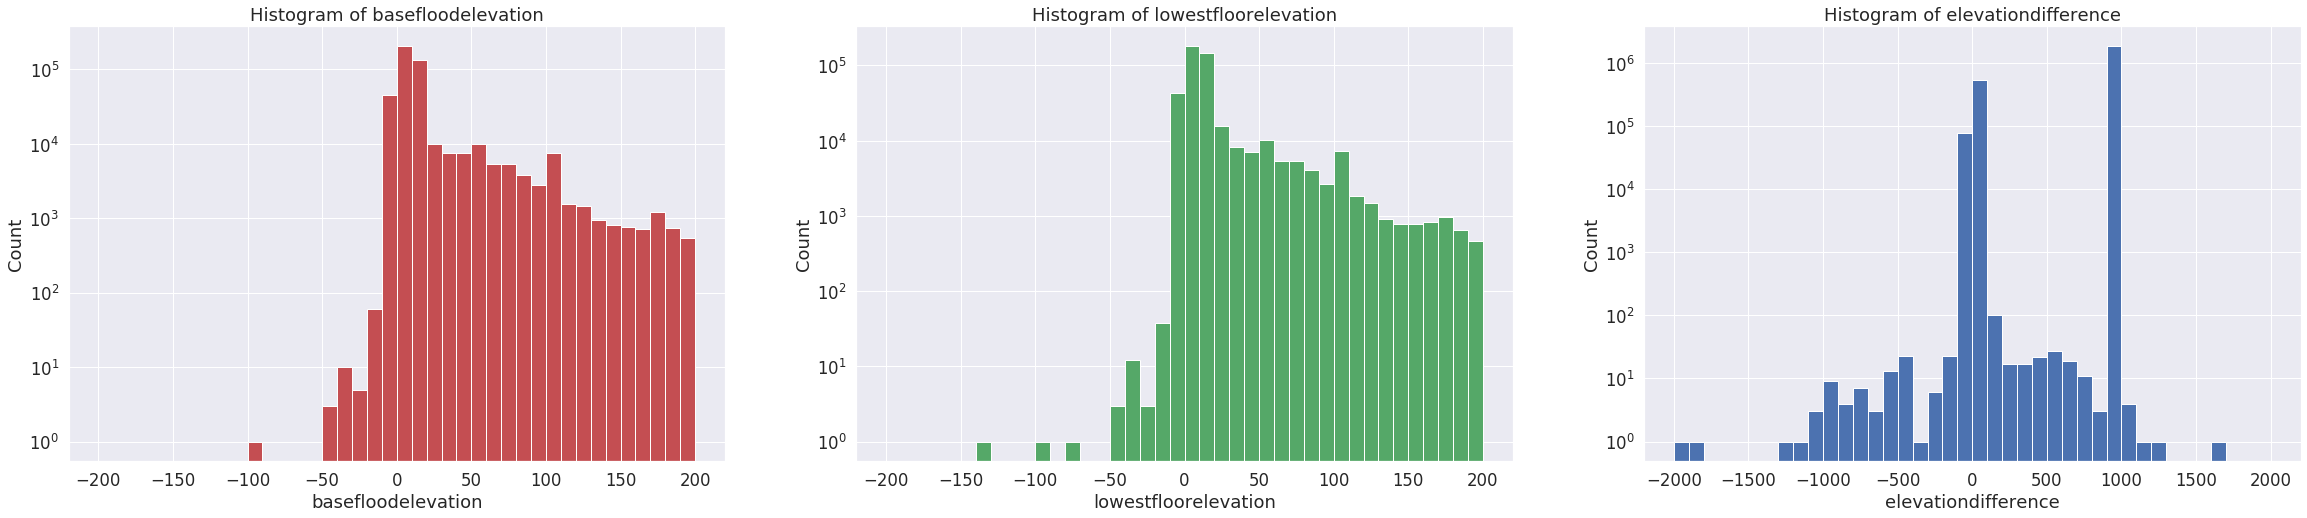

In [0]:
plt.figure(figsize=(40,8))
plt_col = ["basefloodelevation","lowestfloorelevation","elevationdifference"]
plt_range = [(-200,200),(-200,200),(-2000,2000)]
plt_clr = ['R','G','B']
cnt = 0
for col in plt_col:
  cnt +=1
  plt.subplot(1, 3, cnt)
  plt.hist(df_full[col],bins=40,range=plt_range[cnt-1], color=plt_clr[cnt-1], log = True)
  plt.xlabel(col)
  plt.ylabel("Count")
  plt.title("Histogram of "+col)
plt.show()

In [0]:
# Statistical description of elevation related columns
df_full_fix[plt_col].describe()

basefloodelevation  lowestfloorelevation  elevationdifference
count       483585.000000         475067.000000         2.432876e+06
mean            71.379503            148.299886         7.505251e+02
std            300.584516            980.145453         4.321228e+02
min          -6002.000000          -6002.000000        -1.987000e+03
25%              7.000000              6.500000         9.990000e+02
50%              9.000000             10.300000         9.990000e+02
75%             14.000000             17.800000         9.990000e+02
max           9998.000000          99999.900000         9.998000e+03



Lowestfloorelevation have outlier values of 99999 which is reset to a value of zero along with the basefloodelevation and elevation difference values

In [0]:
# fixing lowestfloorelevation where values is greater than 10000 (outlier)
cond = df_full_fix["lowestfloorelevation"] > 10000
df_full_fix.loc[cond,plt_col[0]] = df_full_fix.loc[cond,plt_col[0]].fillna(0)
df_full_fix.loc[cond,plt_col[1]] = 0
df_full_fix.loc[cond,plt_col[2]] = 0
df_full_fix[cond]

agriculturestructureindicator  ... locationofcontents_code
1550850                 Not_specified  ...                     3.0
1551032                 Not_specified  ...                     3.0
1551059                 Not_specified  ...                     3.0
1551113                 Not_specified  ...                     3.0
1551548                 Not_specified  ...                     3.0

[5 rows x 41 columns]

Elevation difference has no null values. However, most of the values seems to be defaulted to 999. 
1. I first fix reset those values to zero 
2. Then fix the baseflood elevation and lowestfloorelevation values
3. Recompute elevation difference 

In [0]:
# Step1: Fixing the default values of 999
df_full_fix.loc[df_full_fix["elevationdifference"] == 999,["elevationdifference"]] = 0

# Recompute elevation difference when both basefloodelevation and lowestfloorelevation are non null values

In [0]:
# Step2: Filling empty values of basefloodelevation and lowestfloorelevation
cond1 = df_full_fix["basefloodelevation"].isnull() & ~df_full_fix["lowestfloorelevation"].isnull()
cond2 = ~df_full_fix["basefloodelevation"].isnull() & df_full_fix["lowestfloorelevation"].isnull()
cond3 = df_full_fix["basefloodelevation"].isnull() & df_full_fix["lowestfloorelevation"].isnull()

df_full_fix.loc[cond1,"basefloodelevation"] = df_full_fix.loc[cond1,"basefloodelevation"].fillna(df_full_fix.loc[cond1,"lowestfloorelevation"] - df_full_fix.loc[cond1,"elevationdifference"])
df_full_fix.loc[cond2,"lowestfloorelevation"] = df_full_fix.loc[cond2,"lowestfloorelevation"].fillna(df_full_fix.loc[cond2,"basefloodelevation"] + df_full_fix.loc[cond2,"elevationdifference"])
df_full_fix.loc[cond3,"basefloodelevation"] = df_full_fix.loc[cond3,"basefloodelevation"].fillna(0)
df_full_fix.loc[cond3,"lowestfloorelevation"] = df_full_fix.loc[cond3,"lowestfloorelevation"].fillna(0)

In [0]:
# Step3: After fixing the basefloodelevation and lowestfloorelevation we recalculate the elevationdifference
df_full_fix['elevationdifference'] = df_full_fix['lowestfloorelevation'] - df_full_fix['basefloodelevation']

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


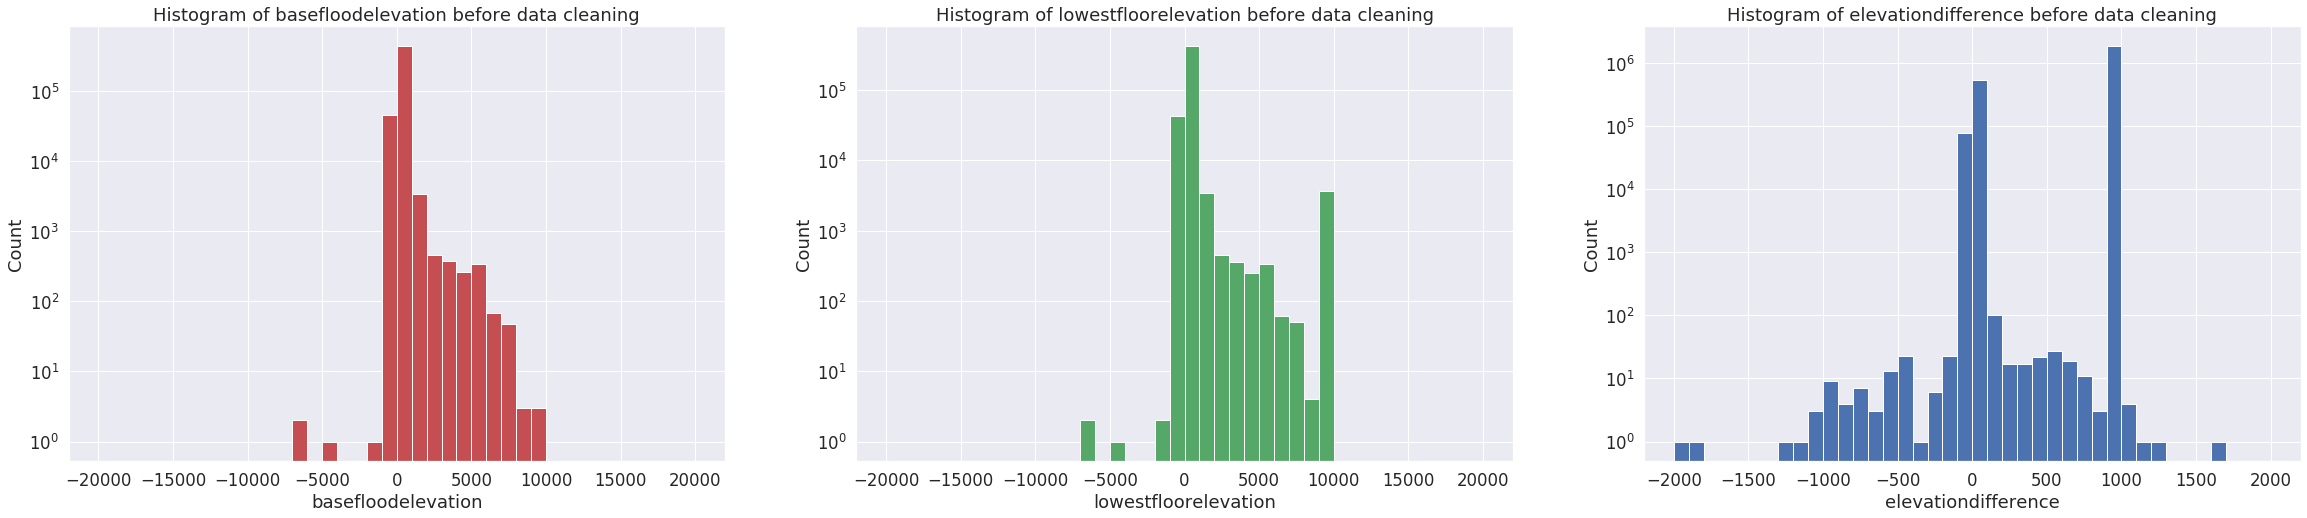

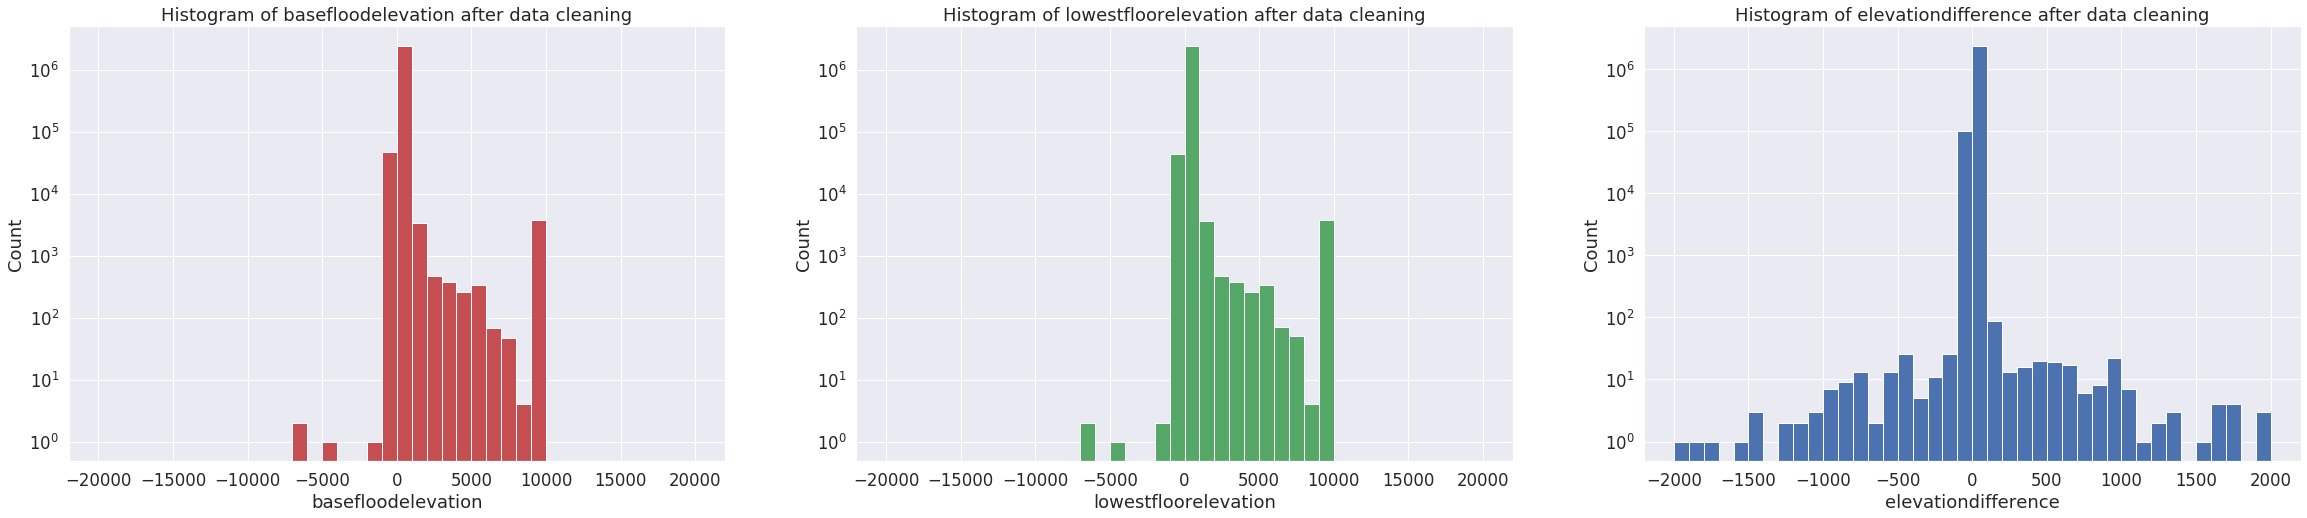

In [0]:
plt.figure(figsize=(40,8))
plt_col = ["basefloodelevation","lowestfloorelevation","elevationdifference"]
plt_range = [(-20000,20000),(-20000,20000),(-2000,2000)]
plt_clr = ['R','G','B']
cnt = 0
for col in plt_col:
  cnt +=1
  plt.subplot(1, 3, cnt)
  plt.hist(df_full[col],bins=40,range=plt_range[cnt-1], color=plt_clr[cnt-1], log = True)
  plt.xlabel(col)
  plt.ylabel("Count")
  plt.title("Histogram of "+col+" before data cleaning")
plt.show()

plt.figure(figsize=(40,8))
plt_col = ["basefloodelevation","lowestfloorelevation","elevationdifference"]
plt_range = [(-20000,20000),(-20000,20000),(-2000,2000)]
plt_clr = ['R','G','B']
cnt = 0
for col in plt_col:
  cnt +=1
  plt.subplot(1, 3, cnt)
  plt.hist(df_full_fix[col],bins=40,range=plt_range[cnt-1], color=plt_clr[cnt-1], log = True)
  plt.xlabel(col)
  plt.ylabel("Count")
  plt.title("Histogram of "+col+" after data cleaning")
plt.show()

In [0]:
# Coorelation among the elevation columns
df_full_fix[plt_col].corr()

basefloodelevation  ...  elevationdifference
basefloodelevation              1.000000  ...             0.000341
lowestfloorelevation            0.998251  ...             0.059453
elevationdifference             0.000341  ...             1.000000

[3 rows x 3 columns]

In [0]:
# Saving intermediate Cleanup
df_full_fix2 = df_full_fix.copy()

### lowestadjacentgrade

From the count statistics, we find the some outlier values of 99999. Also based on 

In [0]:
df_full_fix['lowestadjacentgrade'].describe()#.value_counts()

count    350719.000000
mean         75.457947
std         546.577338
min       -3411.000000
25%           3.200000
50%           6.700000
75%          12.900000
max       99999.100000
Name: lowestadjacentgrade, dtype: float64

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


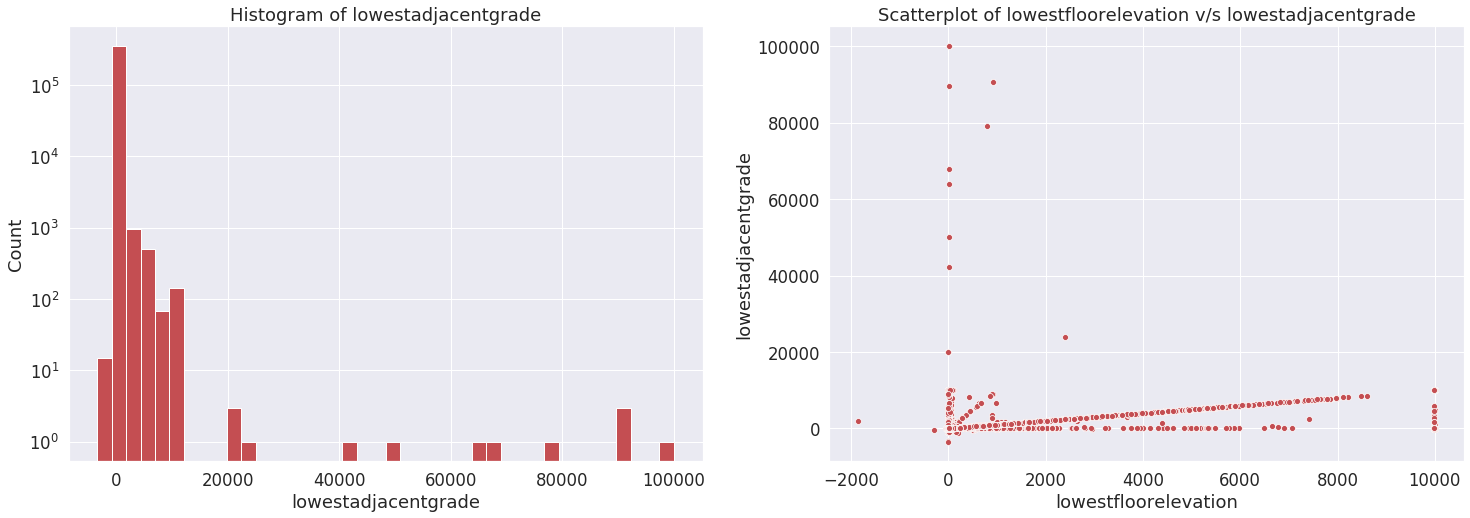

In [0]:
# Correlation of lowestadjacentgrade with lowestfloor elevation
plt.figure(figsize = (25,8))
plt.subplot(1, 2, 1)
plt.hist(df_full_fix['lowestadjacentgrade'],bins=40, color='R', log = True)
plt.xlabel('lowestadjacentgrade')
plt.ylabel("Count")
plt.title("Histogram of lowestadjacentgrade")

plt.subplot(1, 2, 2)
sns.scatterplot(x="lowestfloorelevation", y="lowestadjacentgrade", color='R', data=df_full_fix)
plt.xlabel('lowestfloorelevation')
plt.ylabel("lowestadjacentgrade")
plt.title("Scatterplot of lowestfloorelevation v/s lowestadjacentgrade")
plt.show()

In [0]:
# Correlation cross tab 
df_full_fix[['lowestadjacentgrade',	'lowestfloorelevation']].corr()

lowestadjacentgrade  lowestfloorelevation
lowestadjacentgrade              1.000000              0.471569
lowestfloorelevation             0.471569              1.000000

Dropping the lowestadjacentgrade field as there is some ambuguity regarding its definition

In [0]:
df_full_fix = df_full_fix.drop("lowestadjacentgrade",axis = 1)

In [0]:
null_percent[null_percent<=50]

basementenclosurecrawlspacetype        0.001521
policycount                            0.000000
countycode                             0.307907
crsdiscount                            0.000000
elevationdifference                    0.000000
censustract                            2.436951
latitude                               2.200523
longitude                              2.200523
numberoffloorsintheinsuredbuilding     0.683923
occupancytype                          0.029101
amountpaidonbuildingclaim              3.015608
amountpaidoncontentsclaim             29.590041
totalbuildinginsurancecoverage         0.000000
totalcontentsinsurancecoverage         0.000000
yearofloss                             0.000000
dtype: float64

### basementclosurecrawlspacetype

In [0]:
df_full_fix['basementenclosurecrawlspacetype'].value_counts()

0.0    1845119
2.0     264764
1.0     201173
3.0      81135
4.0      40648
Name: basementenclosurecrawlspacetype, dtype: int64

In [0]:
# Reseting missing values to zero
df_full_fix.loc[df_full_fix['basementenclosurecrawlspacetype'].isnull(),'basementenclosurecrawlspacetype'] = df_full_fix.loc[df_full_fix['basementenclosurecrawlspacetype'].isnull(),'basementenclosurecrawlspacetype'].fillna(0)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


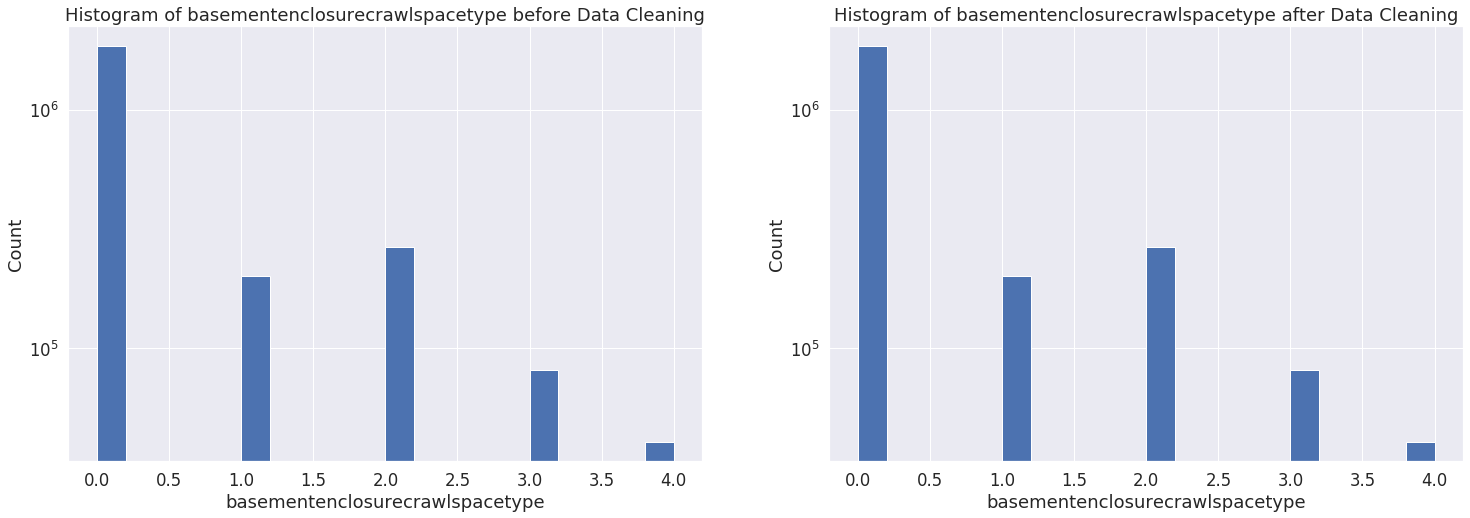

In [0]:
# Categorical plot 
plt.figure(figsize = (25,8))
plt.subplot(1, 2, 1)
plt.hist(df_full['basementenclosurecrawlspacetype'],bins=20, log = True)
plt.xlabel('basementenclosurecrawlspacetype')
plt.ylabel("Count")
plt.title("Histogram of basementenclosurecrawlspacetype before Data Cleaning")

plt.subplot(1, 2, 2)
plt.hist(df_full_fix['basementenclosurecrawlspacetype'],bins=20, log = True)
plt.xlabel('basementenclosurecrawlspacetype')
plt.ylabel("Count")
plt.title("Histogram of basementenclosurecrawlspacetype after Data Cleaning")
plt.show()

Pending data fixing
1. countycode
2. latitude:
3. longitude
4. censustract

### numberoffloorsintheinsuredbuilding and occupancytype
Remaining missing values from numberoffloorsintheinsuredbuilding and occupancytype are reset to 999

In [0]:
# Filling missing values with NAN: numberoffloorsintheinsuredbuilding
df_full_fix.loc[df_full_fix['numberoffloorsintheinsuredbuilding'].isnull(),'numberoffloorsintheinsuredbuilding'] = df_full_fix.loc[df_full_fix['numberoffloorsintheinsuredbuilding'].isnull(),'numberoffloorsintheinsuredbuilding'].fillna(999)

# Filling missing values with NAN: occupancytype
df_full_fix.loc[df_full_fix['occupancytype'].isnull(),'occupancytype'] = df_full_fix.loc[df_full_fix['occupancytype'].isnull(),'occupancytype'].fillna(999)

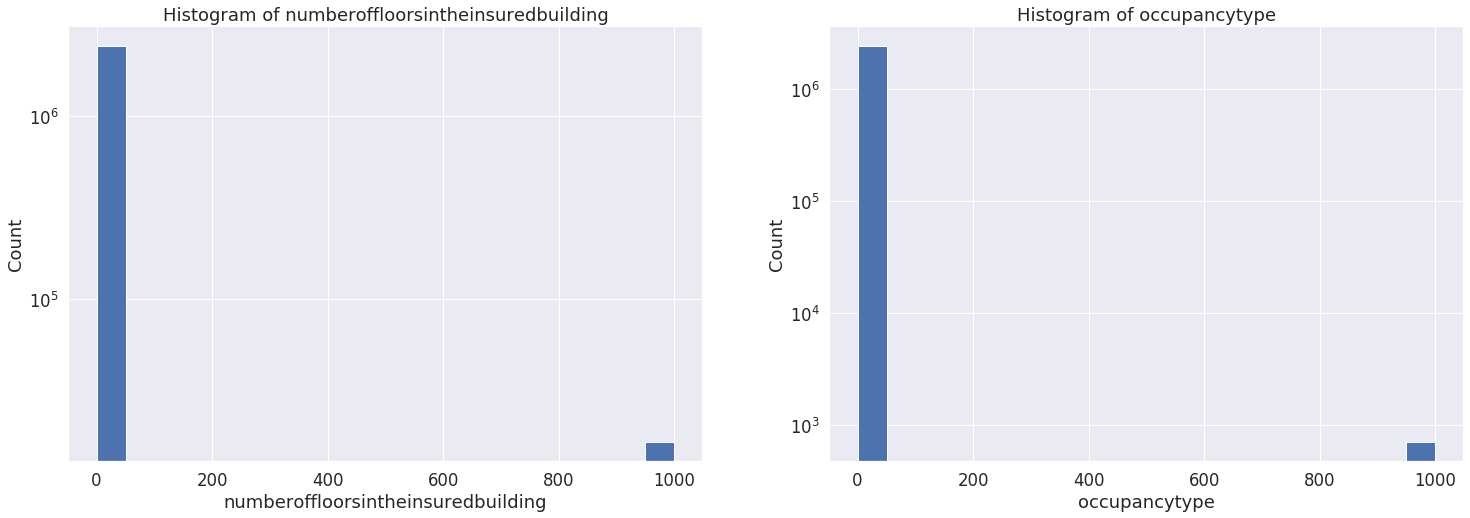

In [0]:
plt.figure(figsize = (25,8))
plt.subplot(1, 2, 1)
plt.hist(df_full_fix['numberoffloorsintheinsuredbuilding'],bins=20, log = True)
plt.xlabel('numberoffloorsintheinsuredbuilding')
plt.ylabel("Count")
plt.title("Histogram of numberoffloorsintheinsuredbuilding")

plt.subplot(1, 2, 2)
plt.hist(df_full_fix['occupancytype'],bins=20, log = True)
plt.xlabel('occupancytype')
plt.ylabel("Count")
plt.title("Histogram of occupancytype")
plt.show()

#Analyzing the target variables

---



---



From the dataset we assign the following two coloums to be our target variable for prediction
1. amountpaidonbuildingclaim: Amount paid by to the claimee in the event of flood for building damage
2. amountpaidoncontensclaim: Amount paid by the claimee in the event of flood for contents in the building.

The purpose of our modelling is to predict the estimate of the amount paid in these two categories separately. However, to proceed further we analyze the clean the data for missing or absurd values. However, the extreme and outlier values are preserved to maintain the variance.

Note that the feature of amountpaidonincreasedcostofcomplianceclaim is also available which can be used as a third targte variable. 

From statistics we find that some extreme values in amountpaidonbuilding claims for upto 10 million. Also note that we have some negative values in the two. From the metadata information, a negative vallue correspond to the claim that wasn't cashed and was reissued.

The histrogram distribution are highly skewed towards the lower end which also indicate that many entries are zero (or approximately close to zero). This is an important as we will use this to modifiy our regression modelling. 


In [0]:
# Statistics on target variable
tar_col = ['amountpaidonbuildingclaim',"amountpaidoncontentsclaim"]
df_full_fix[tar_col].describe()

amountpaidonbuildingclaim  amountpaidoncontentsclaim
count               2.359510e+06               1.712987e+06
mean                2.367499e+04               7.729023e+03
std                 5.278161e+04               2.280169e+04
min                -2.920705e+04              -8.484000e+03
25%                 1.085800e+02               0.000000e+00
50%                 4.818810e+03               2.290000e+02
75%                 2.402774e+04               5.830405e+03
max                 1.000000e+07               7.500000e+05

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


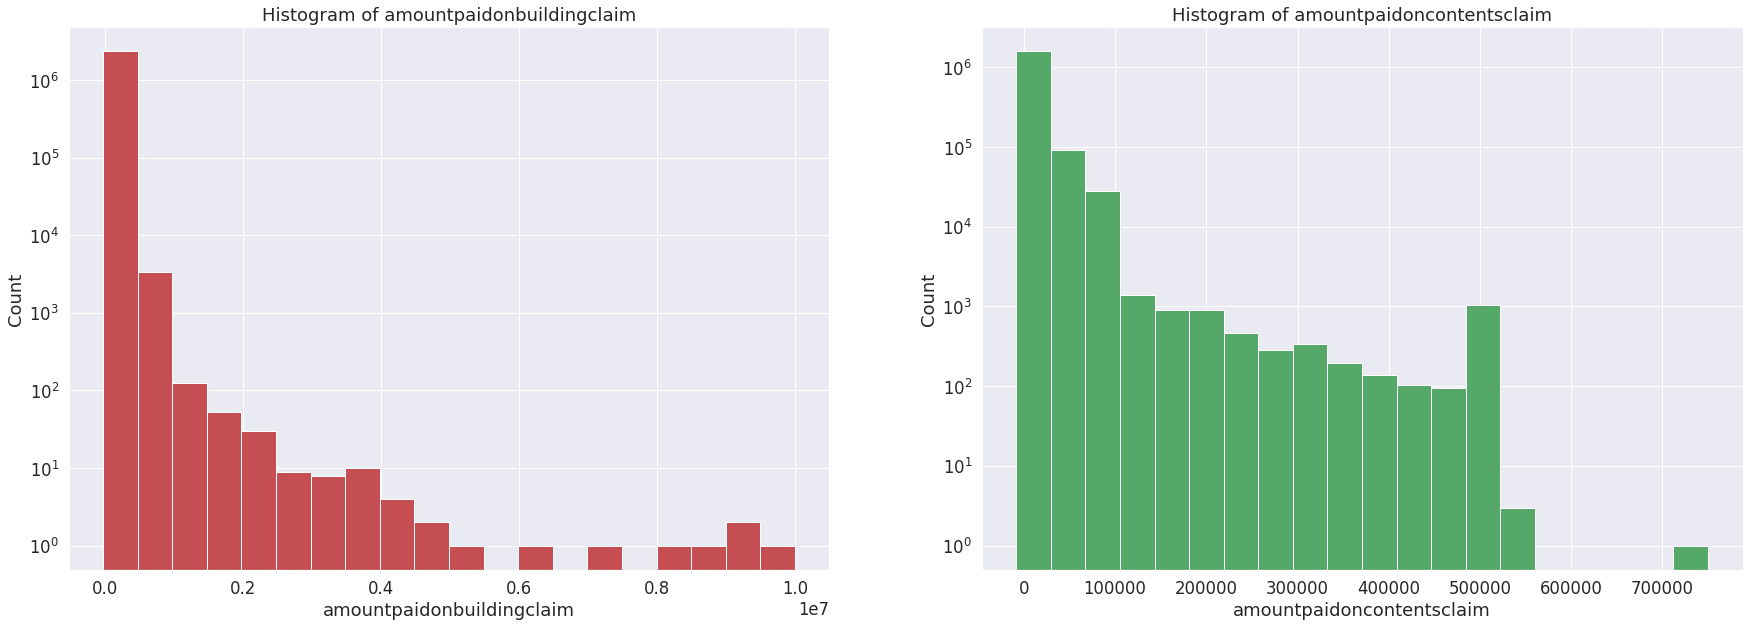

In [0]:
# Histrogram plots for two targte variables.
plt_col = ["amountpaidonbuildingclaim","amountpaidoncontentsclaim"]
#plt_range = [(-20000,20000),(-20000,20000),(-2000,2000)]
plt_clr = ['R','G']
cnt = 0
plt.figure(figsize = (30,10))
for col in plt_col:
  plt.subplot(1, 2, cnt+1)
  plt.hist(df_full_fix[col],bins=20, color = plt_clr[cnt], log = True)
  plt.xlabel(col)
  plt.ylabel("Count")
  plt.title("Histogram of "+col)
  cnt+=1
plt.show()

In [0]:
# Entries with negative values (15 reocrd in total)
df_full_fix[(df_full_fix['amountpaidonbuildingclaim']<0) | (df_full_fix['amountpaidoncontentsclaim']<0)]

agriculturestructureindicator  ... locationofcontents_code
77272                   Not_specified  ...                     1.0
219664                              N  ...                     5.0
543616                  Not_specified  ...                     3.0
556828                  Not_specified  ...                     3.0
690409                  Not_specified  ...                     5.0
736107                  Not_specified  ...                     5.0
1078317                 Not_specified  ...                     3.0
1217756                 Not_specified  ...                     4.0
1226492                 Not_specified  ...                     3.0
1226493                 Not_specified  ...                     3.0
1341091                 Not_specified  ...                     3.0
1341278                 Not_specified  ...                     2.0
1341279                 Not_specified  ...                     2.0
1512055                 Not_specified  ...                     3.0
1624052                 Not_specified  ...                     2.0

[15 rows x 40 columns]

In [0]:
# intotal there are 15 cases where amount paid is negative 
cond = (df_full_fix['amountpaidonbuildingclaim']<0) | (df_full_fix['amountpaidoncontentsclaim']<0)
df_full_fix = df_full_fix[~cond].reset_index()
df_full_fix.drop(['index'], axis = 1, inplace = True)

We estimate a direct correlation between amountpaid on the claims (target variable) with the total insurance coverage (input feature). Intuitively, in the event the total coverage carried is zero, the corresponding claim amount paid should also equate to zero. We use this principal to fillin some missing values on the amountpaidcontentclaims

In [0]:
# Also we find most nan values for amountpaidoncontentsclaim when totalcontentsinsurancecoverage equal 0
cond1 = (df_full_fix['totalbuildinginsurancecoverage'] == 0) & (df_full_fix['amountpaidonbuildingclaim'].isnull())
cond2 = (df_full_fix['totalcontentsinsurancecoverage'] == 0) & (df_full_fix['amountpaidoncontentsclaim'].isnull())
df_full_fix.loc[cond1,'amountpaidonbuildingclaim'] = df_full_fix.loc[cond1,'amountpaidonbuildingclaim'].fillna(0)
df_full_fix.loc[cond2,'amountpaidoncontentsclaim'] = df_full_fix.loc[cond2,'amountpaidoncontentsclaim'].fillna(0)

Null statistics after all data cleanup flow shows that we have removed most of the missing values in the dataset except for the four following columns
1. countycode
2. censustract
3. latitude
4. longitude

Since all of these are location related features, we avoid filling the missing values with statistically derived values. The intention here to avoid introducing estimated values of location.

These missing records can be dropped (2% of total entries) for data modelling.

In [0]:
# Count nulls statistics after all data cleanup combined
null_percent = 100*df_full_fix.isnull().sum()/df_full_fix.isnull().count()
null_percent

agriculturestructureindicator                  0.000000
asofdate                                       0.000000
basefloodelevation                             0.000000
basementenclosurecrawlspacetype                0.000000
reportedcity                                   0.000000
condominiumindicator                           0.000000
policycount                                    0.000000
countycode                                     0.307909
crsdiscount                                    0.000000
dateofloss                                     0.000000
elevatedbuildingindicator                      0.000000
elevationcertificateindicator                  0.000000
elevationdifference                            0.000000
censustract                                    2.436966
floodzone                                      0.000000
houseworship                                   0.000000
latitude                                       2.200537
locationofcontents                             0

In [0]:
# Data frame after all data cleaning
df_full_fix.head(10)

agriculturestructureindicator  ... locationofcontents_code
0                 Not_specified  ...                     1.0
1                 Not_specified  ...                     1.0
2                 Not_specified  ...                     1.0
3                 Not_specified  ...                     1.0
4                 Not_specified  ...                     1.0
5                 Not_specified  ...                     1.0
6                             N  ...                     1.0
7                 Not_specified  ...                     1.0
8                 Not_specified  ...                     2.0
9                 Not_specified  ...                     1.0

[10 rows x 40 columns]

# Bivariate Analysis

### Amount Paid versus Coverage


---


We visualize the relationship between the claim amount paid and the carried insurance coverage. Most of the distribution is the bottom half suggesting the amount paid is lower for majority of claims. However, some records suggest claims to exceed the insurance coverage. This is especially more prominent on the claims made on content side. This difference in distribution could potential impact the behaviour of the prediction models for each variable.

Also we observe a capped distribution in the content claims at 500000. This may also translate into loss of accuracy of prediction for entries with contentcoverage greater than 0.5 million as there are less number of datapoint to train the model.

Building claims, on the other side, has a better distribution with respect to coverages.

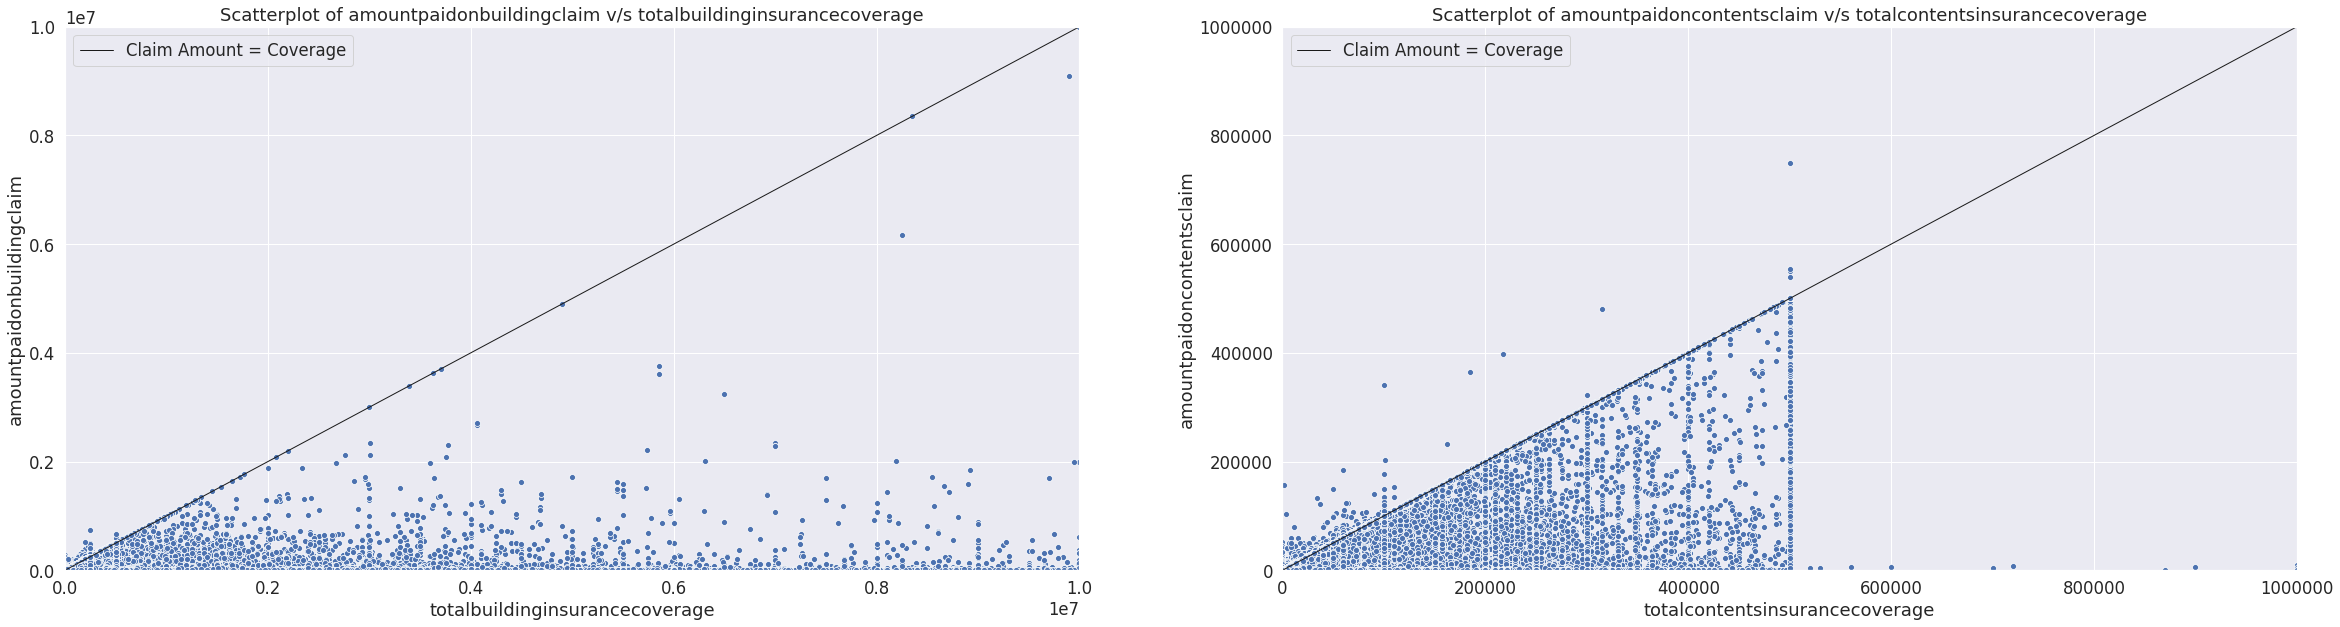

In [0]:
plt.figure(figsize = (40,10))
plt.subplot(1, 2, 1)
sns.scatterplot(x="totalbuildinginsurancecoverage", y="amountpaidonbuildingclaim", data=df_full_fix)
plt.plot([0, 10000000], [0, 10000000], color='k', linestyle='-', linewidth=1, label = 'Claim Amount = Coverage')
plt.xlabel('totalbuildinginsurancecoverage')
plt.ylabel("amountpaidonbuildingclaim")
plt.ylim(0, 10000000)
plt.xlim(0, 10000000)
plt.title("Scatterplot of amountpaidonbuildingclaim v/s totalbuildinginsurancecoverage")
plt.legend()

plt.subplot(1, 2, 2)
sns.scatterplot(x="totalcontentsinsurancecoverage", y="amountpaidoncontentsclaim", data=df_full_fix)
plt.plot([0, 10000000], [0, 10000000], color='k', linestyle='-', linewidth=1, label = 'Claim Amount = Coverage')
plt.xlabel('totalcontentsinsurancecoverage')
plt.ylabel("amountpaidoncontentsclaim")
plt.ylim(0, 1000000)
plt.xlim(0, 1000000)
plt.title("Scatterplot of amountpaidoncontentsclaim v/s totalcontentsinsurancecoverage")
plt.legend()

### Amount Paid versus Number of Floors

With respect to the numberoffloor insured, we observe overall similar average trend.

In [0]:
# Statistic for each group of floors insured
df_full_fix.groupby('numberoffloorsintheinsuredbuilding').describe()[plt_col]

amountpaidonbuildingclaim  ... amountpaidoncontentsclaim
                                                       count  ...                       max
numberoffloorsintheinsuredbuilding                            ...                          
1.0                                                1219537.0  ...                 554205.00
2.0                                                 763398.0  ...                 502584.48
3.0                                                 354491.0  ...                 750000.00
4.0                                                  42516.0  ...                 500000.00
5.0                                                  34686.0  ...                 200000.00
6.0                                                   1594.0  ...                  60000.00
999.0                                                16639.0  ...                  34000.00

[7 rows x 16 columns]

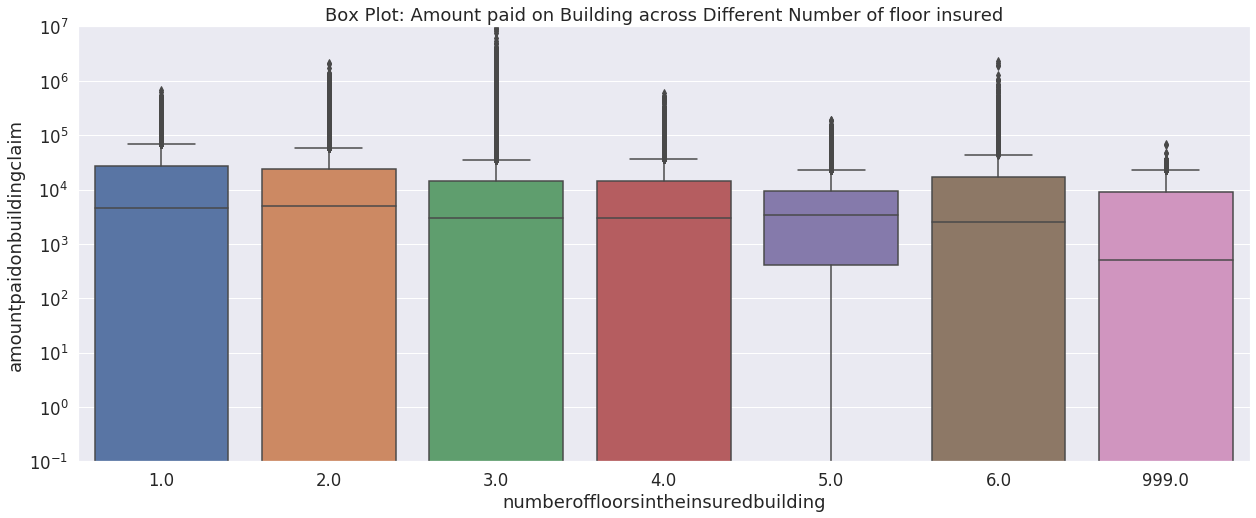

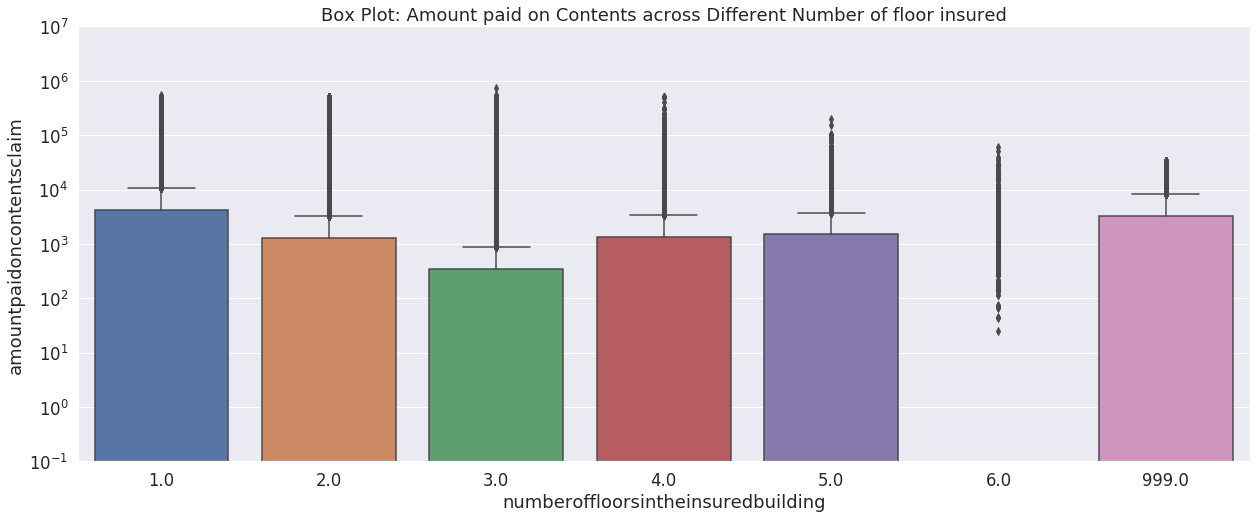

In [0]:
plt.figure(figsize = (21,8))
ax = sns.boxplot(y="amountpaidonbuildingclaim", x="numberoffloorsintheinsuredbuilding",data=df_full_fix)
plt.xlabel('numberoffloorsintheinsuredbuilding')
plt.ylabel('amountpaidonbuildingclaim')
plt.title('Box Plot: Amount paid on Building across Different Number of floor insured')
plt.ylim(0.1, 10000000)
ax.set(yscale="log")
plt.show()

plt.figure(figsize = (21,8))
ax = sns.boxplot(y="amountpaidoncontentsclaim", x="numberoffloorsintheinsuredbuilding",data=df_full_fix)
plt.xlabel('numberoffloorsintheinsuredbuilding')
plt.ylabel('amountpaidoncontentsclaim')
plt.title('Box Plot: Amount paid on Contents across Different Number of floor insured')
plt.ylim(0.1, 10000000)
ax.set(yscale="log")
plt.show()

### Amount Paid versus State

With respect to the state, we observe subtle differences in average claim amount . States with more datapoint like LA, TX, NJ,NJ etc have higher claim amounts.

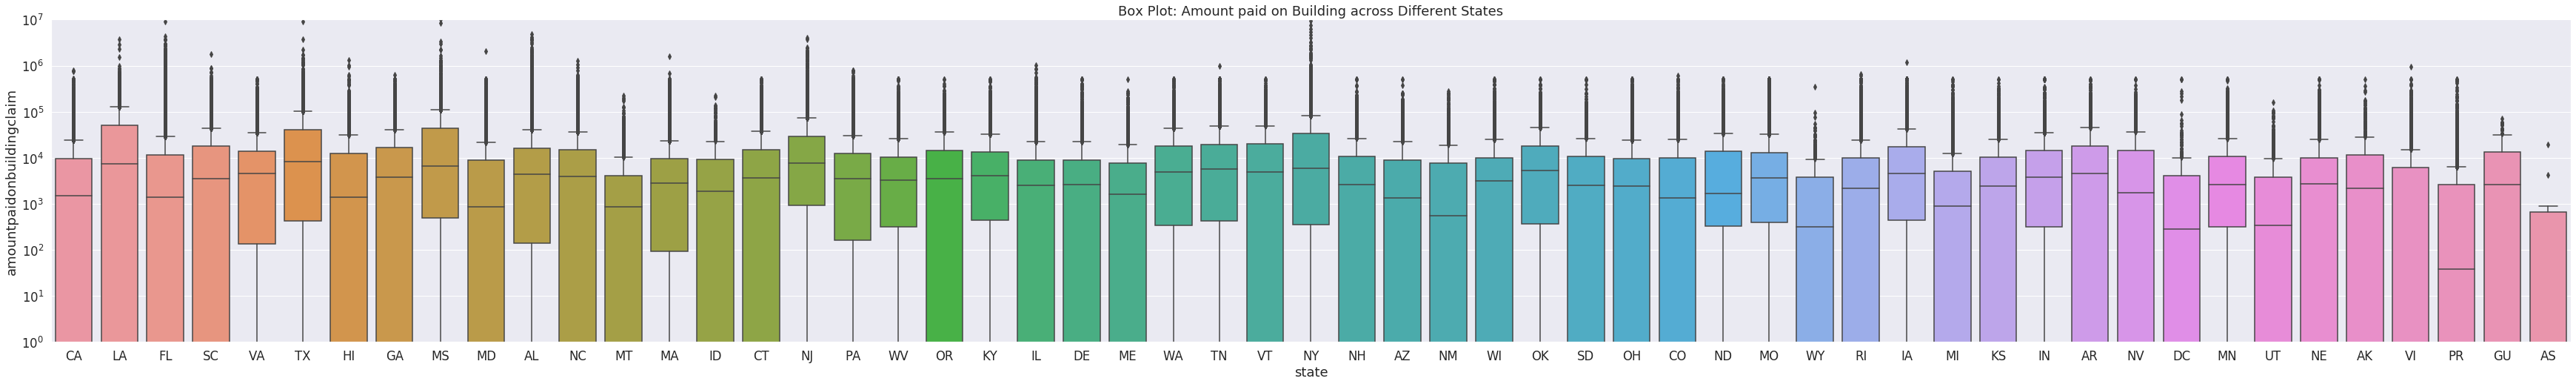

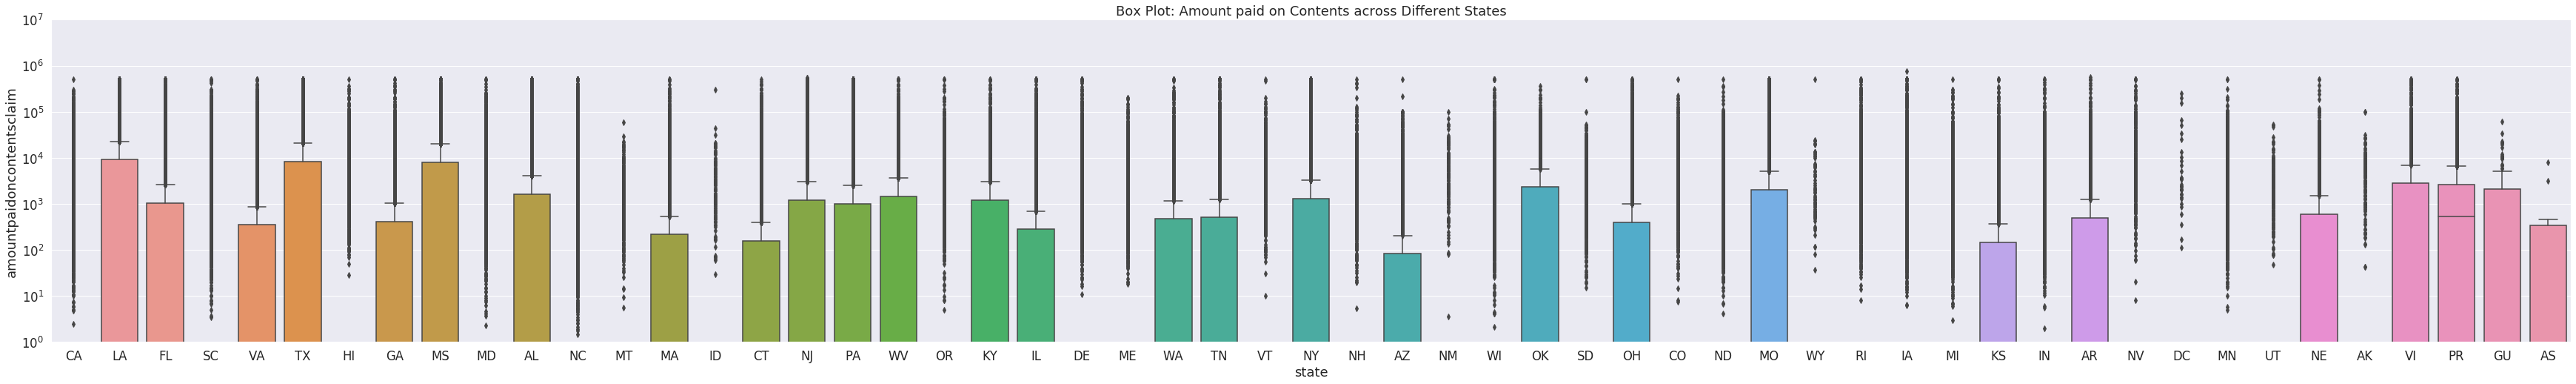

In [0]:
plt.figure(figsize = (61,8))
ax = sns.boxplot(y="amountpaidonbuildingclaim", x="state",data=df_full_fix)
plt.xlabel('state')
plt.ylabel('amountpaidonbuildingclaim')
plt.title('Box Plot: Amount paid on Building across Different States')
plt.ylim(1, 10000000)
ax.set(yscale="log")
plt.show()

plt.figure(figsize = (61,8))
ax = sns.boxplot(y="amountpaidoncontentsclaim", x="state",data=df_full_fix)
plt.xlabel('state')
plt.ylabel('amountpaidoncontentsclaim')
plt.title('Box Plot: Amount paid on Contents across Different States')
plt.ylim(1, 10000000)
ax.set(yscale="log")
plt.show()

#Supervised Learning: Beginning

With the data ready for modelling, the Linear regression modelling is select initially to establish a benchmark prediction.

For data prep the steps taken are :
1. Date type feature are converted to individual year month and day features respectively 
2. Drop the redundant columns like floodzone, locationofcontent, dateofloss etc. Also, for the current run, I drop the countycode, censustract, reportedzipcode which requires a more detailed analysis of values and cleanups. Reported city is also dropped to avoid introducing many dummy variables to the prediction  
3. the object type data is converted into dummy variable. 
4. Split the target and input features for the prediction 
5. Split datas to training and test datasets (20% of total record)

In [0]:
from sklearn.model_selection import train_test_split

# Dataset for Modelling
df_full_ml = df_full_fix.copy()

# To remove any records with null longitude/latitude information
cond = df_full_ml['longitude'].isnull()
df_full_ml = df_full_ml[~cond].reset_index()
df_full_ml.drop(['index'], axis = 1, inplace = True)

###### Step 1: Strip dates to year/month/day
# Month and day of loss
df_full_ml['monthofloss'] = pd.to_datetime(df_full_ml['dateofloss']).dt.month
df_full_ml['dayofloss'] = pd.to_datetime(df_full_ml['dateofloss']).dt.day
# Year, Month, day of construction
df_full_ml.loc[df_full_ml['originalconstructiondate'] == '1111-11-11','originalconstructiondate'] = df_full_ml.loc[df_full_ml['originalconstructiondate'] == '1111-11-11','originalnbdate']
df_full_ml['yearofconst'] = pd.to_datetime(df_full_ml['originalconstructiondate']).dt.year
df_full_ml['monthofconst'] = pd.to_datetime(df_full_ml['originalconstructiondate']).dt.month
df_full_ml['dayofconst'] = pd.to_datetime(df_full_ml['originalconstructiondate']).dt.day
# Year, Month, day of flood policy
df_full_ml['yearofnb'] = pd.to_datetime(df_full_ml['originalnbdate']).dt.year
df_full_ml['monthofnb'] = pd.to_datetime(df_full_ml['originalnbdate']).dt.month
df_full_ml['dayofnb'] = pd.to_datetime(df_full_ml['originalnbdate']).dt.day

###### Step 2: Dropping Columns to simplify the dataframe
drop_col= ['asofdate','reportedcity','countycode','reportedzipcode','censustract','floodzone','locationofcontents','dateofloss','originalconstructiondate','originalnbdate']
for col in drop_col:
  df_full_ml.drop(col,axis = 1, inplace = True)

###### Step 3: Getting the dummy varibles of categorical variables
obj_col = df_full_ml.columns[df_full_ml.dtypes == 'object']
nonobj_col = df_full_ml.columns[df_full_ml.dtypes != 'object']
# Combined dataset with continuous and categorical variables
df_full_ml = pd.concat([df_full_ml[nonobj_col],pd.get_dummies(df_full_ml[obj_col],drop_first= True)], axis=1)

###### Step 4: Split Target and Input Feature
Y1 = df_full_ml[~df_full_ml["amountpaidonbuildingclaim"].isnull()]["amountpaidonbuildingclaim"]
Y2 = df_full_ml[~df_full_ml["amountpaidoncontentsclaim"].isnull()]["amountpaidoncontentsclaim"]
X = df_full_ml[~df_full_ml["amountpaidonbuildingclaim"].isnull()].drop(["amountpaidonbuildingclaim",'amountpaidoncontentsclaim','amountpaidonincreasedcostofcomplianceclaim'], axis=1)

##### Step5: Split into test and train dataset
X1_train, X1_test, y1_train, y1_test = train_test_split(X, Y1, test_size = 0.2, random_state = 465)
print("The number of observations in training set is {} for amountpaidonbuildingclaim".format(X1_train.shape[0]))
print("The number of observations in test set is {} for amountpaidonbuildingclaim".format(X1_test.shape[0]))

X2_train, X2_test, y2_train, y2_test = train_test_split(X, Y2, test_size = 0.2, random_state = 465)
print("The number of observations in training set is {} for amountpaidoncontentsclaim".format(X2_train.shape[0]))
print("The number of observations in test set is {} for amountpaidoncontentsclaim".format(X2_test.shape[0]))

The number of observations in training set is 1903460 for amountpaidonbuildingclaim
The number of observations in test set is 475865 for amountpaidonbuildingclaim
The number of observations in training set is 1903460 for amountpaidoncontentsclaim
The number of observations in test set is 475865 for amountpaidoncontentsclaim


This gives us the opportunity to evalute the correlations among the features. Plotted below is the correlation heatmap of the numerical type features. From the observation we find some multicollinearity exists. Forexample, basementclosurecrawlsapcetype correlates well with latitude, obstruction type with yearofloss etc. Some correlation may also be introduced as missing values were filled using other feature as reference.

But in general, the interdependency levels are overall lower and we avoid trimming any variables in our modelling.

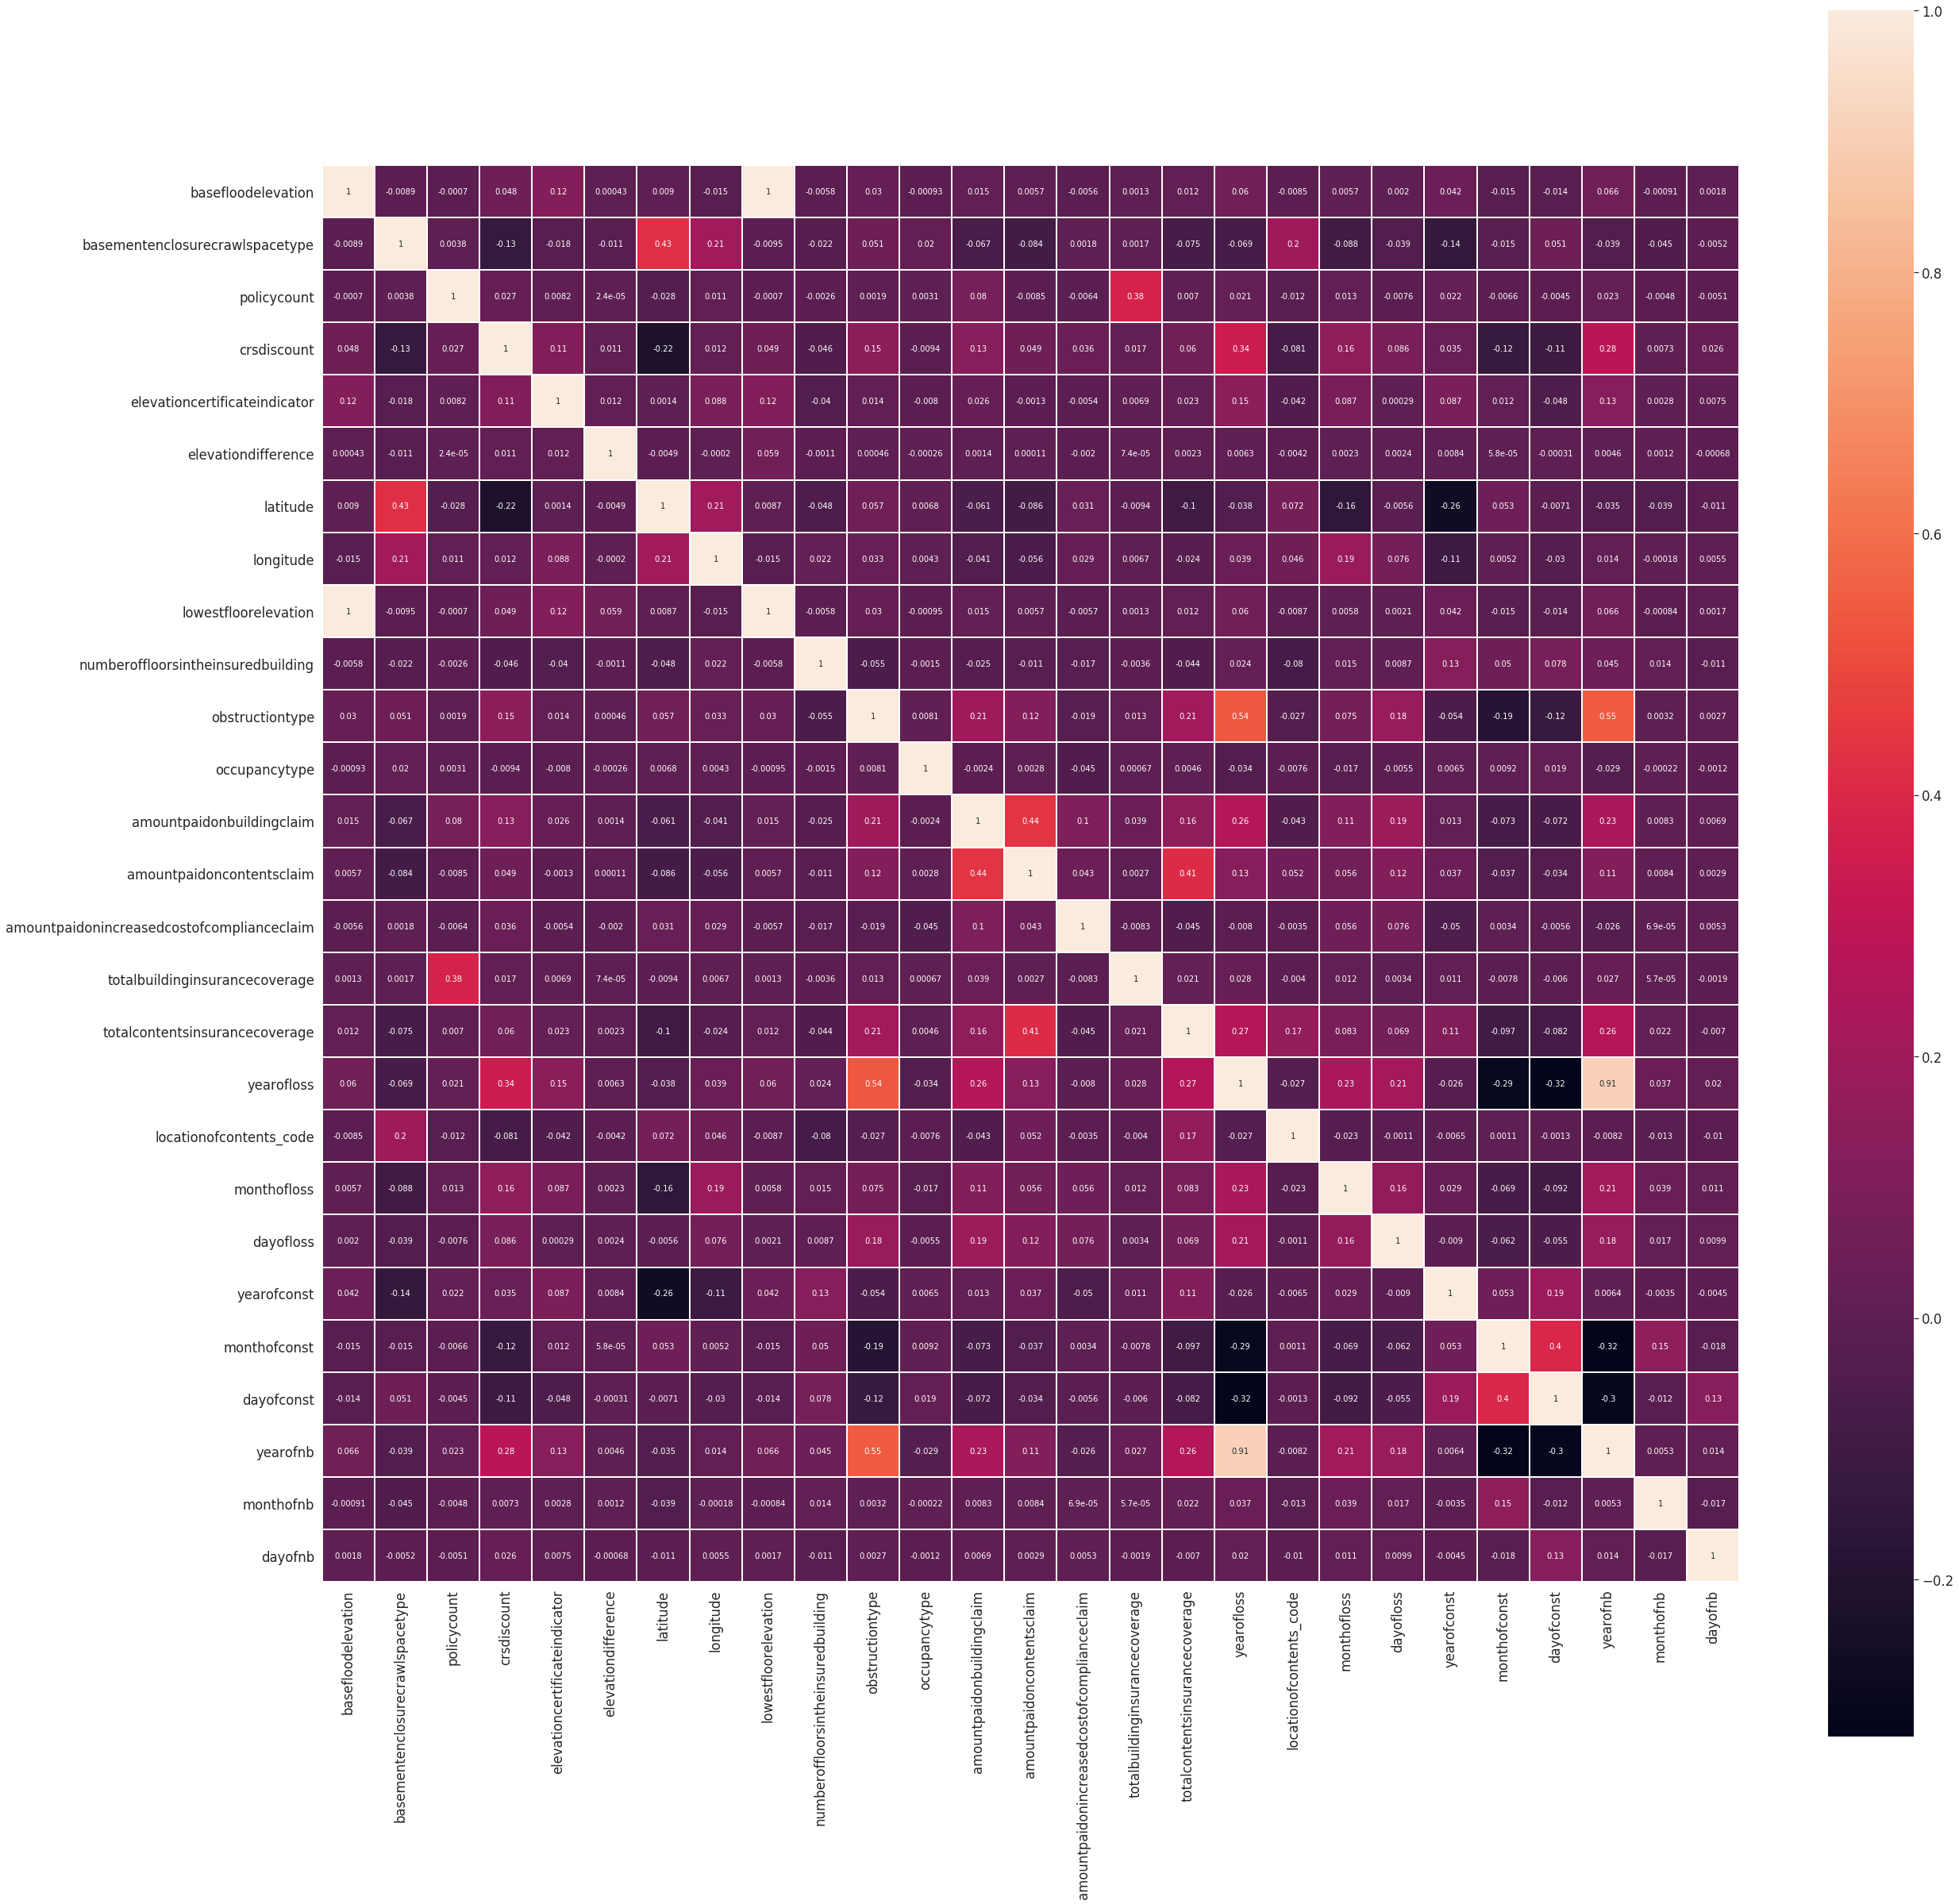

In [0]:
# Correlation Heat Map
corrmat = df_full_ml[nonobj_col].corr()
plt.figure(figsize=(40,40))
sns.heatmap(corrmat, square=True, annot=True, linewidths=1)

## Supervise Learning : Linear Regression Using all datapoints
For the first round we use all available records and run a blind test using Linear regression. The test and training dataset are split into 20:80 ratio.

Linear Regression model from statsmodels under default setting is used to fit on the training datasets and predicted on the test records. Both the target variable are modelled independently.
In our result, we observe our prediction error to be high with an R squared value of 26-28 % 


In [0]:
# Linear Rregression for amountpaidonbuildingclaim
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error

# We fit an OLS model using statsmodels
results = sm.OLS(y1_train, X1_train).fit()

# We print the summary results
print(results.summary())

y1_preds = results.predict(X1_test)
print("amountpaidonbuildingclaim: Mean absolute error of the prediction is: {}".format(mean_absolute_error(y1_test, y1_preds)))
print("amountpaidonbuildingclaim: Mean squared error of the prediction is: {}".format(mse(y1_test, y1_preds)))
print("amountpaidonbuildingclaim: Root mean squared error of the prediction is: {}".format(rmse(y1_test, y1_preds)))
print("amountpaidonbuildingclaim: Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y1_test - y1_preds) / y1_test)) * 100))

                                    OLS Regression Results                                    
Dep. Variable:     amountpaidonbuildingclaim   R-squared (uncentered):                   0.287
Model:                                   OLS   Adj. R-squared (uncentered):              0.287
Method:                        Least Squares   F-statistic:                              6377.
Date:                       Mon, 10 Feb 2020   Prob (F-statistic):                        0.00
Time:                               05:13:49   Log-Likelihood:                     -2.3249e+07
No. Observations:                    1903460   AIC:                                  4.650e+07
Df Residuals:                        1903340   BIC:                                  4.650e+07
Df Model:                                120                                                  
Covariance Type:                   nonrobust                                                  
                                                  

In [0]:
# Linear Rregression for amountpaidoncontentclaim
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error

# We fit an OLS model using statsmodels
results = sm.OLS(y2_train, X2_train).fit()

# We print the summary results
print(results.summary())

y2_preds = results.predict(X2_test)
print("amountpaidoncontentsclaim: Mean absolute error of the prediction is: {}".format(mean_absolute_error(y2_test, y2_preds)))
print("amountpaidoncontentsclaim: Mean squared error of the prediction is: {}".format(mse(y2_test, y2_preds)))
print("amountpaidoncontentsclaim: Root mean squared error of the prediction is: {}".format(rmse(y2_test, y2_preds)))
print("amountpaidoncontentsclaim: Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y2_test - y2_preds) / y2_test)) * 100))

                                    OLS Regression Results                                    
Dep. Variable:     amountpaidoncontentsclaim   R-squared (uncentered):                   0.268
Model:                                   OLS   Adj. R-squared (uncentered):              0.268
Method:                        Least Squares   F-statistic:                              5809.
Date:                       Mon, 10 Feb 2020   Prob (F-statistic):                        0.00
Time:                               05:15:18   Log-Likelihood:                     -2.1294e+07
No. Observations:                    1903460   AIC:                                  4.259e+07
Df Residuals:                        1903340   BIC:                                  4.259e+07
Df Model:                                120                                                  
Covariance Type:                   nonrobust                                                  
                                                  

In [0]:
# Predicting the results on training dataset
y1_preds_train = results.predict(X1_train)
y2_preds_train = results.predict(X2_train)

In [0]:
# Function to plot the scatterplot of prediction v/s data 
def plot_result(x1,y1,lim1,x2,y2,lim2,title):
  plt.figure(figsize = (30,10))
  plt.subplot(1, 2, 1)
  plt.plot(x1, y1,'o')
  plt.plot([0, lim1], [0, lim1], color='r', linestyle='--', linewidth=2, label = 'prediction = data')
  plt.ylim(0, lim1)
  plt.xlim(0, lim1)
  plt.xlabel('Target')
  plt.ylabel('Prediction')
  plt.title(title[0])
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x2, y2,'o')
  plt.plot([0, lim2], [0, lim2], color='r', linestyle='--', linewidth=2, label = 'prediction = data')
  plt.ylim(0, lim2)
  plt.xlim(0, lim2)
  plt.xlabel('Target')
  plt.ylabel('Prediction')
  plt.title(title[1])
  plt.legend()
  plt.show()

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


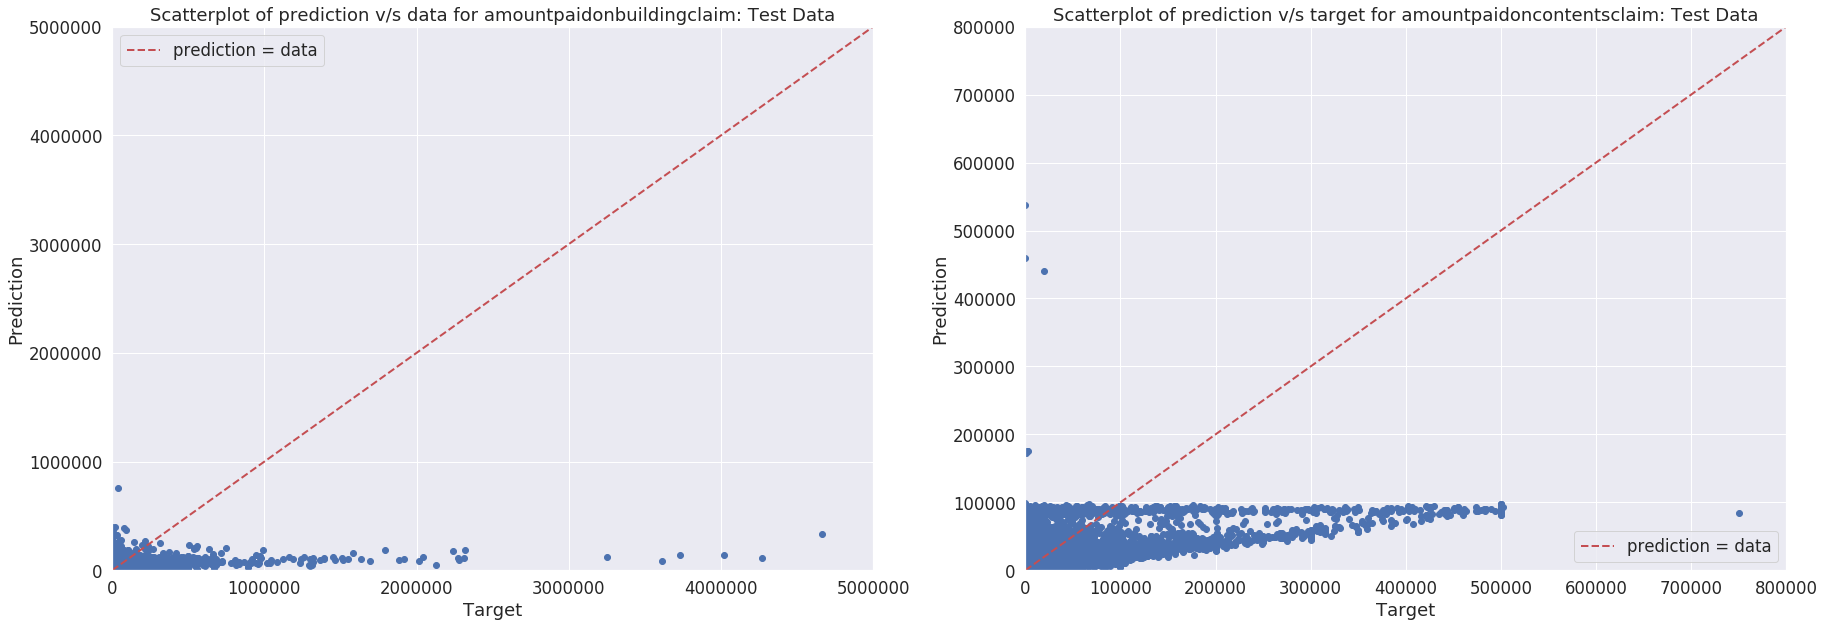

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


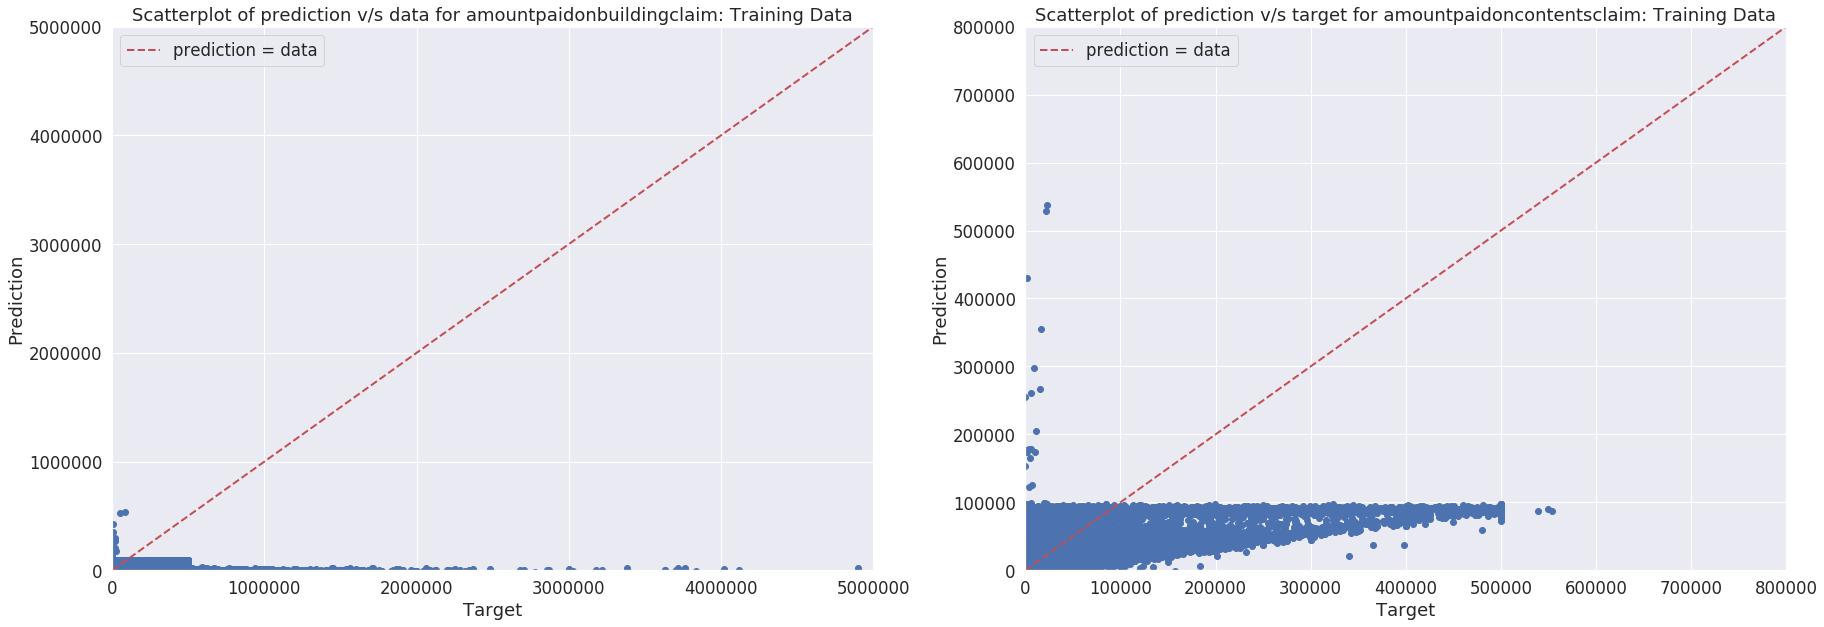

In [0]:
# Analysis of Prediction v/d Target 
test_title = ["Scatterplot of prediction v/s data for amountpaidonbuildingclaim: Test Data","Scatterplot of prediction v/s target for amountpaidoncontentsclaim: Test Data"]
train_title = ["Scatterplot of prediction v/s data for amountpaidonbuildingclaim: Training Data","Scatterplot of prediction v/s target for amountpaidoncontentsclaim: Training Data"]
plot_result(y1_test, y1_preds,5000000,y2_test,y2_preds, 800000, test_title)
plot_result(y1_train, y1_preds_train,5000000,y2_train,y2_preds_train, 800000, train_title)

## Supervise Learning : Linear Regression for each individual states

Previous, we observed that our datapoints are highly concentrated towards certain states. When running all states at once we observe that our prediciton are highly inaccurate. We now run our modelling on each state basis, especially for state with higher datapoint. In our example we will start with LA.  

In [0]:
# Dataset for Modelling
df_full_ml = df_full_fix.copy()

# To remove any records with null longitude/latitude information
cond = df_full_ml['longitude'].isnull()
df_full_ml = df_full_ml[~cond].reset_index()
df_full_ml.drop(['index'], axis = 1, inplace = True)

# Selecting on LA state
cond = (df_full_ml['state'] == 'LA')
df_full_ml = df_full_ml[cond].reset_index()
df_full_ml.drop(['index'], axis = 1, inplace = True)

###### Step 1: Strip dates to year/month/day
# Month and day of loss
df_full_ml['monthofloss'] = pd.to_datetime(df_full_ml['dateofloss']).dt.month
df_full_ml['dayofloss'] = pd.to_datetime(df_full_ml['dateofloss']).dt.day
# Year, Month, day of construction
df_full_ml.loc[df_full_ml['originalconstructiondate'] == '1111-11-11','originalconstructiondate'] = df_full_ml.loc[df_full_ml['originalconstructiondate'] == '1111-11-11','originalnbdate']
df_full_ml['yearofconst'] = pd.to_datetime(df_full_ml['originalconstructiondate']).dt.year
df_full_ml['monthofconst'] = pd.to_datetime(df_full_ml['originalconstructiondate']).dt.month
df_full_ml['dayofconst'] = pd.to_datetime(df_full_ml['originalconstructiondate']).dt.day
# Year, Month, day of flood policy
df_full_ml['yearofnb'] = pd.to_datetime(df_full_ml['originalnbdate']).dt.year
df_full_ml['monthofnb'] = pd.to_datetime(df_full_ml['originalnbdate']).dt.month
df_full_ml['dayofnb'] = pd.to_datetime(df_full_ml['originalnbdate']).dt.day

###### Step 2: Dropping Columns to simplify the dataframe
drop_col= ['asofdate','state','reportedcity','countycode','reportedzipcode','censustract','floodzone','locationofcontents','dateofloss','originalconstructiondate','originalnbdate']
for col in drop_col:
  df_full_ml.drop(col,axis = 1, inplace = True)

###### Step 3: Getting the dummy varibles of categorical variables
obj_col = df_full_ml.columns[df_full_ml.dtypes == 'object']
nonobj_col = df_full_ml.columns[df_full_ml.dtypes != 'object']
# Combined dataset with continuous and categorical variables
df_full_ml = pd.concat([df_full_ml[nonobj_col],pd.get_dummies(df_full_ml[obj_col],drop_first= True)], axis=1)

###### Step 4: Split Target and Input Feature
Y1 = df_full_ml[~df_full_ml["amountpaidonbuildingclaim"].isnull()]["amountpaidonbuildingclaim"]
Y2 = df_full_ml[~df_full_ml["amountpaidoncontentsclaim"].isnull()]["amountpaidoncontentsclaim"]
X = df_full_ml[~df_full_ml["amountpaidonbuildingclaim"].isnull()].drop(["amountpaidonbuildingclaim",'amountpaidoncontentsclaim','amountpaidonincreasedcostofcomplianceclaim'], axis=1)

##### Step5: Split into test and train dataset
X1_train, X1_test, y1_train, y1_test = train_test_split(X, Y1, test_size = 0.2, random_state = 465)
print("The number of observations in training set is {} for amountpaidonbuildingclaim".format(X1_train.shape[0]))
print("The number of observations in test set is {} for amountpaidonbuildingclaim".format(X1_test.shape[0]))

X2_train, X2_test, y2_train, y2_test = train_test_split(X, Y2, test_size = 0.2, random_state = 465)
print("The number of observations in training set is {} for amountpaidoncontentsclaim".format(X2_train.shape[0]))
print("The number of observations in test set is {} for amountpaidoncontentsclaim".format(X2_test.shape[0]))

The number of observations in training set is 359780 for amountpaidonbuildingclaim
The number of observations in test set is 89945 for amountpaidonbuildingclaim
The number of observations in training set is 359780 for amountpaidoncontentsclaim
The number of observations in test set is 89945 for amountpaidoncontentsclaim


In [0]:
# Linear Rregression for amountpaidonbuildingclaim
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error

# We fit an OLS model using statsmodels
results = sm.OLS(y1_train, X1_train).fit()

# We print the summary results
print("amountpaidonbuildingclaim: R squared value of the prediction is: {}".format(results.rsquared))

# Predicting the results on test dataset
y1_preds = results.predict(X1_test)

# Predicting the results on training dataset
y1_preds_train = results.predict(X1_train)
print("-----Test set statistics-----")
print("amountpaidonbuildingclaim: Mean absolute error of the prediction is: {}".format(mean_absolute_error(y1_test, y1_preds)))
print("amountpaidonbuildingclaim: Mean squared error of the prediction is: {}".format(mse(y1_test, y1_preds)))
print("amountpaidonbuildingclaim: Root mean squared error of the prediction is: {}".format(rmse(y1_test, y1_preds)))
print("amountpaidonbuildingclaim: Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y1_test - y1_preds) / y1_test)) * 100))

amountpaidonbuildingclaim: R squared value of the prediction is: 0.44165043053537256
-----Test set statistics-----
amountpaidonbuildingclaim: Mean absolute error of the prediction is: 31490.701190007487
amountpaidonbuildingclaim: Mean squared error of the prediction is: 2305272439.9983344
amountpaidonbuildingclaim: Root mean squared error of the prediction is: 48013.25275377971
amountpaidonbuildingclaim: Mean absolute percentage error of the prediction is: inf


In [0]:
# Linear Rregression for amountpaidoncontentclaim
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error

# We fit an OLS model using statsmodels
results = sm.OLS(y2_train, X2_train).fit()

# We print the summary results
print("amountpaidoncontentsclaim: R squared value of the prediction is: {}".format(results.rsquared))

# Predicting the results on test dataset
y2_preds = results.predict(X2_test)

# Predicting the results on training dataset
y2_preds_train = results.predict(X2_train)
print("-----Test set statistics-----")
print("amountpaidoncontentsclaim: Mean absolute error of the prediction is: {}".format(mean_absolute_error(y2_test, y2_preds)))
print("amountpaidoncontentsclaim: Mean squared error of the prediction is: {}".format(mse(y2_test, y2_preds)))
print("amountpaidoncontentsclaim: Root mean squared error of the prediction is: {}".format(rmse(y2_test, y2_preds)))
print("amountpaidoncontentsclaim: Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y2_test - y2_preds) / y2_test)) * 100))

amountpaidoncontentsclaim: R squared value of the prediction is: 0.36487858966330955
-----Test set statistics-----
amountpaidoncontentsclaim: Mean absolute error of the prediction is: 9719.267432701185
amountpaidoncontentsclaim: Mean squared error of the prediction is: 328829126.9502224
amountpaidoncontentsclaim: Root mean squared error of the prediction is: 18133.646267373322
amountpaidoncontentsclaim: Mean absolute percentage error of the prediction is: inf


From the R squared values, we observed that our prediction accuracy has increase by almost 10 to 15% on each individual state basis.

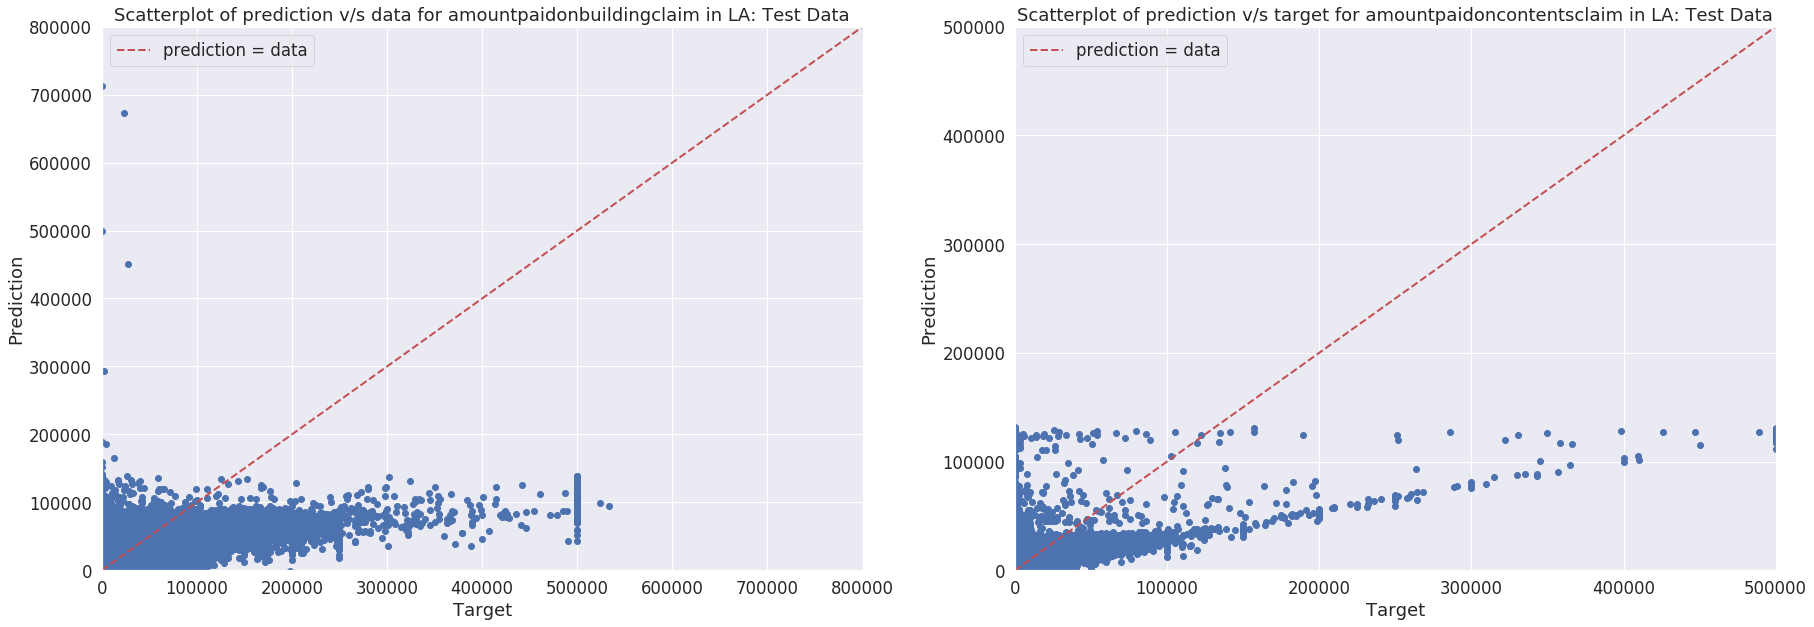

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


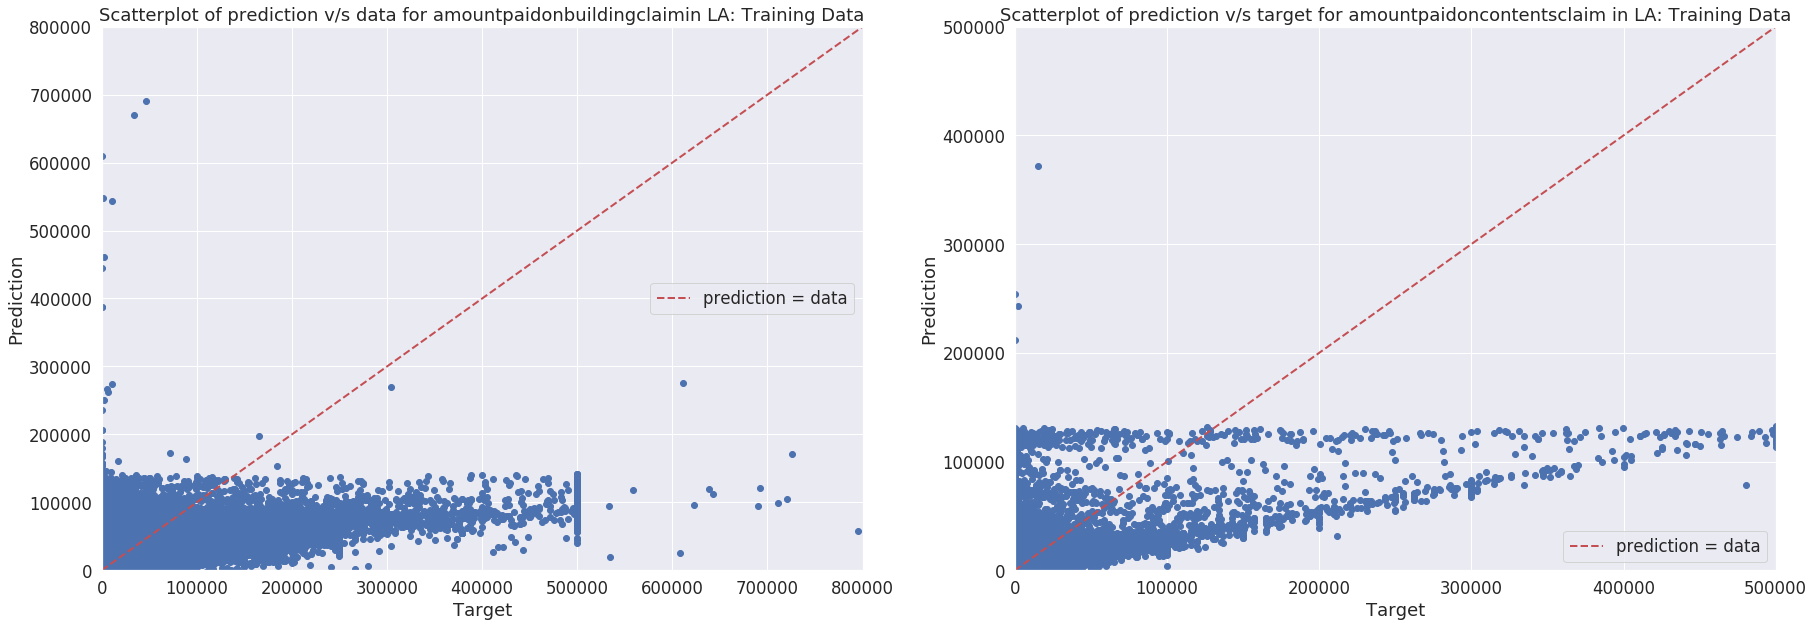

In [0]:
# Analysis of Prediction v/s Target 
test_title = ["Scatterplot of prediction v/s data for amountpaidonbuildingclaim in LA: Test Data","Scatterplot of prediction v/s target for amountpaidoncontentsclaim in LA: Test Data"]
train_title = ["Scatterplot of prediction v/s data for amountpaidonbuildingclaimin LA: Training Data","Scatterplot of prediction v/s target for amountpaidoncontentsclaim in LA: Training Data"]
plot_result(y1_test, y1_preds,800000,y2_test,y2_preds, 500000, test_title)
plot_result(y1_train, y1_preds_train,800000,y2_train,y2_preds_train, 500000, train_title)

## Supervise Learning : Linear Regression for each individual states with non zero amount claims

We also established that majority on the amount claims are less that the insurance coverage. Infact, the count of claim with zero amount paid is very high. Hence we further try to refine our prediction by modelling on the non zero amount claims alone.

In [0]:
# Dataset for Modelling
df_full_ml = df_full_fix.copy()

# To remove any records with null longitude/latitude information
cond = df_full_ml['longitude'].isnull()
df_full_ml = df_full_ml[~cond].reset_index()
df_full_ml.drop(['index'], axis = 1, inplace = True)

# Selecting on LA state
cond = (df_full_ml['state'] == 'LA')
df_full_ml = df_full_ml[cond].reset_index()
df_full_ml.drop(['index'], axis = 1, inplace = True)

# Defining the ratio of amount paid with respect to total coverage
df_full_ml['ratio1'] =  100*df_full_ml["amountpaidonbuildingclaim"]/(1+df_full_ml['totalbuildinginsurancecoverage'])
df_full_ml['ratio2'] =  100*df_full_ml["amountpaidoncontentsclaim"]/(1+df_full_ml['totalcontentsinsurancecoverage'])

# Removing ratio less than 1 (we classify them as denial of claim)
cond1 = (df_full_ml['ratio1'] <1 | df_full_ml["amountpaidonbuildingclaim"].isnull())
cond2 = (df_full_ml['ratio2'] <1 | df_full_ml["amountpaidoncontentsclaim"].isnull())

###### Step 1: Strip dates to year/month/day
# Month and day of loss
df_full_ml['monthofloss'] = pd.to_datetime(df_full_ml['dateofloss']).dt.month
df_full_ml['dayofloss'] = pd.to_datetime(df_full_ml['dateofloss']).dt.day
# Year, Month, day of construction
df_full_ml.loc[df_full_ml['originalconstructiondate'] == '1111-11-11','originalconstructiondate'] = df_full_ml.loc[df_full_ml['originalconstructiondate'] == '1111-11-11','originalnbdate']
df_full_ml['yearofconst'] = pd.to_datetime(df_full_ml['originalconstructiondate']).dt.year
df_full_ml['monthofconst'] = pd.to_datetime(df_full_ml['originalconstructiondate']).dt.month
df_full_ml['dayofconst'] = pd.to_datetime(df_full_ml['originalconstructiondate']).dt.day
# Year, Month, day of flood policy
df_full_ml['yearofnb'] = pd.to_datetime(df_full_ml['originalnbdate']).dt.year
df_full_ml['monthofnb'] = pd.to_datetime(df_full_ml['originalnbdate']).dt.month
df_full_ml['dayofnb'] = pd.to_datetime(df_full_ml['originalnbdate']).dt.day

###### Step 2: Dropping Columns to simplify the dataframe
drop_col= ['asofdate','state','reportedcity','countycode','reportedzipcode','censustract','floodzone','locationofcontents','dateofloss','originalconstructiondate','originalnbdate']
for col in drop_col:
  df_full_ml.drop(col,axis = 1, inplace = True)

###### Step 3: Getting the dummy varibles of categorical variables
obj_col = df_full_ml.columns[df_full_ml.dtypes == 'object']
nonobj_col = df_full_ml.columns[df_full_ml.dtypes != 'object']
# Combined dataset with continuous and categorical variables
df_full_ml = pd.concat([df_full_ml[nonobj_col],pd.get_dummies(df_full_ml[obj_col],drop_first= True)], axis=1)

###### Step 4: Split Target and Input Feature
Y1 = df_full_ml[~cond1]["amountpaidonbuildingclaim"]
Y2 = df_full_ml[~cond2]["amountpaidoncontentsclaim"]
X1 = df_full_ml[~cond1].drop(["amountpaidonbuildingclaim",'amountpaidoncontentsclaim','amountpaidonincreasedcostofcomplianceclaim','ratio1','ratio2'], axis=1)
X2 = df_full_ml[~cond2].drop(["amountpaidonbuildingclaim",'amountpaidoncontentsclaim','amountpaidonincreasedcostofcomplianceclaim','ratio1','ratio2'], axis=1)

##### Step5: Split into test and train dataset
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size = 0.2, random_state = 465)
print("The number of observations in training set is {} for amountpaidonbuildingclaim".format(X1_train.shape[0]))
print("The number of observations in test set is {} for amountpaidonbuildingclaim".format(X1_test.shape[0]))

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2, test_size = 0.2, random_state = 465)
print("The number of observations in training set is {} for amountpaidoncontentsclaim".format(X2_train.shape[0]))
print("The number of observations in test set is {} for amountpaidoncontentsclaim".format(X2_test.shape[0]))

The number of observations in training set is 257142 for amountpaidonbuildingclaim
The number of observations in test set is 64286 for amountpaidonbuildingclaim
The number of observations in training set is 172047 for amountpaidoncontentsclaim
The number of observations in test set is 43012 for amountpaidoncontentsclaim


In [0]:
# Linear Regression for amountpaidonbuildingclaim
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error

# We fit an OLS model using statsmodels
results = sm.OLS(y1_train, X1_train).fit()

# We print the summary results
print("amountpaidonbuildingclaim: R squared value of the prediction is: {}".format(results.rsquared))

# Predicting the results on test dataset
y1_preds = results.predict(X1_test)

# Predicting the results on training dataset
y1_preds_train = results.predict(X1_train)
print("-----Test set statistics-----")
print("amountpaidonbuildingclaim: Mean absolute error of the prediction is: {}".format(mean_absolute_error(y1_test, y1_preds)))
print("amountpaidonbuildingclaim: Mean squared error of the prediction is: {}".format(mse(y1_test, y1_preds)))
print("amountpaidonbuildingclaim: Root mean squared error of the prediction is: {}".format(rmse(y1_test, y1_preds)))
print("amountpaidonbuildingclaim: Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y1_test - y1_preds) / y1_test)) * 100))

# Linear Regression for amountpaidoncontentclaim

# We fit an OLS model using statsmodels
results = sm.OLS(y2_train, X2_train).fit()

# We print the summary results
print("amountpaidoncontentsclaim: R squared value of the prediction is: {}".format(results.rsquared))

# Predicting the results on test dataset
y2_preds = results.predict(X2_test)

# Predicting the results on training dataset
y2_preds_train = results.predict(X2_train)
print("-----Test set statistics-----")
print("amountpaidoncontentsclaim: Mean absolute error of the prediction is: {}".format(mean_absolute_error(y2_test, y2_preds)))
print("amountpaidoncontentsclaim: Mean squared error of the prediction is: {}".format(mse(y2_test, y2_preds)))
print("amountpaidoncontentsclaim: Root mean squared error of the prediction is: {}".format(rmse(y2_test, y2_preds)))
print("amountpaidoncontentsclaim: Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y2_test - y2_preds) / y2_test)) * 100))

amountpaidonbuildingclaim: R squared value of the prediction is: 0.6773717791476199
-----Test set statistics-----
amountpaidonbuildingclaim: Mean absolute error of the prediction is: 28252.622910554062
amountpaidonbuildingclaim: Mean squared error of the prediction is: 1791273107.8648837
amountpaidonbuildingclaim: Root mean squared error of the prediction is: 42323.43449987115
amountpaidonbuildingclaim: Mean absolute percentage error of the prediction is: 354.3322249616731
amountpaidoncontentsclaim: R squared value of the prediction is: 0.672307048074521
-----Test set statistics-----
amountpaidoncontentsclaim: Mean absolute error of the prediction is: 11190.867577876492
amountpaidoncontentsclaim: Mean squared error of the prediction is: 396774009.723891
amountpaidoncontentsclaim: Root mean squared error of the prediction is: 19919.186974469892
amountpaidoncontentsclaim: Mean absolute percentage error of the prediction is: 289.6043648948245


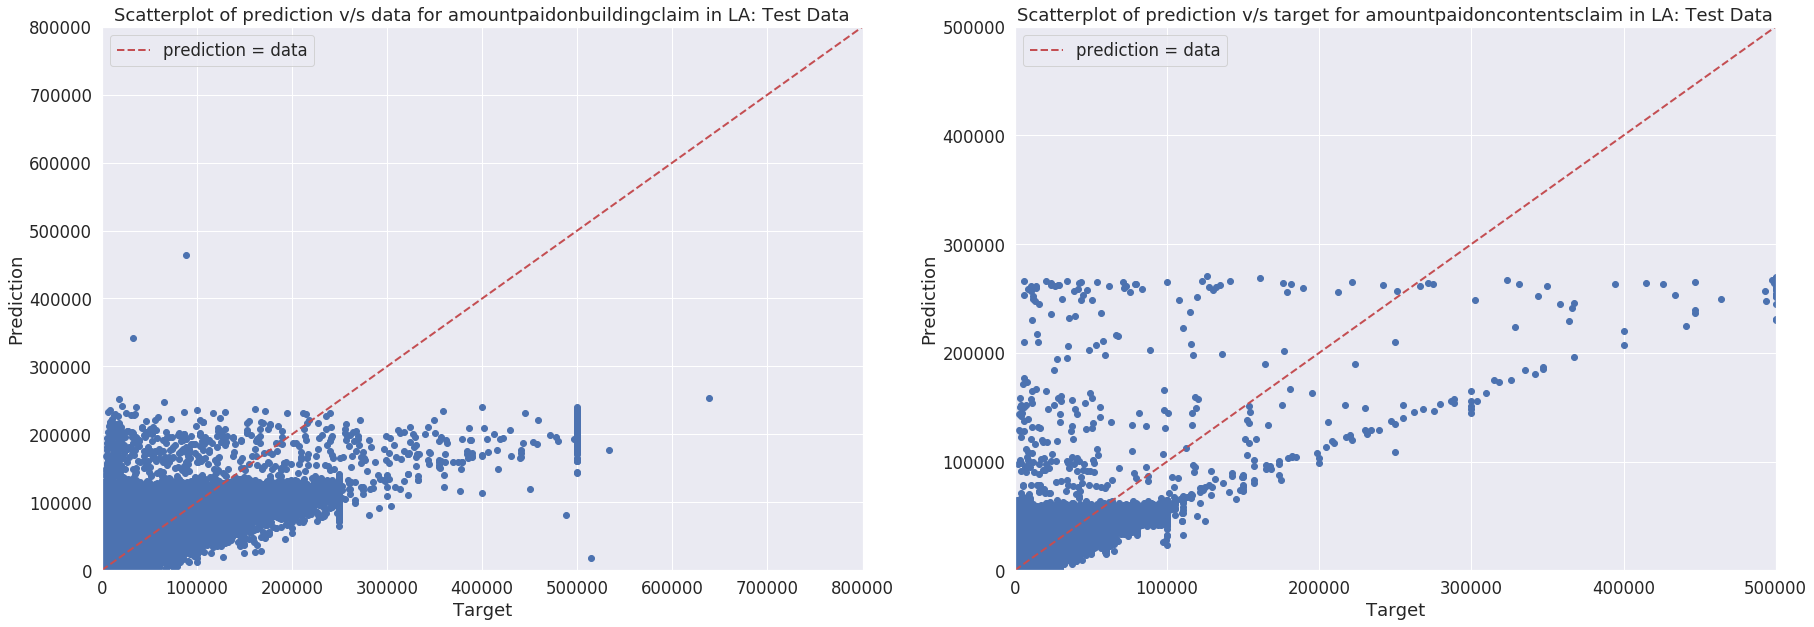

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


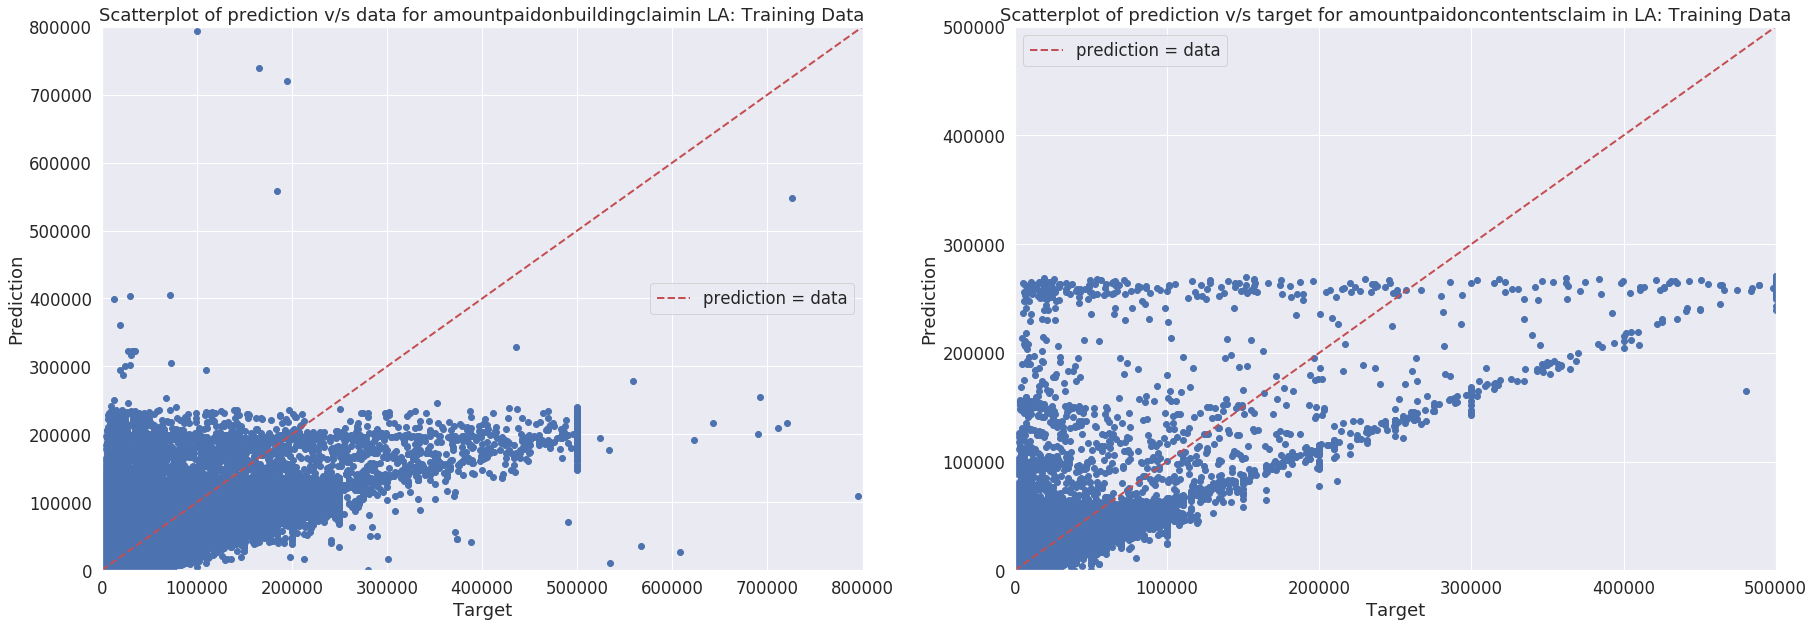

In [0]:
# Analysis of Prediction v/s Target 
test_title = ["Scatterplot of prediction v/s data for amountpaidonbuildingclaim in LA: Test Data","Scatterplot of prediction v/s target for amountpaidoncontentsclaim in LA: Test Data"]
train_title = ["Scatterplot of prediction v/s data for amountpaidonbuildingclaimin LA: Training Data","Scatterplot of prediction v/s target for amountpaidoncontentsclaim in LA: Training Data"]
plot_result(y1_test, y1_preds,800000,y2_test,y2_preds, 500000, test_title)
plot_result(y1_train, y1_preds_train,800000,y2_train,y2_preds_train, 500000, train_title)

We now try two different regression models to improve our prediction accuracy
1. Random Forest Regression
2. Gradient Boosting Regression

## Random Forest Regressor for each individual states with non zero amount claims

The prediction accuracy is better than the one achieved by linear regression. The overall accuracy has improved to 71% on amountpaidonbuilding claims and 65% on amountpaidonconetents. We also observe that the scatterplot fitting gets better with more number of datapoint closer to the prediction = target line.

Internally the maxdepth values of 2,5,10 and 15 were tested to optimize the model performance. The maxdepth of 10 was selected to give overall higher accuracy with reasonable execution time.  

In [0]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error

# amountpaidonbuildingclaim: Random Tree Regressor with max depth 10
rfregr1 = ensemble.RandomForestRegressor(max_depth=10, random_state=0)
rfregr1.fit(X1_train, y1_train)

# We are making predictions here
y1_preds_train = rfregr1.predict(X1_train)
y1_preds_test = rfregr1.predict(X1_test)
print("R-squared of the model on the training set is: {}".format(rfregr1.score(X1_train, y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(rfregr1.score(X1_test, y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y1_test, y1_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y1_test, y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y1_test, y1_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y1_test - y1_preds_test) / y1_test)) * 100))

# amountpaidoncontentsclaim: Random Tree Regressor with max depth 10
rfregr2 = ensemble.RandomForestRegressor(max_depth=10, random_state=0)
rfregr2.fit(X2_train, y2_train)

# We are making predictions here
y2_preds_train = rfregr2.predict(X2_train)
y2_preds_test = rfregr2.predict(X2_test)
print("R-squared of the model on the training set is: {}".format(rfregr2.score(X2_train, y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(rfregr2.score(X2_test, y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y2_test, y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y2_test, y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y2_test, y2_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y2_test - y2_preds_test) / y2_test)) * 100))

R-squared of the model on the training set is: 0.7425694279706876
-----Test set statistics-----
R-squared of the model on the test set is: 0.7131250817534318
Mean absolute error of the prediction is: 17335.606046401033
Mean squared error of the prediction is: 1035147363.4807228
Root mean squared error of the prediction is: 32173.70608867935
Mean absolute percentage error of the prediction is: 184.4487369109305
R-squared of the model on the training set is: 0.7724478933896991
-----Test set statistics-----
R-squared of the model on the test set is: 0.6580665217698228
Mean absolute error of the prediction is: 8048.731369426536
Mean squared error of the prediction is: 280212865.7498285
Root mean squared error of the prediction is: 16739.55990311061
Mean absolute percentage error of the prediction is: 210.81421318485275


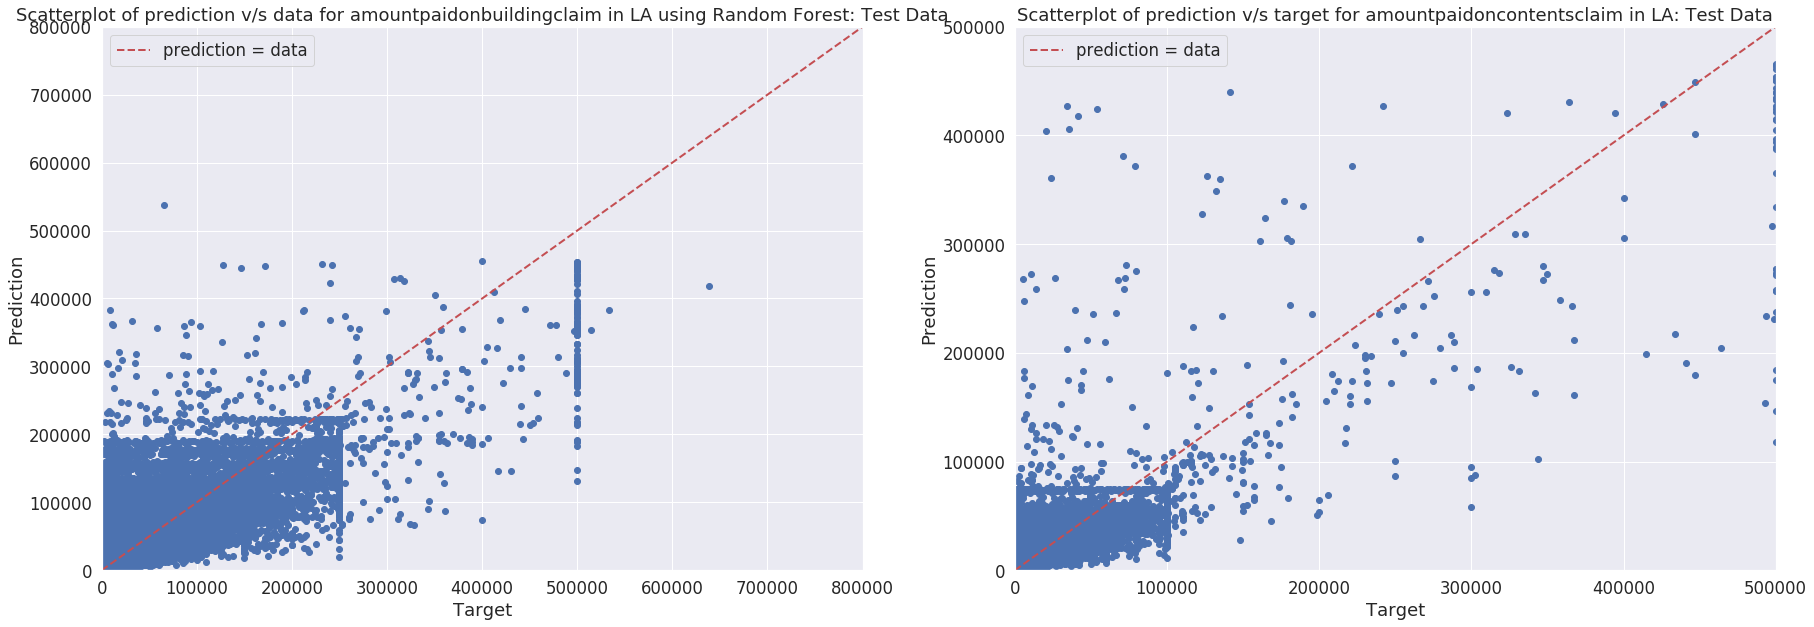

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


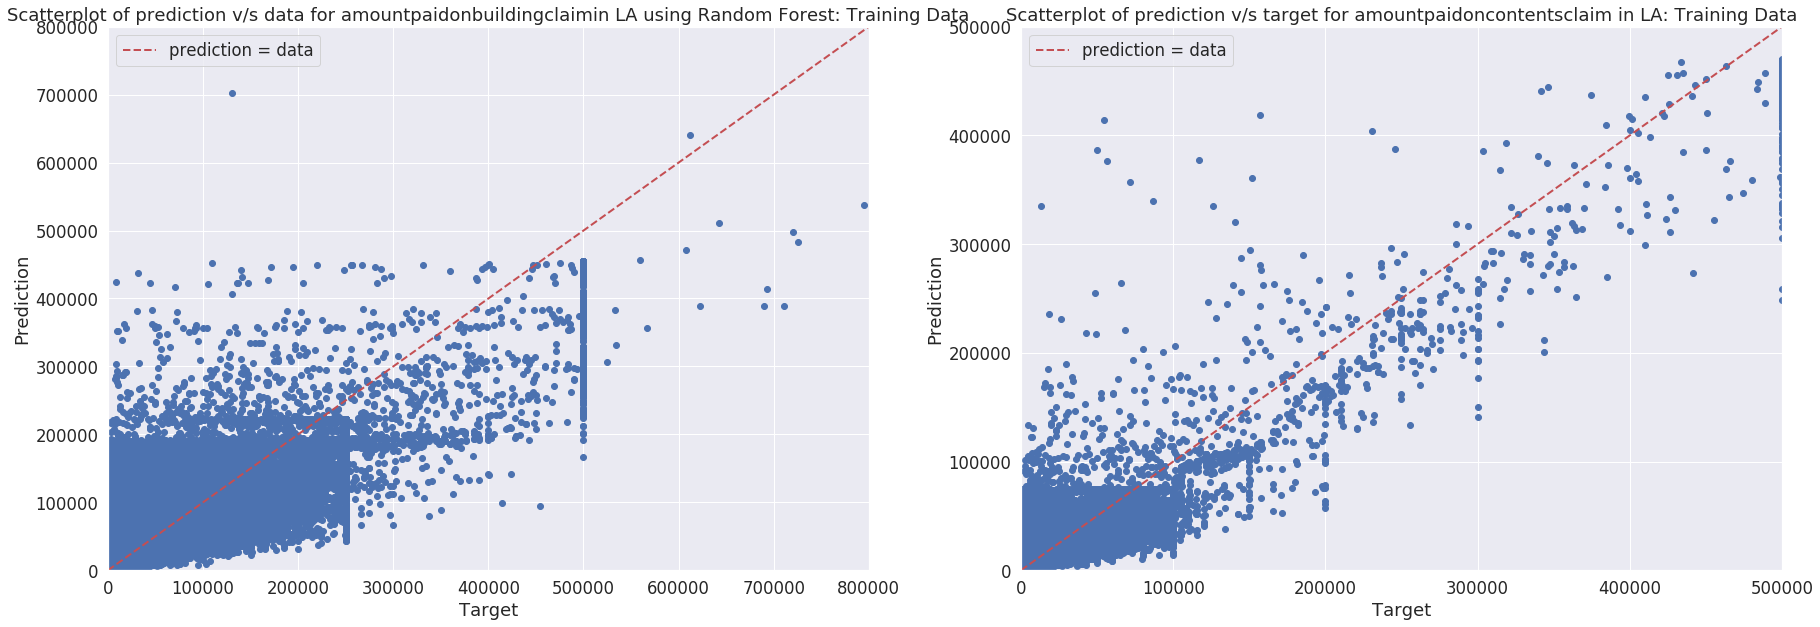

In [0]:
# Analysis of Prediction v/s Target 
test_title = ["Scatterplot of prediction v/s data for amountpaidonbuildingclaim in LA using Random Forest: Test Data","Scatterplot of prediction v/s target for amountpaidoncontentsclaim in LA: Test Data"]
train_title = ["Scatterplot of prediction v/s data for amountpaidonbuildingclaimin LA using Random Forest: Training Data","Scatterplot of prediction v/s target for amountpaidoncontentsclaim in LA: Training Data"]
plot_result(y1_test, y1_preds_test,800000,y2_test,y2_preds_test, 500000, test_title)
plot_result(y1_train, y1_preds_train,800000,y2_train,y2_preds_train, 500000, train_title)

##Gradient Boosting Regressor for each individual states with non zero amount claims

The overall accuracy has increased to 77% on amountpaidonbuilding claims and 68% on amountpaidonconetents. GB modeling has overall better fitting as observed in the scatterplots of prediction v/s target. We observe that the fitting for higher values ie building claims > 500000 and content claims > 100000 is much better, which helps in increasing the overall accuracy.

The maxdepth of 10 was selected to give overall higher accuracy with reasonable execution time.  

In [0]:
from sklearn.ensemble import GradientBoostingRegressor

# amountpaidonbuildingclaim: Gradient Boosting Regressor with max depth 10
gbregr1 = ensemble.GradientBoostingRegressor(max_depth=10, random_state=0)
gbregr1.fit(X1_train, y1_train)

# We are making predictions here
y1_preds_train = gbregr1.predict(X1_train)
y1_preds_test = gbregr1.predict(X1_test)
print("R-squared of the model on the training set is: {}".format(gbregr1.score(X1_train, y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(gbregr1.score(X1_test, y1_test)))
print("amountpaidonbuildingclaim: Mean absolute error of the prediction is: {}".format(mean_absolute_error(y1_test, y1_preds_test)))
print("amountpaidonbuildingclaim: Mean squared error of the prediction is: {}".format(mse(y1_test, y1_preds_test)))
print("amountpaidonbuildingclaim: Root mean squared error of the prediction is: {}".format(rmse(y1_test, y1_preds_test)))
print("amountpaidonbuildingclaim: Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y1_test - y1_preds_test) / y1_test)) * 100))

# amountpaidoncontentsclaim: Gradient Boosting Regressor with max depth 10
gbregr2 = ensemble.GradientBoostingRegressor(max_depth=10, random_state=0)
gbregr2.fit(X2_train, y2_train)

# We are making predictions here
y2_preds_train = gbregr2.predict(X2_train)
y2_preds_test = gbregr2.predict(X2_test)
print("R-squared of the model on the training set is: {}".format(gbregr2.score(X2_train, y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(gbregr2.score(X2_test, y2_test)))
print("amountpaidoncontentsclaim: Mean absolute error of the prediction is: {}".format(mean_absolute_error(y2_test, y2_preds_test)))
print("amountpaidoncontentsclaim: Mean squared error of the prediction is: {}".format(mse(y2_test, y2_preds_test)))
print("amountpaidoncontentsclaim: Root mean squared error of the prediction is: {}".format(rmse(y2_test, y2_preds_test)))
print("amountpaidoncontentsclaim: Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y2_test - y2_preds_test) / y2_test)) * 100))

R-squared of the model on the training set is: 0.85933352987978
-----Test set statistics-----
R-squared of the model on the test set is: 0.7715848700693619
amountpaidonbuildingclaim: Mean absolute error of the prediction is: 15049.767219663649
amountpaidonbuildingclaim: Mean squared error of the prediction is: 824203527.349102
amountpaidonbuildingclaim: Root mean squared error of the prediction is: 28708.945075517873
amountpaidonbuildingclaim: Mean absolute percentage error of the prediction is: 163.1563342732245
R-squared of the model on the training set is: 0.8975587059143455
-----Test set statistics-----
R-squared of the model on the test set is: 0.6880547560445417
amountpaidoncontentsclaim: Mean absolute error of the prediction is: 6982.368552960714
amountpaidoncontentsclaim: Mean squared error of the prediction is: 255637649.8090263
amountpaidoncontentsclaim: Root mean squared error of the prediction is: 15988.672546807202
amountpaidoncontentsclaim: Mean absolute percentage error 

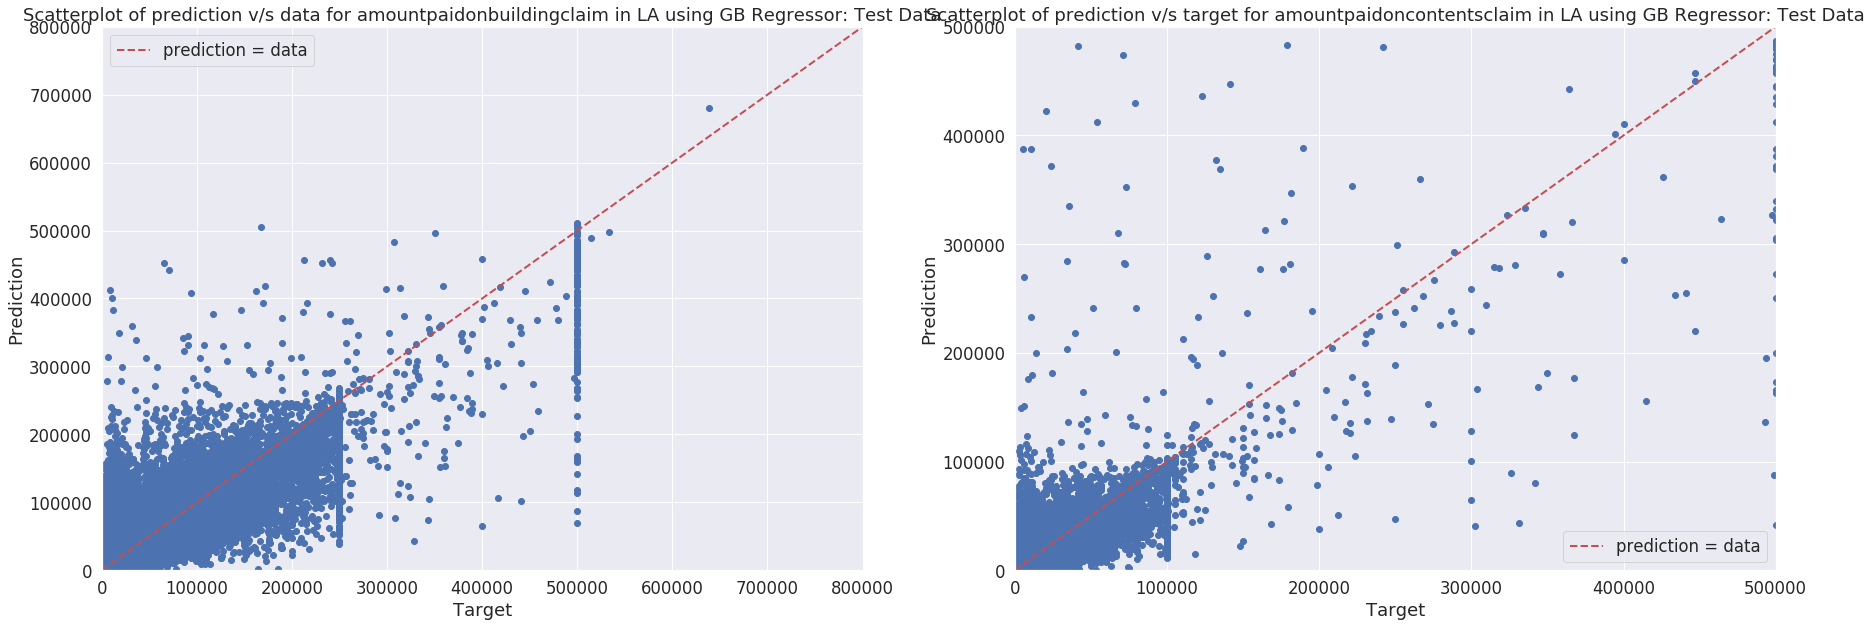

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


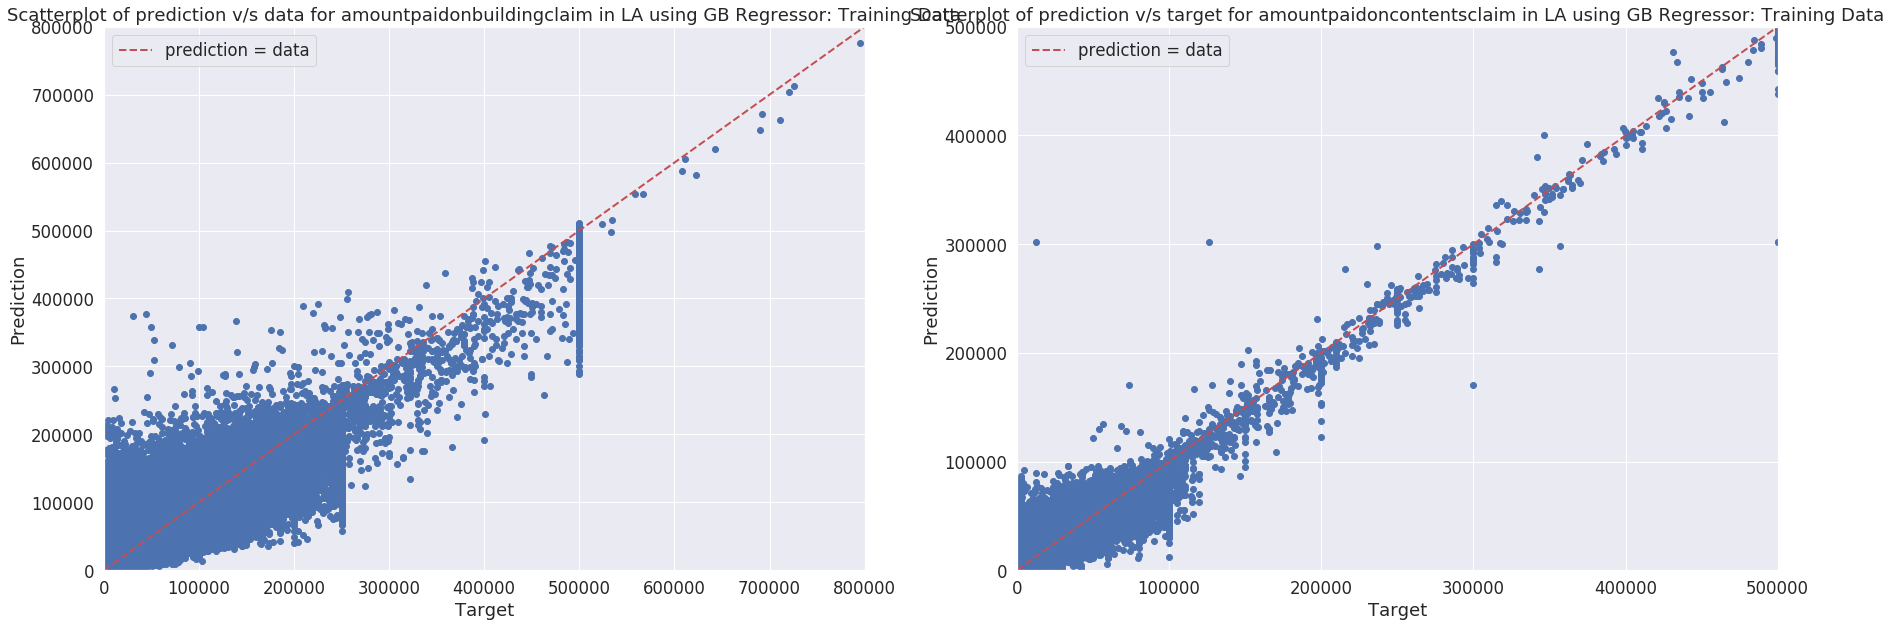

In [0]:
# Analysis of Prediction v/s Target 
test_title = ["Scatterplot of prediction v/s data for amountpaidonbuildingclaim in LA using GB Regressor: Test Data","Scatterplot of prediction v/s target for amountpaidoncontentsclaim in LA using GB Regressor: Test Data"]
train_title = ["Scatterplot of prediction v/s data for amountpaidonbuildingclaim in LA using GB Regressor: Training Data","Scatterplot of prediction v/s target for amountpaidoncontentsclaim in LA using GB Regressor: Training Data"]
plot_result(y1_test, y1_preds_test,800000,y2_test,y2_preds_test, 500000, test_title)
plot_result(y1_train, y1_preds_train,800000,y2_train,y2_preds_train, 500000, train_title)

#Conclusion Supervise Learning : Regression
From our modelling test we deduce that 
1. a state wise modelling approach is needed to training an accurate prediction model.
2. Modelling using non zero amount claims helps in achieving better prediction results.
3. All three type of regressors: 1) Linear, 2) Random Forest and 3) Gradient Boosting Model achieve an accuracy of 65% or more. 
4. Gradient Boostin Model overall gives the higher accuracy and model fit of 77% on buildling claims and 68% on content claims

# Supervised Learning: Classification of Claim Approval

So far we have dealt with regressors using non zero amount claims amounts . By eliminating these claims we improved the overall performance of our regressor models. However, based on the datapoint we still are unable to model the data with zero amount claims. 

To solve this issue we alter your modelling to a classification problem of claim approval based on the definition of ratio which is 

Ratio % = Amount paid / Total insurance coverage 

If amount paid is greater than 1% of the total insurance covergae we deemed it to be claim approved and less than 1% deemed to be rejected
1. Approval : Ratio > 1.0
2. Denial: Ratio < 1.0

This also translates in 'claim approval' meaning a non zero claims which can be predicted using regressor, whereas 'claim rejects' means zero amount paid to the claimee. 

In the example below we use the datapoints from state of LA only and train our classifier

In [0]:
# Dataset for Modelling
df_full_ml = df_full_fix.copy()

# To remove any records with null longitude/latitude information
cond = df_full_ml['longitude'].isnull()
df_full_ml = df_full_ml[~cond].reset_index()
df_full_ml.drop(['index'], axis = 1, inplace = True)

# Selecting on LA state
cond = (df_full_ml['state'] == 'LA')
df_full_ml = df_full_ml[cond].reset_index()
df_full_ml.drop(['index'], axis = 1, inplace = True)

# Approval Rating
df_full_ml['ratio1'] =  100*df_full_ml["amountpaidonbuildingclaim"]/(1+df_full_ml['totalbuildinginsurancecoverage'])
df_full_ml['ratio2'] =  100*df_full_ml["amountpaidoncontentsclaim"]/(1+df_full_ml['totalcontentsinsurancecoverage'])
df_full_ml['approv_rat1'] = 0
df_full_ml['approv_rat2'] = 0
df_full_ml.loc[df_full_ml['ratio1'] >=1, 'approv_rat1'] = 1
df_full_ml.loc[df_full_ml['ratio2'] >=1, 'approv_rat2'] = 1

###### Step 1: Strip dates to year/month/day
# Month and day of loss
df_full_ml['monthofloss'] = pd.to_datetime(df_full_ml['dateofloss']).dt.month
df_full_ml['dayofloss'] = pd.to_datetime(df_full_ml['dateofloss']).dt.day
# Year, Month, day of construction
df_full_ml.loc[df_full_ml['originalconstructiondate'] == '1111-11-11','originalconstructiondate'] = df_full_ml.loc[df_full_ml['originalconstructiondate'] == '1111-11-11','originalnbdate']
df_full_ml['yearofconst'] = pd.to_datetime(df_full_ml['originalconstructiondate']).dt.year
df_full_ml['monthofconst'] = pd.to_datetime(df_full_ml['originalconstructiondate']).dt.month
df_full_ml['dayofconst'] = pd.to_datetime(df_full_ml['originalconstructiondate']).dt.day
# Year, Month, day of flood policy
df_full_ml['yearofnb'] = pd.to_datetime(df_full_ml['originalnbdate']).dt.year
df_full_ml['monthofnb'] = pd.to_datetime(df_full_ml['originalnbdate']).dt.month
df_full_ml['dayofnb'] = pd.to_datetime(df_full_ml['originalnbdate']).dt.day

###### Step 2: Dropping Columns to simplify the dataframe
drop_col= ['asofdate','state','reportedcity','countycode','reportedzipcode','censustract','floodzone','locationofcontents','dateofloss','originalconstructiondate','originalnbdate']
for col in drop_col:
  df_full_ml.drop(col,axis = 1, inplace = True)

###### Step 3: Getting the dummy varibles of categorical variables
obj_col = df_full_ml.columns[df_full_ml.dtypes == 'object']
nonobj_col = df_full_ml.columns[df_full_ml.dtypes != 'object']
# Combined dataset with continuous and categorical variables
df_full_ml = pd.concat([df_full_ml[nonobj_col],pd.get_dummies(df_full_ml[obj_col],drop_first= True)], axis=1)

###### Step 4: Split Target and Input Feature
Y1 = df_full_ml[~df_full_ml["amountpaidonbuildingclaim"].isnull()]["approv_rat1"].astype(int)
Y2 = df_full_ml[~df_full_ml["amountpaidoncontentsclaim"].isnull()]["approv_rat2"].astype(int)
X = df_full_ml[~df_full_ml["amountpaidonbuildingclaim"].isnull()].drop(["amountpaidonbuildingclaim",'amountpaidoncontentsclaim','amountpaidonincreasedcostofcomplianceclaim','ratio1','ratio2','approv_rat1','approv_rat2'], axis=1)

##### Step5: Split into test and train dataset
X1_train, X1_test, y1_train, y1_test = train_test_split(X, Y1, test_size = 0.2, random_state = 465)
print("The number of observations in training set is {} for amountpaidonbuildingclaim".format(X1_train.shape[0]))
print("The number of observations in test set is {} for amountpaidonbuildingclaim".format(X1_test.shape[0]))

X2_train, X2_test, y2_train, y2_test = train_test_split(X, Y2, test_size = 0.2, random_state = 465)
print("The number of observations in training set is {} for amountpaidoncontentsclaim".format(X2_train.shape[0]))
print("The number of observations in test set is {} for amountpaidoncontentsclaim".format(X2_test.shape[0]))

The number of observations in training set is 359780 for amountpaidonbuildingclaim
The number of observations in test set is 89945 for amountpaidonbuildingclaim
The number of observations in training set is 359780 for amountpaidoncontentsclaim
The number of observations in test set is 89945 for amountpaidoncontentsclaim


In [0]:
### Definition function for a confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.xlabel('Predicted label')
    plt.ylabel('True label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Definition function for a classification modelling metrices
def accuracy_table(X_train, y_train,y_clfs_train, X_test, y_test,y_clfs_test,clfs,name):
  # Accuracy tables.
  table_train = pd.crosstab(y_train, y_clfs_train, margins=True)
  table_test = pd.crosstab(y_test, y_clfs_test, margins=True)

  train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
  train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

  test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
  test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

  train_tI_errors *= 100
  train_tII_errors *= 100
  test_tI_errors *= 100
  test_tII_errors *= 100

  print((
    '{}: Training set accuracy: {}\n'
    '{}: Percent Type I errors: {}\n'
    '{}: Percent Type II errors: {}\n\n'
    '{}: Test set accuracy: {}\n'
    '{}: Percent Type I errors: {}\n'
    '{}: Percent Type II errors: {}\n'
  ).format(name,clfs.score(X_train, y_train)*100,name,train_tI_errors, name,train_tII_errors, name,clfs.score(X_test, y_test)*100,name,test_tI_errors, name, test_tII_errors))

## Benchmark Classification: Dummy Classifier

To benchmark our classifier, we employ a dummy classifier that selects the most frequent response as its answers. When testing for a classifier we will aim to have higher accuarcy results than the dummy classifier. 

Because of the fact that our data point are highly skewed towards non zero claims, the dummy classifier almost predict upto 71% accurate on amountpaidonbuilding and 51% accurate on amountpaidoncontent

There are two factors by which we would judge the performance of our datasets.
1. Accuracy scores of prediction on training and test datasets
2. Type I Errors (false positive) vs Type II Error(false negative)

A false positive would imply that our prediction of a zero claim to be non-zero where as a false negative would imply our prediction of a non-zero claim to be zero. For our modelling purpose, we favour the model which is better in terms of minimizing errors on the false postive side.

amountpaidonbuildingclaim: Training set accuracy 71.46978709211184
amountpaidonbuildingclaim: Test set accuracy 71.4814608927678

amountpaidoncontentsclaims: Training set accuracy 52.20051142364779
amountpaidoncontentsclaims: Test set accuracy 52.09739285118684



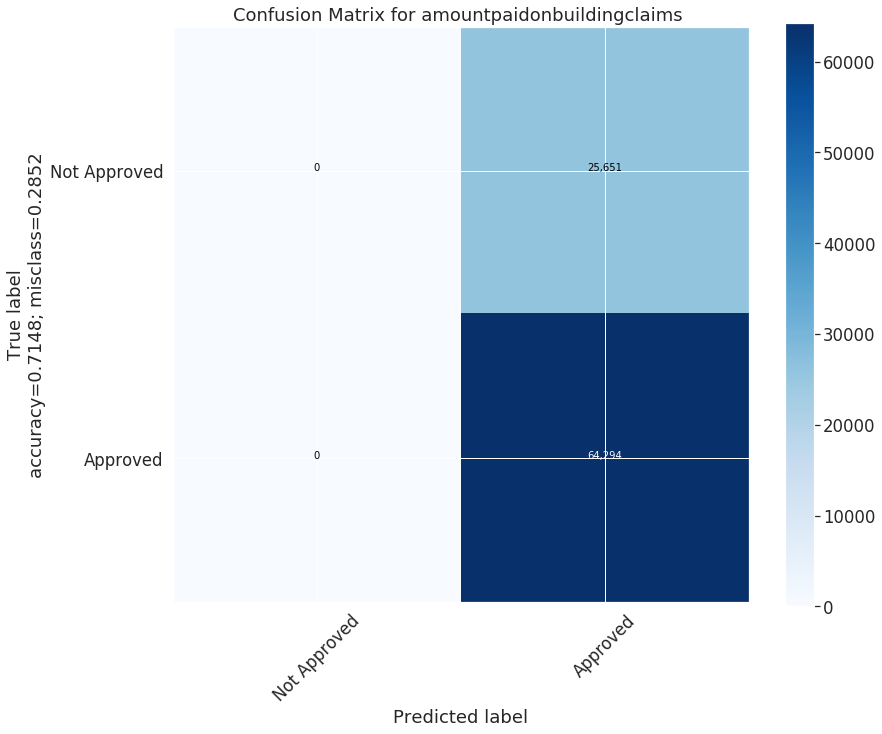

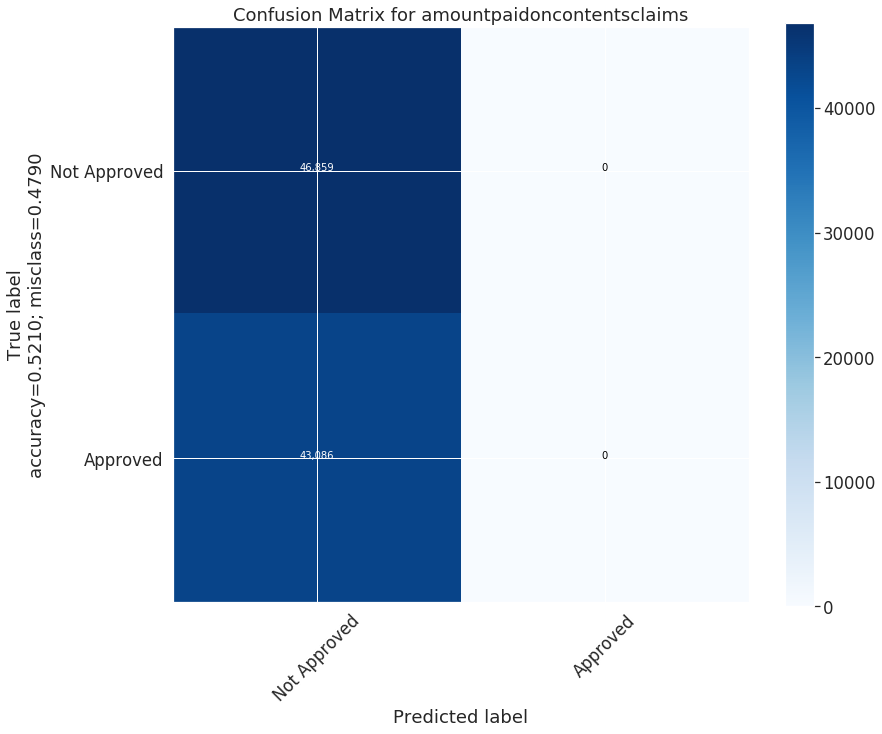

In [0]:
from sklearn.dummy import DummyClassifier

# Classification Modelling for amountpaidonbuildingclaim
rfc1 = DummyClassifier(strategy = 'most_frequent')
rfc1.fit(X1_train, y1_train)
y1_clfs_train = rfc1.predict(X1_train).astype(int)
y1_clfs_test = rfc1.predict(X1_test).astype(int)
#accuracy_table(X1_train, y1_train,y1_clfs_train, X1_test, y1_test,y1_clfs_test,rfc1,'amountpaidonbuildingclaims')
print('amountpaidonbuildingclaim: Training set accuracy {}'.format(rfc1.score(X1_train, y1_train)*100))
print('amountpaidonbuildingclaim: Test set accuracy {}\n'.format(rfc1.score(X1_test, y1_test)*100))

# Classification Modelling for amountpaidoncontentsclaim
rfc2 = DummyClassifier(strategy = 'most_frequent')
rfc2.fit(X2_train, y2_train)
y2_clfs_train = rfc2.predict(X2_train)
y2_clfs_test = rfc2.predict(X2_test)
#accuracy_table(X2_train, y2_train,y2_clfs_train, X2_test, y2_test,y2_clfs_test,rfc2,'amountpaidoncontentsclaims')
print('amountpaidoncontentsclaims: Training set accuracy {}'.format(rfc2.score(X2_train, y2_train)*100))
print('amountpaidoncontentsclaims: Test set accuracy {}\n'.format(rfc2.score(X2_test, y2_test)*100))

# Creating confusion matrix
from sklearn.metrics import confusion_matrix
confusion1 = confusion_matrix(y1_test, y1_clfs_test, labels=[0, 1])
confusion2 = confusion_matrix(y2_test, y2_clfs_test, labels=[0, 1])
plot_confusion_matrix(cm=confusion1, target_names = ['Not Approved', 'Approved'], title = 'Confusion Matrix for amountpaidonbuildingclaims ',normalize=False)
plot_confusion_matrix(cm=confusion2, target_names = ['Not Approved', 'Approved'], title = 'Confusion Matrix for amountpaidoncontentsclaims',normalize=False)

## Random Forest Classification:

To begin with we start with a random forest classfier of max depth 10 similar to what was used for regression problem. In all, we find that our overall accuracy has improved and the Type I error reduced meaning our clssifier is overall performing better than dummy classifier. 

amountpaidonbuildingclaims: Training set accuracy: 77.09100005558953
amountpaidonbuildingclaims: Percent Type I errors: 21.410584245928067
amountpaidonbuildingclaims: Percent Type II errors: 1.498415698482406

amountpaidonbuildingclaims: Test set accuracy: 76.88587470120629
amountpaidonbuildingclaims: Percent Type I errors: 21.547612429818223
amountpaidonbuildingclaims: Percent Type II errors: 1.566512868975485

amountpaidoncontentsclaims: Training set accuracy: 72.41814442159097
amountpaidoncontentsclaims: Percent Type I errors: 22.892878981599868
amountpaidoncontentsclaims: Percent Type II errors: 4.6889765968091615

amountpaidoncontentsclaims: Test set accuracy: 72.51542609372395
amountpaidoncontentsclaims: Percent Type I errors: 22.896214353215854
amountpaidoncontentsclaims: Percent Type II errors: 4.5883595530602035



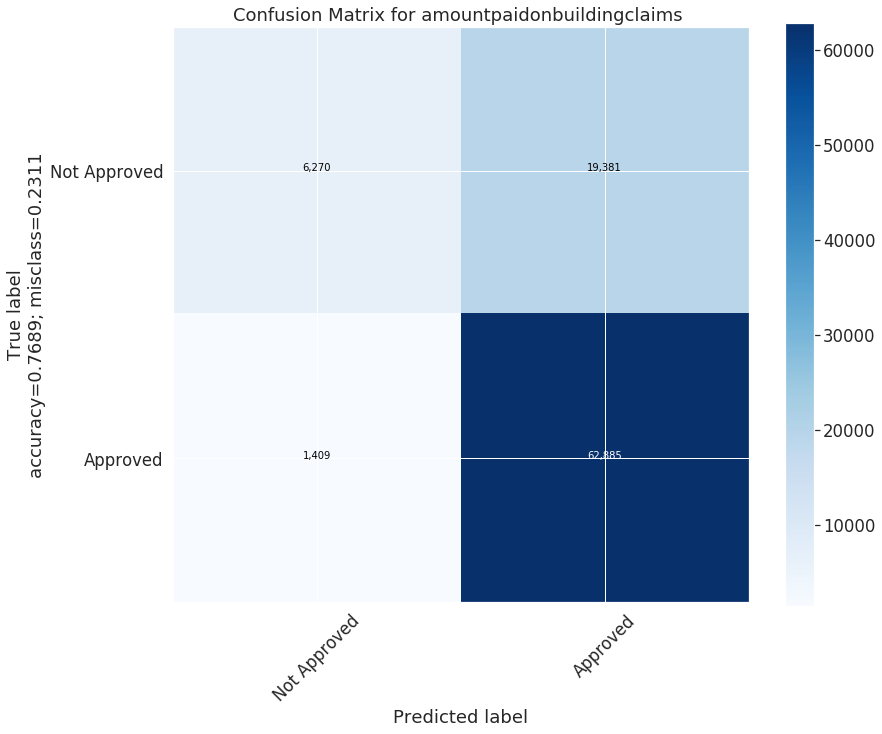

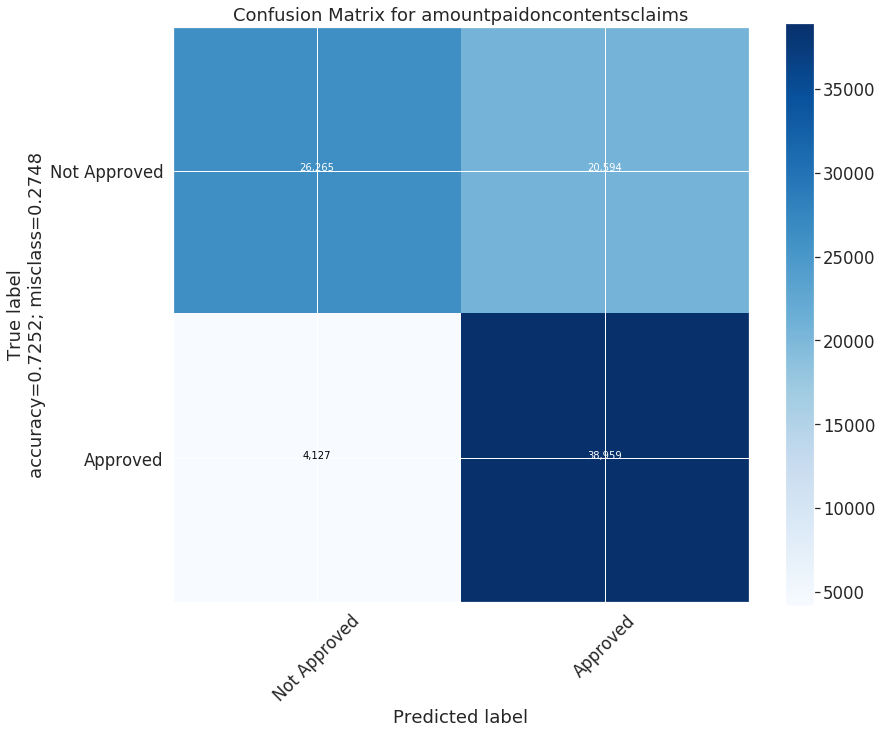

In [0]:
from sklearn import ensemble

# Classification Modelling for amountpaidonbuildingclaim
rfc1 = ensemble.RandomForestClassifier(max_depth=10, random_state=0)
rfc1.fit(X1_train, y1_train)
y1_clfs_train = rfc1.predict(X1_train)
y1_clfs_test = rfc1.predict(X1_test)
accuracy_table(X1_train, y1_train,y1_clfs_train, X1_test, y1_test,y1_clfs_test,rfc1,'amountpaidonbuildingclaims')

# Classification Modelling for amountpaidoncontentsclaim
rfc2 = ensemble.RandomForestClassifier(max_depth=5, random_state=0)
rfc2.fit(X2_train, y2_train)
y2_clfs_train = rfc2.predict(X2_train)
y2_clfs_test = rfc2.predict(X2_test)
accuracy_table(X2_train, y2_train,y2_clfs_train, X2_test, y2_test,y2_clfs_test,rfc2,'amountpaidoncontentsclaims')

# Creating confusion matrix
from sklearn.metrics import confusion_matrix
confusion1 = confusion_matrix(y1_test, y1_clfs_test, labels=[0, 1])
confusion2 = confusion_matrix(y2_test, y2_clfs_test, labels=[0, 1])
plot_confusion_matrix(cm=confusion1, target_names = ['Not Approved', 'Approved'], title = 'Confusion Matrix for amountpaidonbuildingclaims ',normalize=False)
plot_confusion_matrix(cm=confusion2, target_names = ['Not Approved', 'Approved'], title = 'Confusion Matrix for amountpaidoncontentsclaims',normalize=False)

## Gradient Boosting Classification:

To begin with we start with a random forest classfier of max depth 10 similar to what was used for regression problem. In all, we find that our overall accuracy has improved and the Type I error reduced meaning our classifier is overall performing better than dummy classifier. 



amountpaidonbuildingclaims: Training set accuracy: 83.99021624325978
amountpaidonbuildingclaims: Percent Type I errors: 13.016287731391408
amountpaidonbuildingclaims: Percent Type II errors: 2.9934960253488243

amountpaidonbuildingclaims: Test set accuracy: 81.17405080882762
amountpaidonbuildingclaims: Percent Type I errors: 14.645616765801323
amountpaidonbuildingclaims: Percent Type II errors: 4.18033242537106

amountpaidoncontentsclaims: Training set accuracy: 84.73984101395298
amountpaidoncontentsclaims: Percent Type I errors: 10.489187837011507
amountpaidoncontentsclaims: Percent Type II errors: 4.770971149035522

amountpaidoncontentsclaims: Test set accuracy: 79.94885763522153
amountpaidoncontentsclaims: Percent Type I errors: 12.895658457946524
amountpaidoncontentsclaims: Percent Type II errors: 7.155483906831953



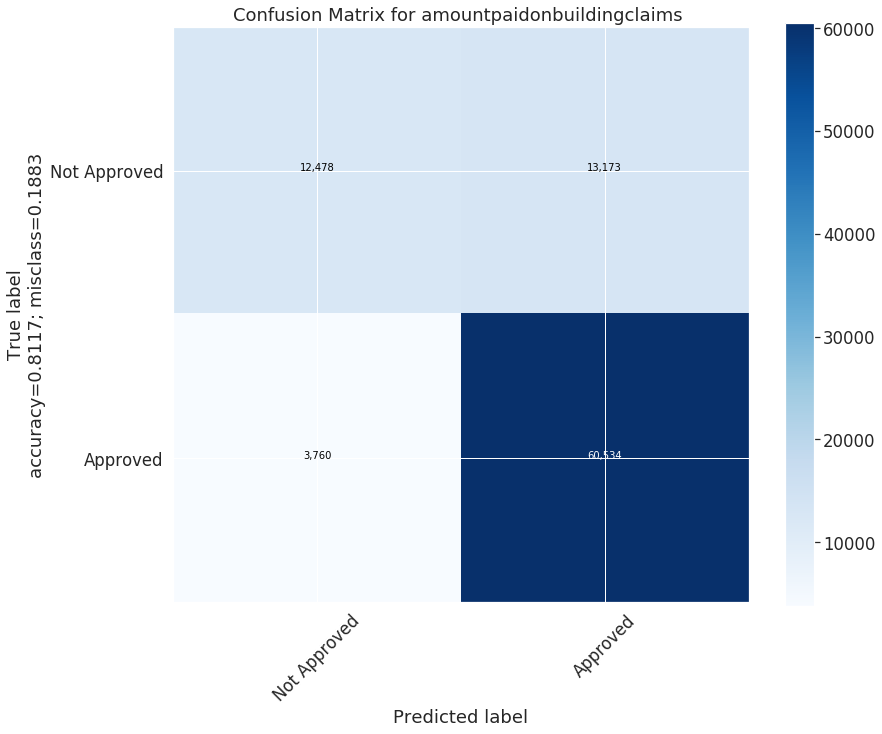

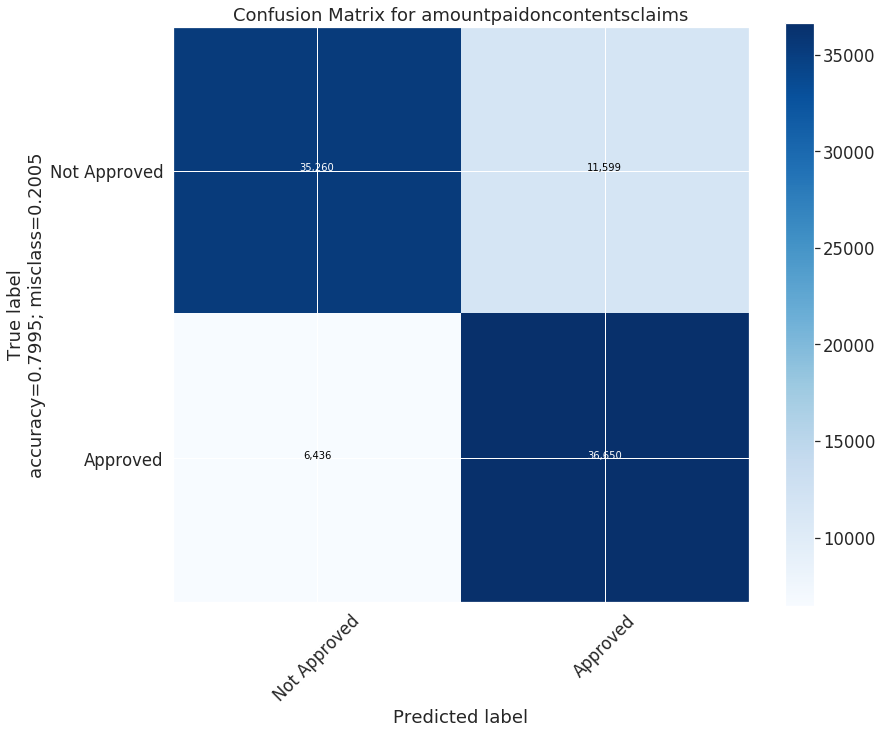

In [0]:
from sklearn import ensemble
params = {'max_depth': 10,
          'loss': 'deviance',
          'random_state': 0}

# Classification Modelling for amountpaidonbuildingclaim
rfc1 = ensemble.GradientBoostingClassifier(**params)
rfc1.fit(X1_train, y1_train)
y1_clfs_train = rfc1.predict(X1_train)
y1_clfs_test = rfc1.predict(X1_test)
accuracy_table(X1_train, y1_train,y1_clfs_train, X1_test, y1_test,y1_clfs_test,rfc1,'amountpaidonbuildingclaims')

# Classification Modelling for amountpaidoncontentsclaim
rfc2 = ensemble.GradientBoostingClassifier(**params)
rfc2.fit(X2_train, y2_train)
y2_clfs_train = rfc2.predict(X2_train)
y2_clfs_test = rfc2.predict(X2_test)
accuracy_table(X2_train, y2_train,y2_clfs_train, X2_test, y2_test,y2_clfs_test,rfc2,'amountpaidoncontentsclaims')

# Creating confusion matrix
from sklearn.metrics import confusion_matrix
confusion1 = confusion_matrix(y1_test, y1_clfs_test, labels=[0, 1])
confusion2 = confusion_matrix(y2_test, y2_clfs_test, labels=[0, 1])
plot_confusion_matrix(cm=confusion1, target_names = ['Not Approved', 'Approved'], title = 'Confusion Matrix for amountpaidonbuildingclaims ',normalize=False)
plot_confusion_matrix(cm=confusion2, target_names = ['Not Approved', 'Approved'], title = 'Confusion Matrix for amountpaidoncontentsclaims',normalize=False)

# Summary of Supervised Learning

The dataset from FEMA provides a large information of features that can be translated into accurate prediction of the amount claims to be made in the event of flood. For this excercise two separate claim amounts were used 1) amount paid on building and 2) amount paid on content claims. 

Based on the data distribution (among state and claims amounts), a two step modelling is needed to get accurate prediction. As the first step, the approval or denial status of a claim is checked. Upon the condition of approval, a regression model prediction is made on the possible claim amount for the event. This flow is followed (model training and execution) on individual states especially for the once where the number of datapoints are high. For the remaining state with lesser reported case of flooding, a combined pool of datapoint maybe used for prediction.

The approval classification modelling is based on making accurate classification and minizming type I (false positive) errors. Upon the test shown here, the gradient boosting classifiers overall performs the best with upto 80% accuracy scores.

The regression modelling based on gradient boosting give us the higher accuracy prediction of 68% to 78%. Besides this the linear and random forest modelling all gave us the above 60% prediction results. 

# Possible Improvements to Modelling
The current excercise uses mostly default or internally tested setting. However to achieve better prediction results the following cases may be tested:
1. Log Transformation of insurance coverage and target (claims amount) as our current distribution is highly asymmetric
2. Feature standardization and Principal Component Analysis to reduce dimension and preserve the data variance.
3. Tuning the modelling parameter for better performance. Also a Voting regressor/classifier can be used among the three tested 
4. Using the reported city to better fit our prediction models. However, this introduces many dummy variable (12000 in total).
5. Coupling the prediction result of building claims with content claims and vice versa
6. Using deep learning modelling such as neural network for prediction models 